# Solutions Engineering Workload Modeling

## Project Overview

This Jupyter notebook models Solutions Engineering workload based on revenue targets, conversion rates, staffing levels, and activity assumptions. It enables scenario modeling to understand capacity requirements and utilization across different business conditions.

### Key Capabilities
- **Revenue-Driven Pipeline Modeling**: Calculate required activities from quarterly revenue goals
- **Interactive Parameter Controls**: Adjust assumptions and see real-time impact
- **Capacity Analysis**: Understand SE team utilization and identify constraints
- **Account Management Modeling**: Factor in existing customer meeting requirements
- **Strategic Activity Planning**: Allocate time for non-pipeline activities
- **Professional Visualizations**: Executive-ready charts and dashboards

### Business Applications
- Staffing planning and capacity forecasting
- Revenue target feasibility analysis
- Resource allocation optimization
- Scenario planning for different business conditions

## Introduction

### Workload Modeling Approach

This model uses a **revenue-driven approach** to calculate SE workload requirements:

1. **Start with Revenue Goals**: Quarterly revenue targets drive required new logo counts
2. **Work Backwards Through Funnel**: Calculate required demos, evaluations, and meetings
3. **Factor in Activity Types**: Different evaluation types require different SE time investments
4. **Add Account Management**: Existing customer meetings and onboarding requirements
5. **Include Strategic Activities**: Time for customer zero, content creation, and enablement
6. **Calculate Utilization**: Compare total workload to available SE capacity

### Key Assumptions
- **40-hour work week** standard capacity per SE
- **Conversion rates** remain consistent across evaluation types
- **Account meeting frequencies** based on customer segment strategy
- **Strategic activities** distributed between ICs and Directors based on role allocation

## Library Imports and Configuration

In [30]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive widgets for parameter controls
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configure matplotlib for inline display
%matplotlib inline

# Set seaborn style for professional appearance
sns.set_style("whitegrid")
sns.set_palette("husl")

# Configure pandas display options for better table formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.precision', 2)

# Configure matplotlib for better chart appearance
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11

print("✅ All libraries imported successfully")
print("✅ Configuration applied")
print("📊 Ready to begin workload modeling")

✅ All libraries imported successfully
✅ Configuration applied
📊 Ready to begin workload modeling


## Table of Contents

### 📋 Core Sections
1. [**Helper Functions Framework**](#helper-functions) - Core calculation functions
2. [**Parameter Management**](#parameter-management) - Input parameter definitions and validation
3. [**Revenue & Pipeline Calculations**](#revenue-pipeline) - Core funnel math and workload calculations
4. [**Account Management Logic**](#account-management) - Meeting frequency and time allocation
5. [**Strategic Activities Logic**](#strategic-activities) - Strategic time allocation and distribution

### 🎛️ Interactive Interface
6. [**Interactive Parameter Controls**](#interactive-controls) - Widget-based parameter input
7. [**Real-time Calculations**](#real-time-calculations) - Live calculation updates

### 📊 Visualization & Results
8. [**Core Visualizations**](#core-visualizations) - Essential charts for utilization and capacity
9. [**Executive Dashboard**](#executive-dashboard) - Professional dashboard with multiple chart types
10. [**Results Summary & Export**](#results-summary) - Executive summary and export capabilities

### 🔧 Testing & Validation
11. [**Testing Framework**](#testing) - Comprehensive validation and testing
12. [**Usage Examples**](#examples) - Sample scenarios and use cases

---

# 1. Helper Functions Framework {#helper-functions}

*Core calculation functions that will be reused throughout the notebook*

In [31]:
# Core helper functions for SE workload modeling calculations

def calculate_required_new_logos(quarterly_revenue_goal, average_selling_price):
    """
    Calculate the number of new logos needed to meet quarterly revenue goals.
    
    Parameters:
    - quarterly_revenue_goal (float): Target revenue for the quarter
    - average_selling_price (float): Average deal size
    
    Returns:
    - float: Number of new logos required
    """
    if average_selling_price <= 0:
        raise ValueError("Average selling price must be greater than 0")
    
    return quarterly_revenue_goal / average_selling_price


def calculate_weighted_win_rate(eval_mix_percentages, win_rates):
    """
    Calculate weighted average win rate across all evaluation types.
    
    Parameters:
    - eval_mix_percentages (dict): Percentages for each evaluation type
    - win_rates (dict): Win rates for each evaluation type
    
    Returns:
    - float: Weighted average win rate (0-1)
    """
    total_percentage = sum(eval_mix_percentages.values())
    if abs(total_percentage - 100) > 0.01:  # Allow small floating point errors
        raise ValueError(f"Evaluation mix percentages must sum to 100%, got {total_percentage}%")
    
    weighted_sum = 0
    for eval_type in eval_mix_percentages:
        # Convert eval_type from percentage naming to win rate naming
        if eval_type.endswith('_percentage'):
            win_rate_key = eval_type.replace('_percentage', '_win_rate')
        else:
            win_rate_key = f"{eval_type}_win_rate"
            
        if win_rate_key not in win_rates:
            raise ValueError(f"Win rate not provided for evaluation type: {eval_type} (looking for {win_rate_key})")
        weighted_sum += (eval_mix_percentages[eval_type] / 100) * (win_rates[win_rate_key] / 100)
    
    return weighted_sum


def calculate_required_activities(new_logos_needed, conversion_rates, eval_mix, win_rates):
    """
    Work backwards through conversion funnel to calculate required weekly activities.
    
    Parameters:
    - new_logos_needed (float): Required new logos per quarter
    - conversion_rates (dict): Conversion rates for each funnel stage
    - eval_mix (dict): Percentage mix of evaluation types
    - win_rates (dict): Win rates by evaluation type
    
    Returns:
    - dict: Required weekly activities by type
    """
    # Calculate weighted win rate
    weighted_win_rate = calculate_weighted_win_rate(eval_mix, win_rates)
    
    # Work backwards through funnel (quarterly to weekly)
    weeks_per_quarter = 13
    
    # Required evaluations per quarter
    required_evaluations_quarterly = new_logos_needed / weighted_win_rate
    
    # Required demos per quarter (from tech eval conversion rate)
    required_demos_quarterly = required_evaluations_quarterly / (conversion_rates['tech_eval_conversion_rate'] / 100)
    
    # Required opportunities per quarter (from demo conversion rate)
    required_opportunities_quarterly = required_demos_quarterly / (conversion_rates['demo_conversion_rate'] / 100)
    
    # Required initial meetings per quarter (from opportunity creation rate)
    required_meetings_quarterly = required_opportunities_quarterly / (conversion_rates['opportunity_creation_rate'] / 100)
    
    # Convert to weekly and break down evaluations by type
    weekly_activities = {
        'initial_meetings': required_meetings_quarterly / weeks_per_quarter,
        'demos': required_demos_quarterly / weeks_per_quarter,
        'total_evaluations': required_evaluations_quarterly / weeks_per_quarter
    }
    
    # Break down evaluations by type
    for eval_type, percentage in eval_mix.items():
        eval_key = f"{eval_type.replace('_percentage', '')}_evaluations"
        weekly_activities[eval_key] = weekly_activities['total_evaluations'] * (percentage / 100)
    
    return weekly_activities


def calculate_evaluation_workload(weekly_evaluations_by_type, time_per_type):
    """
    Calculate SE time requirements for different evaluation types.
    
    Parameters:
    - weekly_evaluations_by_type (dict): Weekly evaluation counts by type
    - time_per_type (dict): Time requirements for each evaluation type
    
    Returns:
    - dict: Weekly hours needed by evaluation type
    """
    evaluation_hours = {}
    
    # Self-guided: ongoing weekly support hours
    if 'self_guided' in weekly_evaluations_by_type:
        evaluation_hours['self_guided'] = (weekly_evaluations_by_type['self_guided'] * 
                                         time_per_type['self_guided_support_hours_per_week'])
    
    # SE-led: ongoing weekly support hours  
    if 'se_led' in weekly_evaluations_by_type:
        evaluation_hours['se_led'] = (weekly_evaluations_by_type['se_led'] * 
                                    time_per_type['se_led_eval_hours_per_week'])
    
    # Rapid POV: total hours distributed over evaluation period (assume 2 weeks)
    if 'rapid_pov' in weekly_evaluations_by_type:
        rapid_pov_weeks = 2  # Standard duration for rapid POV
        evaluation_hours['rapid_pov'] = (weekly_evaluations_by_type['rapid_pov'] * 
                                       time_per_type['rapid_pov_total_hours'] / rapid_pov_weeks)
    
    # No evaluation type requires no SE time
    evaluation_hours['no_eval'] = 0
    
    return evaluation_hours


def calculate_demo_workload(weekly_demos, demo_time_params):
    """
    Calculate total demo workload including prep, delivery, and follow-up.
    
    Parameters:
    - weekly_demos (float): Number of demos per week
    - demo_time_params (dict): Time parameters for demo activities
    
    Returns:
    - float: Total weekly hours for demo activities
    """
    total_demo_time_per_demo = (demo_time_params['demo_prep_time'] + 
                               demo_time_params['demo_delivery_time'] + 
                               demo_time_params['demo_followup_time'])
    
    return weekly_demos * total_demo_time_per_demo


def calculate_meeting_workload(weekly_meetings, meeting_time):
    """
    Calculate workload for initial meetings including prep time.
    
    Parameters:
    - weekly_meetings (float): Number of initial meetings per week
    - meeting_time (float): Time per meeting including prep
    
    Returns:
    - float: Total weekly hours for initial meetings
    """
    return weekly_meetings * meeting_time


def calculate_account_meetings(account_counts, meeting_frequencies):
    """
    Calculate total meetings per month for existing accounts.
    
    Parameters:
    - account_counts (dict): Number of accounts by segment
    - meeting_frequencies (dict): Meeting frequency by segment (meetings/month)
    
    Returns:
    - dict: Monthly meetings by account segment
    """
    monthly_meetings = {}
    
    for segment, count in account_counts.items():
        if segment in meeting_frequencies:
            if segment == 'retain':
                # Retain accounts: frequency is "every X months", so meetings/month = 1/X
                meetings_per_month = count / meeting_frequencies[segment]
            else:
                # Other segments: frequency is meetings per month
                meetings_per_month = count * meeting_frequencies[segment]
            
            monthly_meetings[segment] = meetings_per_month
    
    return monthly_meetings


def calculate_new_logo_onboarding_meetings(new_logos_per_quarter, onboarding_params):
    """
    Calculate new customer onboarding meeting requirements.
    
    Parameters:
    - new_logos_per_quarter (float): New customers per quarter
    - onboarding_params (dict): Onboarding meeting parameters
    
    Returns:
    - dict: Monthly onboarding meeting requirements
    """
    monthly_onboarding = {}
    
    # Monthly meetings: 50% of new logos need 6 months of meetings
    monthly_customers = (new_logos_per_quarter * 
                        (onboarding_params['monthly_onboarding_percentage'] / 100))
    # 6 months of meetings spread across year = 6/12 = 0.5 factor
    monthly_onboarding['monthly_meetings'] = monthly_customers * 0.5
    
    # Quarterly meetings: 50% of new logos need 4 meetings per year
    quarterly_customers = (new_logos_per_quarter * 
                          (onboarding_params['quarterly_onboarding_percentage'] / 100))
    # 4 meetings per year = 4/12 meetings per month
    monthly_onboarding['quarterly_meetings'] = quarterly_customers * (4/12)
    
    return monthly_onboarding


def calculate_account_mgmt_hours(monthly_meetings, meeting_time_params):
    """
    Convert monthly meetings to weekly SE hours.
    
    Parameters:
    - monthly_meetings (dict): Monthly meeting counts by type
    - meeting_time_params (dict): Time per meeting including follow-up
    
    Returns:
    - float: Weekly hours for account management
    """
    total_monthly_meetings = sum(monthly_meetings.values())
    
    time_per_meeting = (meeting_time_params['meeting_duration_hours'] + 
                       meeting_time_params['meeting_followup_hours'])
    
    monthly_hours = total_monthly_meetings * time_per_meeting
    
    # Convert to weekly hours (assume 4.33 weeks per month)
    weekly_hours = monthly_hours / 4.33
    
    return weekly_hours


def calculate_strategic_workload(strategic_params, staffing_config):
    """
    Calculate strategic activity hours per role.
    
    Parameters:
    - strategic_params (dict): Strategic activity time parameters
    - staffing_config (dict): Team structure configuration
    
    Returns:
    - dict: Strategic hours by role type
    """
    # Calculate total strategic hours per week
    total_strategic_hours = 0
    
    # Handle min/max ranges by taking midpoint
    customer_zero_hours = (strategic_params['customer_zero_hours_min'] + 
                          strategic_params['customer_zero_hours_max']) / 2
    
    developer_advocacy_hours = (strategic_params['developer_advocacy_hours_min'] + 
                               strategic_params['developer_advocacy_hours_max']) / 2
    
    total_strategic_hours = (customer_zero_hours + 
                           strategic_params['content_creation_hours'] +
                           strategic_params['sales_enablement_hours'] +
                           developer_advocacy_hours +
                           strategic_params['asset_development_hours_avg'])
    
    return distribute_strategic_work(total_strategic_hours, 
                                   strategic_params['ic_strategic_percentage'],  # Fixed: get from strategic_params
                                   staffing_config['num_ic_ses'],
                                   staffing_config['num_directors'],
                                   staffing_config['director_ic_percentage'])


def distribute_strategic_work(total_hours, ic_percentage, num_ics, num_directors, director_ic_percentage):
    """
    Distribute strategic work between ICs and Directors.
    
    Parameters:
    - total_hours (float): Total strategic hours per week
    - ic_percentage (float): Percentage allocated to ICs
    - num_ics (int): Number of IC SEs
    - num_directors (int): Number of directors
    - director_ic_percentage (float): Percentage of director time on IC activities
    
    Returns:
    - dict: Strategic hours by role
    """
    ic_strategic_hours = total_hours * (ic_percentage / 100)
    director_strategic_hours = total_hours * ((100 - ic_percentage) / 100)
    
    # Calculate effective director capacity for strategic work
    # Directors spend (100 - director_ic_percentage)% on strategic activities
    director_strategic_capacity_percentage = 100 - director_ic_percentage
    
    return {
        'ic_strategic_hours_per_se': ic_strategic_hours / max(num_ics, 1),
        'director_strategic_hours_per_director': director_strategic_hours / max(num_directors, 1),
        'total_ic_strategic_hours': ic_strategic_hours,
        'total_director_strategic_hours': director_strategic_hours,
        'director_strategic_capacity_percentage': director_strategic_capacity_percentage
    }


def validate_percentages_sum_to_100(percentage_dict, tolerance=0.01):
    """
    Validate that percentages sum to 100%.
    
    Parameters:
    - percentage_dict (dict): Dictionary of percentage values
    - tolerance (float): Allowed deviation from 100%
    
    Returns:
    - bool: True if valid, False otherwise
    """
    total = sum(percentage_dict.values())
    return abs(total - 100) <= tolerance


def calculate_weekly_capacity(num_ses, hours_per_week=40):
    """
    Calculate total weekly capacity for SE team.
    
    Parameters:
    - num_ses (float): Number of SEs (can be fractional for part-time)
    - hours_per_week (float): Standard hours per week per SE
    
    Returns:
    - float: Total weekly capacity in hours
    """
    return num_ses * hours_per_week


def format_hours_for_display(hours):
    """
    Format hours for user-friendly display.
    
    Parameters:
    - hours (float): Hours to format
    
    Returns:
    - str: Formatted string
    """
    if hours < 0.1:
        return "< 0.1 hrs"
    elif hours < 1:
        return f"{hours:.1f} hrs"
    else:
        return f"{hours:.1f} hrs"


# Test helper functions with sample data
def test_helper_functions():
    """Test all helper functions with sample inputs to verify correctness."""
    print("🧪 Testing Helper Functions")
    print("=" * 40)
    
    test_results = []
    
    try:
        # Test revenue calculation
        result = calculate_required_new_logos(2000000, 75000)
        expected = 26.67
        assert abs(result - expected) < 0.1, f"Expected ~{expected}, got {result}"
        test_results.append("✅ calculate_required_new_logos: Working correctly")
        
        # Test win rate calculation
        eval_mix = {'self_guided_percentage': 65, 'se_led_percentage': 35}
        win_rates = {'self_guided_win_rate': 35, 'se_led_win_rate': 45}
        result = calculate_weighted_win_rate(eval_mix, win_rates)
        expected = 0.385  # (0.65 * 0.35) + (0.35 * 0.45)
        assert abs(result - expected) < 0.01, f"Expected ~{expected}, got {result}"
        test_results.append("✅ calculate_weighted_win_rate: Working correctly")
        
        # Test capacity calculation
        result = calculate_weekly_capacity(2.5, 40)
        expected = 100
        assert result == expected, f"Expected {expected}, got {result}"
        test_results.append("✅ calculate_weekly_capacity: Working correctly")
        
        # Test percentage validation
        valid_percentages = {'a': 30, 'b': 70}
        invalid_percentages = {'a': 30, 'b': 80}
        assert validate_percentages_sum_to_100(valid_percentages) == True
        assert validate_percentages_sum_to_100(invalid_percentages) == False
        test_results.append("✅ validate_percentages_sum_to_100: Working correctly")
        
        # Test hours formatting
        result = format_hours_for_display(12.567)
        expected = "12.6 hrs"
        assert result == expected, f"Expected {expected}, got {result}"
        test_results.append("✅ format_hours_for_display: Working correctly")
        
    except Exception as e:
        test_results.append(f"❌ Helper function test failed: {str(e)}")
    
    # Display results
    for result in test_results:
        print(result)
    
    success_count = sum(1 for result in test_results if result.startswith("✅"))
    total_count = len(test_results)
    
    print(f"\n📊 Test Summary: {success_count}/{total_count} tests passed")
    
    if success_count == total_count:
        print("🎉 All helper function tests passed!")
        return True
    else:
        print("⚠️  Some helper function tests failed.")
        return False

# Run tests
test_helper_functions()

print("\n✅ Helper Functions Framework implemented successfully")
print("📝 Ready for Step 3: Parameter Management")

🧪 Testing Helper Functions
✅ calculate_required_new_logos: Working correctly
✅ calculate_weighted_win_rate: Working correctly
✅ calculate_weekly_capacity: Working correctly
✅ validate_percentages_sum_to_100: Working correctly
✅ format_hours_for_display: Working correctly

📊 Test Summary: 5/5 tests passed
🎉 All helper function tests passed!

✅ Helper Functions Framework implemented successfully
📝 Ready for Step 3: Parameter Management


---

# 2. Parameter Management {#parameter-management}

*Input parameter definitions, default values, and validation rules*

In [32]:
# Comprehensive parameter management system with default values and validation

# ===================================
# PARAMETER DICTIONARIES WITH DEFAULTS
# ===================================

# Revenue and Business Target Parameters
revenue_params = {
    'quarterly_revenue_goal': 2000000,      # $2M quarterly revenue target
    'average_selling_price': 75000          # $75K average deal size
}

# Sales Conversion Funnel Parameters
conversion_params = {
    'opportunity_creation_rate': 50,        # 50% of meetings create opportunities
    'demo_conversion_rate': 99,             # 99% of opportunities get demos
    'tech_eval_conversion_rate': 99         # 99% of demos get technical evaluation
}

# Evaluation Mix Parameters (must sum to 100%)
eval_mix_params = {
    'self_guided_percentage': 64.0,         # Self-guided evaluations
    'se_led_percentage': 35.0,              # SE-led evaluations  
    'rapid_pov_percentage': 1.0,            # Rapid POV evaluations
    'no_eval_percentage': 0.0               # No evaluation deals
}

# Win Rate Parameters by Evaluation Type
win_rate_params = {
    'self_guided_win_rate': 35,             # 35% win rate for self-guided
    'se_led_win_rate': 45,                  # 45% win rate for SE-led
    'rapid_pov_win_rate': 60,               # 60% win rate for rapid POV
    'no_eval_win_rate': 10                  # 10% win rate for no evaluation
}

# Activity Time Requirements (hours)
activity_time_params = {
    'initial_meeting_time': 0.75,           # Initial meeting + prep time
    'demo_prep_time': 1.0,                  # Demo preparation time
    'demo_delivery_time': 1.0,              # Demo delivery time  
    'demo_followup_time': 0.75,             # Demo follow-up time
    'self_guided_support_hours_per_week': 2.0,     # Weekly support for self-guided
    'se_led_eval_hours_per_week': 4.0,             # Weekly hours for SE-led evals
    'rapid_pov_total_hours': 30             # Total hours for rapid POV
}

# Non-Pipeline Activity Hours (fixed weekly activities per SE)
fixed_activity_params = {
    'slack_email_hours': 5.0,               # Slack/email communication
    'troubleshooting_hours': 3.75,          # Technical troubleshooting
    'internal_coordination_hours': 7.75,    # Internal meetings/coordination
    'crm_admin_hours': 2.5                  # CRM and administrative tasks
}

# Team Structure and Staffing Parameters
staffing_params = {
    'num_ic_ses': 1,                        # Number of IC SEs
    'num_directors': 1,                     # Number of SE Directors
    'director_ic_percentage': 50            # % of director time on IC activities
}

# Strategic Activity Parameters (hours per week per FTE SE)
strategic_params = {
    'customer_zero_hours_min': 2.0,         # Customer zero minimum hours
    'customer_zero_hours_max': 4.0,         # Customer zero maximum hours
    'content_creation_hours': 2.0,          # Content creation hours
    'sales_enablement_hours': 1.0,          # Sales enablement hours
    'developer_advocacy_hours_min': 1.0,    # Developer advocacy minimum
    'developer_advocacy_hours_max': 2.0,    # Developer advocacy maximum
    'asset_development_hours_avg': 1.5,     # Asset development average hours
    'ic_strategic_percentage': 70           # % of strategic work for ICs vs Directors
}

# Account Portfolio Parameters
account_params = {
    'strategic_accounts': 3,                # Number of strategic accounts
    'protect_accounts': 7,                  # Number of protect accounts
    'growth_accounts': 24,                  # Number of growth accounts
    'retain_accounts': 59                   # Number of retain accounts
}

# Meeting Frequency Parameters
meeting_frequency_params = {
    'strategic_meetings_per_month': 1.0,    # Strategic account meetings/month
    'protect_meetings_per_month': 1.0,      # Protect account meetings/month
    'growth_meetings_per_month': 1.0,       # Growth account meetings/month
    'retain_meetings_per_months': 9         # Retain accounts: every X months
}

# New Customer Onboarding Parameters
onboarding_params = {
    'new_logos_per_quarter': 7,             # Expected new logos per quarter
    'monthly_onboarding_percentage': 50,    # % needing monthly meetings (6 months)
    'quarterly_onboarding_percentage': 50   # % needing quarterly meetings (4/year)
}

# Meeting Time Investment Parameters
meeting_time_params = {
    'meeting_duration_hours': 0.5,          # Base meeting duration
    'meeting_followup_hours': 0.625         # Follow-up time per meeting
}

# ===================================
# PARAMETER VALIDATION FUNCTIONS
# ===================================

def validate_eval_mix_percentages():
    """Validate that evaluation mix percentages sum to 100%."""
    total = sum(eval_mix_params.values())
    tolerance = 0.01  # Allow small floating point errors
    
    if abs(total - 100) > tolerance:
        return False, f"Evaluation mix percentages sum to {total:.1f}%, must equal 100%"
    return True, "Evaluation mix percentages valid"

def validate_onboarding_percentages():
    """Validate that onboarding percentages sum to ≤100%."""
    total = (onboarding_params['monthly_onboarding_percentage'] + 
             onboarding_params['quarterly_onboarding_percentage'])
    
    if total > 100:
        return False, f"Onboarding percentages sum to {total}%, must be ≤100%"
    return True, "Onboarding percentages valid"

def validate_positive_values():
    """Validate that all time and count parameters are positive."""
    
    # Check all parameter dictionaries for positive values
    param_groups = [
        ('revenue_params', revenue_params),
        ('conversion_params', conversion_params),
        ('activity_time_params', activity_time_params),
        ('fixed_activity_params', fixed_activity_params),
        ('staffing_params', staffing_params),
        ('strategic_params', strategic_params),
        ('account_params', account_params),
        ('meeting_frequency_params', meeting_frequency_params),
        ('meeting_time_params', meeting_time_params)
    ]
    
    errors = []
    
    for group_name, params in param_groups:
        for param_name, value in params.items():
            if value < 0:
                errors.append(f"{group_name}.{param_name}: {value} (must be ≥ 0)")
    
    if errors:
        return False, f"Negative values found: {', '.join(errors)}"
    return True, "All values are positive"

def validate_percentage_bounds():
    """Validate that all percentage parameters are between 0-100%."""
    
    # Percentage parameters to check
    percentage_params = [
        ('conversion_params.opportunity_creation_rate', conversion_params['opportunity_creation_rate']),
        ('conversion_params.demo_conversion_rate', conversion_params['demo_conversion_rate']),
        ('conversion_params.tech_eval_conversion_rate', conversion_params['tech_eval_conversion_rate']),
        ('eval_mix_params.self_guided_percentage', eval_mix_params['self_guided_percentage']),
        ('eval_mix_params.se_led_percentage', eval_mix_params['se_led_percentage']),
        ('eval_mix_params.rapid_pov_percentage', eval_mix_params['rapid_pov_percentage']),
        ('eval_mix_params.no_eval_percentage', eval_mix_params['no_eval_percentage']),
        ('win_rate_params.self_guided_win_rate', win_rate_params['self_guided_win_rate']),
        ('win_rate_params.se_led_win_rate', win_rate_params['se_led_win_rate']),
        ('win_rate_params.rapid_pov_win_rate', win_rate_params['rapid_pov_win_rate']),
        ('win_rate_params.no_eval_win_rate', win_rate_params['no_eval_win_rate']),
        ('staffing_params.director_ic_percentage', staffing_params['director_ic_percentage']),
        ('strategic_params.ic_strategic_percentage', strategic_params['ic_strategic_percentage']),
        ('onboarding_params.monthly_onboarding_percentage', onboarding_params['monthly_onboarding_percentage']),
        ('onboarding_params.quarterly_onboarding_percentage', onboarding_params['quarterly_onboarding_percentage'])
    ]
    
    errors = []
    
    for param_name, value in percentage_params:
        if not (0 <= value <= 100):
            errors.append(f"{param_name}: {value}% (must be 0-100%)")
    
    if errors:
        return False, f"Invalid percentage values: {', '.join(errors)}"
    return True, "All percentage values are valid"

def validate_logical_constraints():
    """Validate logical business constraints."""
    warnings = []
    errors = []
    
    # Check for unrealistic conversion rates
    if conversion_params['opportunity_creation_rate'] > 80:
        warnings.append(f"High opportunity creation rate: {conversion_params['opportunity_creation_rate']}%")
    
    # Check for unrealistic win rates
    avg_win_rate = sum(win_rate_params.values()) / len(win_rate_params)
    if avg_win_rate > 60:
        warnings.append(f"High average win rate: {avg_win_rate:.1f}%")
    
    # Check for unrealistic team structure
    total_directors = staffing_params['num_directors']
    total_ics = staffing_params['num_ic_ses']
    if total_directors > total_ics and total_ics > 0:
        warnings.append(f"More directors ({total_directors}) than ICs ({total_ics})")
    
    # Check for account load reasonableness
    total_accounts = sum(account_params.values())
    total_se_capacity = total_ics + total_directors
    if total_accounts > 0 and total_se_capacity > 0:
        accounts_per_se = total_accounts / total_se_capacity
        if accounts_per_se > 50:
            warnings.append(f"High account load: {accounts_per_se:.1f} accounts per SE")
    
    return errors, warnings

# ===================================
# CENTRAL PARAMETER UPDATE FUNCTION
# ===================================

def update_all_parameters():
    """Apply comprehensive validation and return validation results."""
    print("🔍 Validating Parameters")
    print("=" * 30)
    
    validation_results = []
    warnings = []
    
    # Run all validation checks
    validations = [
        validate_eval_mix_percentages(),
        validate_onboarding_percentages(),
        validate_positive_values(),
        validate_percentage_bounds()
    ]
    
    # Check validation results
    all_valid = True
    for is_valid, message in validations:
        if is_valid:
            validation_results.append(f"✅ {message}")
        else:
            validation_results.append(f"❌ {message}")
            all_valid = False
    
    # Check logical constraints
    errors, constraint_warnings = validate_logical_constraints()
    
    for error in errors:
        validation_results.append(f"❌ {error}")
        all_valid = False
    
    warnings.extend(constraint_warnings)
    
    # Display results
    for result in validation_results:
        print(result)
    
    if warnings:
        print("\n⚠️  Warnings:")
        for warning in warnings:
            print(f"   • {warning}")
    
    print(f"\n📊 Validation Summary:")
    if all_valid:
        print("✅ All parameters valid and ready for calculations")
        if warnings:
            print(f"⚠️  {len(warnings)} warnings (calculations will proceed)")
    else:
        print("❌ Parameter validation failed - please correct errors")
    
    return all_valid, warnings

# ===================================
# PARAMETER SUMMARY DISPLAY
# ===================================

def display_parameter_summary():
    """Display a comprehensive summary of all current parameters."""
    print("📋 Parameter Summary")
    print("=" * 50)
    
    print("\n💰 Revenue & Business Targets:")
    print(f"   • Quarterly Revenue Goal: ${revenue_params['quarterly_revenue_goal']:,}")
    print(f"   • Average Selling Price: ${revenue_params['average_selling_price']:,}")
    
    print("\n🔄 Sales Conversion Funnel:")
    for param, value in conversion_params.items():
        print(f"   • {param.replace('_', ' ').title()}: {value}%")
    
    print("\n📊 Evaluation Mix:")
    for param, value in eval_mix_params.items():
        print(f"   • {param.replace('_', ' ').title()}: {value}%")
    
    print("\n🎯 Win Rates by Evaluation Type:")
    for param, value in win_rate_params.items():
        print(f"   • {param.replace('_', ' ').title()}: {value}%")
    
    print("\n⏰ Activity Time Requirements:")
    for param, value in activity_time_params.items():
        print(f"   • {param.replace('_', ' ').title()}: {value} hrs")
    
    print("\n👥 Team Structure:")
    print(f"   • IC SEs: {staffing_params['num_ic_ses']}")
    print(f"   • Directors: {staffing_params['num_directors']}")
    print(f"   • Director IC Time: {staffing_params['director_ic_percentage']}%")
    
    print("\n🏢 Account Portfolio:")
    total_accounts = sum(account_params.values())
    for param, value in account_params.items():
        percentage = (value / total_accounts * 100) if total_accounts > 0 else 0
        print(f"   • {param.replace('_', ' ').title()}: {value} ({percentage:.1f}%)")
    
    print(f"\n📈 Strategic Activities (IC Focus: {strategic_params['ic_strategic_percentage']}%):")
    print(f"   • Customer Zero: {strategic_params['customer_zero_hours_min']}-{strategic_params['customer_zero_hours_max']} hrs/week")
    print(f"   • Content Creation: {strategic_params['content_creation_hours']} hrs/week")
    print(f"   • Sales Enablement: {strategic_params['sales_enablement_hours']} hrs/week")
    print(f"   • Developer Advocacy: {strategic_params['developer_advocacy_hours_min']}-{strategic_params['developer_advocacy_hours_max']} hrs/week")
    print(f"   • Asset Development: {strategic_params['asset_development_hours_avg']} hrs/week (avg)")

# ===================================
# PARAMETER TESTING
# ===================================

def test_parameter_management():
    """Test parameter management system with various scenarios."""
    print("🧪 Testing Parameter Management System")
    print("=" * 45)
    
    test_results = []
    
    try:
        # Test 1: Default parameters should be valid
        is_valid, warnings = update_all_parameters()
        if is_valid:
            test_results.append("✅ Default parameters: Valid")
        else:
            test_results.append("❌ Default parameters: Invalid")
        
        # Test 2: Test evaluation mix validation
        original_mix = eval_mix_params.copy()
        eval_mix_params['self_guided_percentage'] = 50
        eval_mix_params['se_led_percentage'] = 60  # This should make total > 100%
        
        is_valid, message = validate_eval_mix_percentages()
        if not is_valid:
            test_results.append("✅ Evaluation mix validation: Correctly detects invalid sum")
        else:
            test_results.append("❌ Evaluation mix validation: Failed to detect invalid sum")
        
        # Restore original values
        eval_mix_params.update(original_mix)
        
        # Test 3: Test percentage bounds validation
        original_conversion = conversion_params['opportunity_creation_rate']
        conversion_params['opportunity_creation_rate'] = 150  # Invalid percentage
        
        is_valid, message = validate_percentage_bounds()
        if not is_valid:
            test_results.append("✅ Percentage bounds validation: Correctly detects out-of-bounds")
        else:
            test_results.append("❌ Percentage bounds validation: Failed to detect out-of-bounds")
        
        # Restore original value
        conversion_params['opportunity_creation_rate'] = original_conversion
        
        # Test 4: Test positive values validation
        original_revenue = revenue_params['quarterly_revenue_goal']
        revenue_params['quarterly_revenue_goal'] = -1000000  # Invalid negative
        
        is_valid, message = validate_positive_values()
        if not is_valid:
            test_results.append("✅ Positive values validation: Correctly detects negative values")
        else:
            test_results.append("❌ Positive values validation: Failed to detect negative values")
        
        # Restore original value
        revenue_params['quarterly_revenue_goal'] = original_revenue
        
    except Exception as e:
        test_results.append(f"❌ Parameter management test failed: {str(e)}")
    
    # Display test results
    print("\n📊 Test Results:")
    for result in test_results:
        print(result)
    
    success_count = sum(1 for result in test_results if result.startswith("✅"))
    total_count = len(test_results)
    
    print(f"\n📈 Test Summary: {success_count}/{total_count} tests passed")
    
    if success_count == total_count:
        print("🎉 All parameter management tests passed!")
        return True
    else:
        print("⚠️  Some parameter management tests failed.")
        return False

# ===================================
# INITIALIZATION
# ===================================

# Run initial validation and display
print("🔧 Parameter Management System Initialized")
print("=" * 50)

# Test the parameter management system
test_parameter_management()

print("\n" + "=" * 50)
# Validate current parameters
is_valid, warnings = update_all_parameters()

if is_valid:
    print("\n📋 Current Parameter Configuration:")
    display_parameter_summary()
    print("\n✅ Parameter Management System ready for use")
    print("📝 Ready for Step 4: Revenue & Pipeline Calculations")
else:
    print("\n❌ Please correct parameter validation errors before proceeding")
    print("📝 Fix errors and re-run parameter validation")

🔧 Parameter Management System Initialized
🧪 Testing Parameter Management System
🔍 Validating Parameters
✅ Evaluation mix percentages valid
✅ Onboarding percentages valid
✅ All values are positive
✅ All percentage values are valid

📊 Validation Summary:
✅ All parameters valid and ready for calculations

📊 Test Results:
✅ Default parameters: Valid
✅ Evaluation mix validation: Correctly detects invalid sum
✅ Percentage bounds validation: Correctly detects out-of-bounds
✅ Positive values validation: Correctly detects negative values

📈 Test Summary: 4/4 tests passed
🎉 All parameter management tests passed!

🔍 Validating Parameters
✅ Evaluation mix percentages valid
✅ Onboarding percentages valid
✅ All values are positive
✅ All percentage values are valid

📊 Validation Summary:
✅ All parameters valid and ready for calculations

📋 Current Parameter Configuration:
📋 Parameter Summary

💰 Revenue & Business Targets:
   • Quarterly Revenue Goal: $2,000,000
   • Average Selling Price: $75,000

🔄 

---

# 3. Revenue & Pipeline Calculations {#revenue-pipeline}

*Core funnel math and workload calculations driven by revenue targets*

In [33]:
# Revenue & Pipeline Calculation Engine
# Core business logic for revenue-driven workload modeling

# ===================================
# PIPELINE CALCULATION ENGINE
# ===================================

def run_pipeline_calculations():
    """
    Execute complete pipeline calculation flow from revenue targets to SE workload.
    
    Returns:
    - dict: Comprehensive pipeline analysis results
    """
    print("💰 Running Revenue & Pipeline Calculations")
    print("=" * 50)
    
    # Step 1: Revenue-to-Activity Calculation
    print("\n📊 Step 1: Revenue Target Analysis")
    print("-" * 35)
    
    # Calculate required new logos
    new_logos_needed = calculate_required_new_logos(
        revenue_params['quarterly_revenue_goal'],
        revenue_params['average_selling_price']
    )
    
    print(f"💰 Revenue Goal: ${revenue_params['quarterly_revenue_goal']:,}/quarter")
    print(f"💵 Average Deal Size: ${revenue_params['average_selling_price']:,}")
    print(f"🎯 Required New Logos: {new_logos_needed:.1f}/quarter ({new_logos_needed/13:.1f}/week)")
    
    # Step 2: Pipeline Funnel Calculations
    print("\n🔄 Step 2: Pipeline Funnel Analysis")
    print("-" * 38)
    
    # Calculate weighted win rate
    weighted_win_rate = calculate_weighted_win_rate(eval_mix_params, win_rate_params)
    
    print(f"📈 Weighted Win Rate: {weighted_win_rate:.1%}")
    print("\n🎲 Win Rate Breakdown:")
    for eval_type, percentage in eval_mix_params.items():
        win_rate_key = eval_type.replace('_percentage', '_win_rate')
        if win_rate_key in win_rate_params and percentage > 0:
            print(f"   • {eval_type.replace('_', ' ').title()}: {percentage:.1f}% of mix @ {win_rate_params[win_rate_key]}% win rate")
    
    # Calculate required activities using helper function
    weekly_activities = calculate_required_activities(
        new_logos_needed, 
        conversion_params, 
        eval_mix_params, 
        win_rate_params
    )
    
    print("\n📅 Required Weekly Activities:")
    print(f"   • Initial Meetings: {weekly_activities['initial_meetings']:.1f}/week")
    print(f"   • Demos: {weekly_activities['demos']:.1f}/week")
    print(f"   • Total Evaluations: {weekly_activities['total_evaluations']:.1f}/week")
    
    # Step 3: Evaluation Workload Breakdown
    print("\n🔬 Step 3: Evaluation Workload Analysis")
    print("-" * 42)
    
    # Break down evaluations by type
    evaluation_breakdown = {}
    for eval_type, percentage in eval_mix_params.items():
        if percentage > 0:
            eval_key = eval_type.replace('_percentage', '')
            count = weekly_activities['total_evaluations'] * (percentage / 100)
            evaluation_breakdown[eval_key] = count
            print(f"   • {eval_type.replace('_', ' ').title()}: {count:.1f}/week")
    
    # Calculate time requirements for each evaluation type
    evaluation_hours = calculate_evaluation_workload(evaluation_breakdown, activity_time_params)
    
    print("\n⏰ Evaluation Time Requirements (per week):")
    total_eval_hours = 0
    for eval_type, hours in evaluation_hours.items():
        if hours > 0:
            print(f"   • {eval_type.replace('_', ' ').title()}: {hours:.1f} hrs")
            total_eval_hours += hours
    print(f"   • Total Evaluation Hours: {total_eval_hours:.1f} hrs/week")
    
    # Step 4: Demo and Meeting Workload
    print("\n🎤 Step 4: Demo & Meeting Workload Analysis")
    print("-" * 45)
    
    # Calculate demo workload
    demo_hours = calculate_demo_workload(weekly_activities['demos'], activity_time_params)
    print(f"🎯 Demo Workload: {demo_hours:.1f} hrs/week")
    print(f"   • Prep: {weekly_activities['demos'] * activity_time_params['demo_prep_time']:.1f} hrs")
    print(f"   • Delivery: {weekly_activities['demos'] * activity_time_params['demo_delivery_time']:.1f} hrs")
    print(f"   • Follow-up: {weekly_activities['demos'] * activity_time_params['demo_followup_time']:.1f} hrs")
    
    # Calculate meeting workload
    meeting_hours = calculate_meeting_workload(
        weekly_activities['initial_meetings'], 
        activity_time_params['initial_meeting_time']
    )
    print(f"🤝 Initial Meetings: {meeting_hours:.1f} hrs/week ({weekly_activities['initial_meetings']:.1f} meetings)")
    
    # Step 5: Pipeline Activity Summary
    print("\n📋 Step 5: Pipeline Activity Summary")
    print("-" * 37)
    
    total_pipeline_hours = total_eval_hours + demo_hours + meeting_hours
    
    pipeline_summary = {
        'revenue_goal': revenue_params['quarterly_revenue_goal'],
        'new_logos_needed': new_logos_needed,
        'weighted_win_rate': weighted_win_rate,
        'weekly_activities': weekly_activities,
        'evaluation_breakdown': evaluation_breakdown,
        'evaluation_hours': evaluation_hours,
        'demo_hours': demo_hours,
        'meeting_hours': meeting_hours,
        'total_pipeline_hours': total_pipeline_hours
    }
    
    print(f"💼 Total Pipeline Hours: {total_pipeline_hours:.1f} hrs/week")
    print(f"   • Meetings: {meeting_hours:.1f} hrs ({meeting_hours/total_pipeline_hours:.1%})")
    print(f"   • Demos: {demo_hours:.1f} hrs ({demo_hours/total_pipeline_hours:.1%})")
    print(f"   • Evaluations: {total_eval_hours:.1f} hrs ({total_eval_hours/total_pipeline_hours:.1%})")
    
    return pipeline_summary

def calculate_pipeline_efficiency_metrics(pipeline_results):
    """
    Calculate efficiency and performance metrics for the pipeline.
    
    Parameters:
    - pipeline_results (dict): Results from run_pipeline_calculations()
    
    Returns:
    - dict: Efficiency metrics and insights
    """
    
    print("\n📊 Pipeline Efficiency Analysis")
    print("=" * 35)
    
    # Calculate key ratios
    weekly_activities = pipeline_results['weekly_activities']
    
    # Conversion efficiency through funnel
    conversion_efficiency = {
        'meetings_to_opportunities': conversion_params['opportunity_creation_rate'] / 100,
        'opportunities_to_demos': conversion_params['demo_conversion_rate'] / 100,
        'demos_to_evaluations': conversion_params['tech_eval_conversion_rate'] / 100,
        'evaluations_to_wins': pipeline_results['weighted_win_rate']
    }
    
    # Overall funnel efficiency (meetings to wins)
    overall_efficiency = 1
    for stage, rate in conversion_efficiency.items():
        overall_efficiency *= rate
    
    print(f"🎯 Overall Funnel Efficiency: {overall_efficiency:.1%}")
    print(f"   • Meetings → Opportunities: {conversion_efficiency['meetings_to_opportunities']:.1%}")
    print(f"   • Opportunities → Demos: {conversion_efficiency['opportunities_to_demos']:.1%}")
    print(f"   • Demos → Evaluations: {conversion_efficiency['demos_to_evaluations']:.1%}")
    print(f"   • Evaluations → Wins: {conversion_efficiency['evaluations_to_wins']:.1%}")
    
    # Time investment per new logo
    time_per_new_logo = pipeline_results['total_pipeline_hours'] / (pipeline_results['new_logos_needed'] / 13)
    
    print(f"\n⏱️  Time Investment Metrics:")
    print(f"   • Hours per New Logo: {time_per_new_logo:.1f} hrs")
    print(f"   • Hours per $1M Revenue: {pipeline_results['total_pipeline_hours'] / (revenue_params['quarterly_revenue_goal'] / 1000000 / 13):.1f} hrs/week")
    
    # Activity intensity metrics
    print(f"\n📈 Activity Intensity:")
    print(f"   • Meetings per Day: {weekly_activities['initial_meetings'] / 5:.1f}")
    print(f"   • Demos per Day: {weekly_activities['demos'] / 5:.1f}")
    print(f"   • Evaluations per Day: {weekly_activities['total_evaluations'] / 5:.1f}")
    
    efficiency_metrics = {
        'conversion_efficiency': conversion_efficiency,
        'overall_efficiency': overall_efficiency,
        'time_per_new_logo': time_per_new_logo,
        'hours_per_million_revenue': pipeline_results['total_pipeline_hours'] / (revenue_params['quarterly_revenue_goal'] / 1000000 / 13)
    }
    
    return efficiency_metrics

def create_pipeline_dataframe(pipeline_results):
    """
    Create a comprehensive DataFrame summarizing pipeline calculations.
    
    Parameters:
    - pipeline_results (dict): Results from run_pipeline_calculations()
    
    Returns:
    - pd.DataFrame: Structured pipeline data
    """
    
    # Create pipeline summary table
    pipeline_data = []
    
    # Revenue and target data
    pipeline_data.append({
        'Category': 'Revenue Targets',
        'Metric': 'Quarterly Revenue Goal',
        'Weekly Value': revenue_params['quarterly_revenue_goal'] / 13,
        'Quarterly Value': revenue_params['quarterly_revenue_goal'],
        'Unit': '$',
        'Notes': f'${revenue_params["quarterly_revenue_goal"]:,} target'
    })
    
    pipeline_data.append({
        'Category': 'Revenue Targets', 
        'Metric': 'Required New Logos',
        'Weekly Value': pipeline_results['new_logos_needed'] / 13,
        'Quarterly Value': pipeline_results['new_logos_needed'],
        'Unit': 'logos',
        'Notes': f'${revenue_params["average_selling_price"]:,} avg deal size'
    })
    
    # Activity requirements
    for activity, count in pipeline_results['weekly_activities'].items():
        if activity != 'total_evaluations':  # Skip total since we have breakdown
            pipeline_data.append({
                'Category': 'Required Activities',
                'Metric': activity.replace('_', ' ').title(),
                'Weekly Value': count,
                'Quarterly Value': count * 13,
                'Unit': 'activities',
                'Notes': f'{count:.1f} per week required'
            })
    
    # Time requirements
    time_data = [
        ('Meeting Hours', pipeline_results['meeting_hours'], 'meetings'),
        ('Demo Hours', pipeline_results['demo_hours'], 'demos'),
        ('Total Evaluation Hours', sum(pipeline_results['evaluation_hours'].values()), 'evaluations')
    ]
    
    for metric, hours, source in time_data:
        pipeline_data.append({
            'Category': 'Time Requirements',
            'Metric': metric,
            'Weekly Value': hours,
            'Quarterly Value': hours * 13,
            'Unit': 'hours',
            'Notes': f'From {source}'
        })
    
    # Total pipeline workload
    pipeline_data.append({
        'Category': 'Total Workload',
        'Metric': 'Total Pipeline Hours',
        'Weekly Value': pipeline_results['total_pipeline_hours'],
        'Quarterly Value': pipeline_results['total_pipeline_hours'] * 13,
        'Unit': 'hours',
        'Notes': 'All pipeline activities combined'
    })
    
    df = pd.DataFrame(pipeline_data)
    
    print("\n📊 Pipeline Summary Table")
    print("=" * 30)
    
    # Display formatted table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 30)
    
    # Format numeric columns
    display_df = df.copy()
    display_df['Weekly Value'] = display_df['Weekly Value'].apply(lambda x: f'{x:.1f}')
    display_df['Quarterly Value'] = display_df['Quarterly Value'].apply(lambda x: f'{x:.1f}')
    
    print(display_df.to_string(index=False))
    
    return df

def validate_pipeline_calculations(pipeline_results):
    """
    Validate pipeline calculations for reasonableness and logical consistency.
    
    Parameters:
    - pipeline_results (dict): Results from run_pipeline_calculations()
    
    Returns:
    - tuple: (is_valid, validation_messages)
    """
    
    print("\n🔍 Pipeline Validation")
    print("=" * 25)
    
    validation_messages = []
    warnings = []
    is_valid = True
    
    # Check for reasonable activity levels
    weekly_activities = pipeline_results['weekly_activities']
    
    # Validate meeting frequency (should be realistic for SE capacity)
    if weekly_activities['initial_meetings'] > 50:
        warnings.append(f"High meeting load: {weekly_activities['initial_meetings']:.1f} meetings/week")
    
    if weekly_activities['demos'] > 25:
        warnings.append(f"High demo load: {weekly_activities['demos']:.1f} demos/week")
    
    # Check total hours against reasonable SE capacity
    total_hours = pipeline_results['total_pipeline_hours']
    if total_hours > 40:
        warnings.append(f"Pipeline hours exceed full-time capacity: {total_hours:.1f} hrs/week")
    
    # Validate win rate reasonableness
    if pipeline_results['weighted_win_rate'] > 0.7:
        warnings.append(f"Very high win rate: {pipeline_results['weighted_win_rate']:.1%}")
    elif pipeline_results['weighted_win_rate'] < 0.2:
        warnings.append(f"Very low win rate: {pipeline_results['weighted_win_rate']:.1%}")
    
    # Check for mathematical consistency
    expected_total_evals = sum(pipeline_results['evaluation_breakdown'].values())
    actual_total_evals = weekly_activities['total_evaluations']
    
    if abs(expected_total_evals - actual_total_evals) > 0.01:
        validation_messages.append(f"❌ Evaluation breakdown inconsistency: {expected_total_evals:.2f} vs {actual_total_evals:.2f}")
        is_valid = False
    else:
        validation_messages.append("✅ Evaluation breakdown mathematically consistent")
    
    # Validate conversion rates produce expected results
    meetings = weekly_activities['initial_meetings']
    opportunities = meetings * (conversion_params['opportunity_creation_rate'] / 100)
    expected_demos = opportunities * (conversion_params['demo_conversion_rate'] / 100)
    
    if abs(expected_demos - weekly_activities['demos']) > 0.01:
        validation_messages.append(f"❌ Demo calculation inconsistency")
        is_valid = False
    else:
        validation_messages.append("✅ Funnel calculations mathematically consistent")
    
    # Display results
    for message in validation_messages:
        print(message)
    
    if warnings:
        print("\n⚠️  Warnings:")
        for warning in warnings:
            print(f"   • {warning}")
    
    print(f"\n📊 Validation Summary:")
    if is_valid:
        print("✅ Pipeline calculations validated successfully")
        if warnings:
            print(f"⚠️  {len(warnings)} warnings noted")
    else:
        print("❌ Pipeline validation failed - check calculations")
    
    return is_valid, validation_messages + warnings

# ===================================
# SCENARIO ANALYSIS FUNCTIONS
# ===================================

def run_sensitivity_analysis():
    """Run sensitivity analysis on key pipeline parameters."""
    
    print("\n🎭 Pipeline Sensitivity Analysis")
    print("=" * 35)
    
    base_results = run_pipeline_calculations()
    base_hours = base_results['total_pipeline_hours']
    
    print(f"\n📊 Base Case: {base_hours:.1f} hrs/week")
    
    # Test sensitivity to key parameters
    sensitivities = []
    
    # Revenue goal sensitivity
    original_revenue = revenue_params['quarterly_revenue_goal']
    for multiplier in [0.5, 0.75, 1.25, 1.5]:
        revenue_params['quarterly_revenue_goal'] = original_revenue * multiplier
        test_results = run_pipeline_calculations()
        change = (test_results['total_pipeline_hours'] - base_hours) / base_hours
        sensitivities.append({
            'Parameter': 'Revenue Goal',
            'Change': f'{multiplier:.0%} of base',
            'Hours': test_results['total_pipeline_hours'],
            'Change %': f'{change:+.1%}'
        })
    revenue_params['quarterly_revenue_goal'] = original_revenue
    
    # Win rate sensitivity  
    original_win_rates = win_rate_params.copy()
    for multiplier in [0.8, 0.9, 1.1, 1.2]:
        for rate_key in win_rate_params:
            win_rate_params[rate_key] = min(100, original_win_rates[rate_key] * multiplier)
        test_results = run_pipeline_calculations()
        change = (test_results['total_pipeline_hours'] - base_hours) / base_hours
        sensitivities.append({
            'Parameter': 'Win Rates',
            'Change': f'{multiplier:.0%} of base',
            'Hours': test_results['total_pipeline_hours'],
            'Change %': f'{change:+.1%}'
        })
    win_rate_params.update(original_win_rates)
    
    # Display sensitivity results
    sensitivity_df = pd.DataFrame(sensitivities)
    print("\n📈 Sensitivity Results:")
    print(sensitivity_df.to_string(index=False))
    
    return sensitivity_df

# ===================================
# MAIN EXECUTION
# ===================================

# Run the complete pipeline calculation flow
pipeline_results = run_pipeline_calculations()

# Calculate efficiency metrics
efficiency_metrics = calculate_pipeline_efficiency_metrics(pipeline_results)

# Create summary DataFrame
pipeline_df = create_pipeline_dataframe(pipeline_results)

# Validate calculations
is_valid, validation_messages = validate_pipeline_calculations(pipeline_results)

# Store results for use in other sections
PIPELINE_RESULTS = {
    'pipeline_summary': pipeline_results,
    'efficiency_metrics': efficiency_metrics,
    'pipeline_df': pipeline_df,
    'validation_status': is_valid,
    'validation_messages': validation_messages
}

if is_valid:
    print("\n✅ Revenue & Pipeline Calculations completed successfully")
    print("📝 Ready for Step 5: Account Management Logic")
    
    # Run sensitivity analysis
    sensitivity_results = run_sensitivity_analysis()
    PIPELINE_RESULTS['sensitivity_analysis'] = sensitivity_results
    
else:
    print("\n❌ Pipeline calculations need review before proceeding")
    print("📝 Please address validation issues")

💰 Running Revenue & Pipeline Calculations

📊 Step 1: Revenue Target Analysis
-----------------------------------
💰 Revenue Goal: $2,000,000/quarter
💵 Average Deal Size: $75,000
🎯 Required New Logos: 26.7/quarter (2.1/week)

🔄 Step 2: Pipeline Funnel Analysis
--------------------------------------
📈 Weighted Win Rate: 38.7%

🎲 Win Rate Breakdown:
   • Self Guided Percentage: 64.0% of mix @ 35% win rate
   • Se Led Percentage: 35.0% of mix @ 45% win rate
   • Rapid Pov Percentage: 1.0% of mix @ 60% win rate

📅 Required Weekly Activities:
   • Initial Meetings: 10.8/week
   • Demos: 5.3/week
   • Total Evaluations: 5.3/week

🔬 Step 3: Evaluation Workload Analysis
------------------------------------------
   • Self Guided Percentage: 3.4/week
   • Se Led Percentage: 1.9/week
   • Rapid Pov Percentage: 0.1/week

⏰ Evaluation Time Requirements (per week):
   • Self Guided: 6.8 hrs
   • Se Led: 7.4 hrs
   • Rapid Pov: 0.8 hrs
   • Total Evaluation Hours: 15.0 hrs/week

🎤 Step 4: Demo & Meeti

---

# 4. Account Management Logic {#account-management}

*Meeting frequency calculations and time allocation for existing customers*

In [34]:
# Account Management Logic Engine
# Meeting frequency calculations and time allocation for customer relationships

# ===================================
# ACCOUNT MANAGEMENT CALCULATION ENGINE
# ===================================

def run_account_management_calculations():
    """
    Execute complete account management calculation flow for existing and new customers.
    
    Returns:
    - dict: Comprehensive account management analysis results
    """
    print("👥 Running Account Management Calculations")
    print("=" * 50)
    
    # Step 1: Existing Account Meeting Analysis
    print("\n🏢 Step 1: Existing Account Portfolio Analysis")
    print("-" * 48)
    
    # Calculate total accounts and distribution
    total_accounts = sum(account_params.values())
    
    print(f"📊 Account Portfolio Summary:")
    for segment, count in account_params.items():
        percentage = (count / total_accounts * 100) if total_accounts > 0 else 0
        print(f"   • {segment.replace('_', ' ').title()}: {count} accounts ({percentage:.1f}%)")
    print(f"   • Total Portfolio: {total_accounts} accounts")
    
    # Calculate monthly meetings by segment using helper function
    monthly_meetings_by_segment = calculate_account_meetings(account_params, meeting_frequency_params)
    
    print(f"\n📅 Monthly Meeting Requirements by Segment:")
    total_monthly_meetings = 0
    for segment, meetings in monthly_meetings_by_segment.items():
        total_monthly_meetings += meetings
        frequency = meeting_frequency_params.get(f'{segment}_meetings_per_month', 
                                                meeting_frequency_params.get(f'{segment}_meetings_per_months', 'N/A'))
        print(f"   • {segment.replace('_', ' ').title()}: {meetings:.1f} meetings/month")
        if segment == 'retain':
            print(f"     (Every {frequency} months)")
        else:
            print(f"     ({frequency} meetings/month per account)")
    
    print(f"   • Total Existing Accounts: {total_monthly_meetings:.1f} meetings/month")
    
    # Step 2: New Customer Onboarding Analysis
    print("\n🆕 Step 2: New Customer Onboarding Analysis")
    print("-" * 45)
    
    # Use the expected new logos from pipeline calculations if available
    if 'PIPELINE_RESULTS' in globals() and 'pipeline_summary' in PIPELINE_RESULTS:
        new_logos = PIPELINE_RESULTS['pipeline_summary']['new_logos_needed']
        print(f"📈 Using pipeline-calculated new logos: {new_logos:.1f}/quarter")
    else:
        new_logos = onboarding_params['new_logos_per_quarter']
        print(f"📊 Using parameter-based new logos: {new_logos}/quarter")
    
    # Calculate onboarding meetings using helper function
    onboarding_meetings = calculate_new_logo_onboarding_meetings(new_logos, onboarding_params)
    
    print(f"\n🎯 New Customer Onboarding Breakdown:")
    total_onboarding_monthly = 0
    for meeting_type, count in onboarding_meetings.items():
        total_onboarding_monthly += count
        if 'monthly' in meeting_type:
            print(f"   • Monthly Meetings: {count:.1f}/month")
            print(f"     ({onboarding_params['monthly_onboarding_percentage']}% of new logos × 6 months)")
        else:
            print(f"   • Quarterly Meetings: {count:.1f}/month")
            print(f"     ({onboarding_params['quarterly_onboarding_percentage']}% of new logos × 4/year)")
    
    print(f"   • Total New Customer Meetings: {total_onboarding_monthly:.1f} meetings/month")
    
    # Step 3: Combined Meeting Load Analysis
    print("\n🔄 Step 3: Combined Meeting Load Analysis")
    print("-" * 42)
    
    # Combine all meetings
    all_monthly_meetings = monthly_meetings_by_segment.copy()
    all_monthly_meetings.update(onboarding_meetings)
    
    total_all_meetings = total_monthly_meetings + total_onboarding_monthly
    
    print(f"📋 Total Account Management Load:")
    print(f"   • Existing Accounts: {total_monthly_meetings:.1f} meetings/month ({total_monthly_meetings/total_all_meetings:.1%})")
    print(f"   • New Customer Onboarding: {total_onboarding_monthly:.1f} meetings/month ({total_onboarding_monthly/total_all_meetings:.1%})")
    print(f"   • Combined Total: {total_all_meetings:.1f} meetings/month")
    
    # Step 4: Time Allocation Calculations
    print("\n⏰ Step 4: Time Allocation Analysis")
    print("-" * 36)
    
    # Calculate weekly hours using helper function
    weekly_account_hours = calculate_account_mgmt_hours(all_monthly_meetings, meeting_time_params)
    
    # Break down time components
    meeting_duration = meeting_time_params['meeting_duration_hours']
    followup_time = meeting_time_params['meeting_followup_hours']
    total_time_per_meeting = meeting_duration + followup_time
    
    print(f"⏱️  Time Investment per Meeting:")
    print(f"   • Meeting Duration: {meeting_duration} hrs")
    print(f"   • Follow-up Time: {followup_time} hrs")
    print(f"   • Total per Meeting: {total_time_per_meeting} hrs")
    
    print(f"\n📊 Weekly Time Requirements:")
    print(f"   • Total Account Management: {weekly_account_hours:.1f} hrs/week")
    print(f"   • Average per Meeting: {total_time_per_meeting:.2f} hrs")
    print(f"   • Weekly Meetings: {total_all_meetings / 4.33:.1f} meetings")
    
    # Step 5: Account Management Summary
    account_summary = {
        'total_accounts': total_accounts,
        'account_distribution': account_params,
        'monthly_meetings_by_segment': monthly_meetings_by_segment,
        'new_logos_quarterly': new_logos,
        'onboarding_meetings': onboarding_meetings,
        'total_monthly_meetings': total_all_meetings,
        'weekly_account_hours': weekly_account_hours,
        'time_per_meeting': total_time_per_meeting,
        'weekly_meetings': total_all_meetings / 4.33
    }
    
    return account_summary

def calculate_account_load_distribution(account_results):
    """
    Calculate how account management load distributes across SE team.
    
    Parameters:
    - account_results (dict): Results from run_account_management_calculations()
    
    Returns:
    - dict: Account load distribution analysis
    """
    
    print("\n👨‍💼 Account Load Distribution Analysis")
    print("=" * 40)
    
    # Calculate effective SE capacity for account management
    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    director_ic_time = staffing_params['director_ic_percentage'] / 100
    
    # Effective account management capacity
    effective_account_managers = total_ics + (total_directors * director_ic_time)
    
    print(f"👥 Team Structure:")
    print(f"   • IC SEs: {total_ics}")
    print(f"   • Directors: {total_directors}")
    print(f"   • Director IC Time: {staffing_params['director_ic_percentage']}%")
    print(f"   • Effective Account Managers: {effective_account_managers:.1f}")
    
    # Calculate load per SE
    if effective_account_managers > 0:
        accounts_per_se = account_results['total_accounts'] / effective_account_managers
        meetings_per_se_weekly = account_results['weekly_meetings'] / effective_account_managers
        hours_per_se_weekly = account_results['weekly_account_hours'] / effective_account_managers
        
        print(f"\n📊 Load per SE:")
        print(f"   • Accounts per SE: {accounts_per_se:.1f}")
        print(f"   • Meetings per SE per Week: {meetings_per_se_weekly:.1f}")
        print(f"   • Hours per SE per Week: {hours_per_se_weekly:.1f}")
        
        # Capacity warnings
        warnings = []
        if accounts_per_se > 50:
            warnings.append(f"Very high account load: {accounts_per_se:.1f} accounts per SE")
        elif accounts_per_se > 30:
            warnings.append(f"High account load: {accounts_per_se:.1f} accounts per SE")
        
        if hours_per_se_weekly > 20:
            warnings.append(f"Account management time exceeds 50% capacity: {hours_per_se_weekly:.1f} hrs/week")
        elif hours_per_se_weekly > 16:
            warnings.append(f"High account management time: {hours_per_se_weekly:.1f} hrs/week (40% capacity)")
        
        if warnings:
            print(f"\n⚠️  Load Distribution Warnings:")
            for warning in warnings:
                print(f"   • {warning}")
        else:
            print(f"\n✅ Account load distribution appears reasonable")
    
    else:
        accounts_per_se = 0
        meetings_per_se_weekly = 0
        hours_per_se_weekly = 0
        warnings = ["No SEs available for account management"]
    
    distribution_results = {
        'effective_account_managers': effective_account_managers,
        'accounts_per_se': accounts_per_se,
        'meetings_per_se_weekly': meetings_per_se_weekly,
        'hours_per_se_weekly': hours_per_se_weekly,
        'warnings': warnings
    }
    
    return distribution_results

def create_account_management_dataframe(account_results, distribution_results):
    """
    Create comprehensive DataFrame summarizing account management calculations.
    
    Parameters:
    - account_results (dict): Results from run_account_management_calculations()
    - distribution_results (dict): Results from calculate_account_load_distribution()
    
    Returns:
    - pd.DataFrame: Structured account management data
    """
    
    account_data = []
    
    # Account portfolio data
    for segment, count in account_results['account_distribution'].items():
        percentage = (count / account_results['total_accounts'] * 100) if account_results['total_accounts'] > 0 else 0
        account_data.append({
            'Category': 'Account Portfolio',
            'Metric': f'{segment.replace("_", " ").title()} Accounts',
            'Count': count,
            'Percentage': f'{percentage:.1f}%',
            'Monthly Meetings': account_results['monthly_meetings_by_segment'].get(segment, 0),
            'Weekly Hours': account_results['monthly_meetings_by_segment'].get(segment, 0) / 4.33 * account_results['time_per_meeting']
        })
    
    # Portfolio totals
    account_data.append({
        'Category': 'Portfolio Totals',
        'Metric': 'Total Existing Accounts',
        'Count': account_results['total_accounts'],
        'Percentage': '100.0%',
        'Monthly Meetings': sum(account_results['monthly_meetings_by_segment'].values()),
        'Weekly Hours': sum(account_results['monthly_meetings_by_segment'].values()) / 4.33 * account_results['time_per_meeting']
    })
    
    # New customer onboarding
    for meeting_type, count in account_results['onboarding_meetings'].items():
        account_data.append({
            'Category': 'New Customer Onboarding',
            'Metric': f'{meeting_type.replace("_", " ").title()}',
            'Count': account_results['new_logos_quarterly'],
            'Percentage': f'{onboarding_params[f"""{meeting_type.split("_")[0]}_onboarding_percentage"""]}%',
            'Monthly Meetings': count,
            'Weekly Hours': count / 4.33 * account_results['time_per_meeting']
        })
    
    # Combined totals
    account_data.append({
        'Category': 'Combined Totals',
        'Metric': 'Total Account Management',
        'Count': account_results['total_accounts'] + account_results['new_logos_quarterly'],
        'Percentage': '100.0%',
        'Monthly Meetings': account_results['total_monthly_meetings'],
        'Weekly Hours': account_results['weekly_account_hours']
    })
    
    # Load distribution
    account_data.append({
        'Category': 'Load Distribution',
        'Metric': 'Per SE (IC + Director IC time)',
        'Count': distribution_results['accounts_per_se'],
        'Percentage': f'{distribution_results["hours_per_se_weekly"]/40*100:.1f}% capacity',
        'Monthly Meetings': distribution_results['meetings_per_se_weekly'] * 4.33,
        'Weekly Hours': distribution_results['hours_per_se_weekly']
    })
    
    df = pd.DataFrame(account_data)
    
    print("\n📊 Account Management Summary Table")
    print("=" * 40)
    
    # Format numeric columns for display
    display_df = df.copy()
    numeric_columns = ['Count', 'Monthly Meetings', 'Weekly Hours']
    for col in numeric_columns:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f'{x:.1f}' if isinstance(x, (int, float)) else str(x))
    
    print(display_df.to_string(index=False))
    
    return df

def validate_account_management_calculations(account_results, distribution_results):
    """
    Validate account management calculations for reasonableness and consistency.
    
    Parameters:
    - account_results (dict): Results from run_account_management_calculations()
    - distribution_results (dict): Results from calculate_account_load_distribution()
    
    Returns:
    - tuple: (is_valid, validation_messages)
    """
    
    print("\n🔍 Account Management Validation")
    print("=" * 35)
    
    validation_messages = []
    warnings = []
    is_valid = True
    
    # Validate mathematical consistency
    expected_onboarding_total = sum(account_results['onboarding_meetings'].values())
    calculated_onboarding = account_results['total_monthly_meetings'] - sum(account_results['monthly_meetings_by_segment'].values())
    
    if abs(expected_onboarding_total - calculated_onboarding) > 0.01:
        validation_messages.append(f"❌ Onboarding calculation inconsistency: {expected_onboarding_total:.2f} vs {calculated_onboarding:.2f}")
        is_valid = False
    else:
        validation_messages.append("✅ Onboarding calculations mathematically consistent")
    
    # Validate time calculations
    expected_weekly_hours = account_results['total_monthly_meetings'] / 4.33 * account_results['time_per_meeting']
    actual_weekly_hours = account_results['weekly_account_hours']
    
    if abs(expected_weekly_hours - actual_weekly_hours) > 0.01:
        validation_messages.append(f"❌ Time calculation inconsistency: {expected_weekly_hours:.2f} vs {actual_weekly_hours:.2f}")
        is_valid = False
    else:
        validation_messages.append("✅ Time calculations mathematically consistent")
    
    # Validate reasonable values
    if account_results['total_accounts'] == 0:
        warnings.append("No accounts in portfolio - unusual scenario")
    
    if account_results['weekly_account_hours'] > 40:
        warnings.append(f"Account management exceeds full-time capacity: {account_results['weekly_account_hours']:.1f} hrs/week")
    
    if distribution_results['accounts_per_se'] > 100:
        warnings.append(f"Extremely high account load per SE: {distribution_results['accounts_per_se']:.1f} accounts")
    
    # Check onboarding percentages
    total_onboarding_pct = (onboarding_params['monthly_onboarding_percentage'] + 
                           onboarding_params['quarterly_onboarding_percentage'])
    if total_onboarding_pct > 100:
        validation_messages.append(f"❌ Onboarding percentages exceed 100%: {total_onboarding_pct}%")
        is_valid = False
    elif total_onboarding_pct == 0:
        warnings.append("No new customer onboarding meetings configured")
    
    # Display results
    for message in validation_messages:
        print(message)
    
    if warnings:
        print(f"\n⚠️  Warnings:")
        for warning in warnings:
            print(f"   • {warning}")
    
    print(f"\n📊 Validation Summary:")
    if is_valid:
        print("✅ Account management calculations validated successfully")
        if warnings:
            print(f"⚠️  {len(warnings)} warnings noted")
    else:
        print("❌ Account management validation failed - check calculations")
    
    return is_valid, validation_messages + warnings

def analyze_account_portfolio_balance():
    """Analyze the balance and health of the account portfolio."""
    
    print("\n⚖️  Account Portfolio Balance Analysis")
    print("=" * 42)
    
    total_accounts = sum(account_params.values())
    
    if total_accounts == 0:
        print("❌ No accounts in portfolio")
        return {}
    
    # Calculate portfolio distribution
    strategic_pct = account_params['strategic_accounts'] / total_accounts * 100
    protect_pct = account_params['protect_accounts'] / total_accounts * 100  
    growth_pct = account_params['growth_accounts'] / total_accounts * 100
    retain_pct = account_params['retain_accounts'] / total_accounts * 100
    
    print(f"📊 Portfolio Distribution Analysis:")
    print(f"   • Strategic (High Value): {strategic_pct:.1f}% - Target: 5-15%")
    print(f"   • Protect (At Risk): {protect_pct:.1f}% - Target: 10-20%")
    print(f"   • Growth (Expansion): {growth_pct:.1f}% - Target: 20-40%")
    print(f"   • Retain (Maintenance): {retain_pct:.1f}% - Target: 40-60%")
    
    # Portfolio health assessment
    health_issues = []
    recommendations = []
    
    if strategic_pct > 20:
        health_issues.append(f"Too many strategic accounts ({strategic_pct:.1f}%)")
        recommendations.append("Consider graduated approach to reduce strategic meeting frequency")
    elif strategic_pct < 2:
        health_issues.append(f"Very few strategic accounts ({strategic_pct:.1f}%)")
        recommendations.append("Identify key accounts for strategic relationship investment")
    
    if protect_pct > 25:
        health_issues.append(f"High percentage of at-risk accounts ({protect_pct:.1f}%)")
        recommendations.append("Focus on retention strategies to move accounts to Growth")
    
    if retain_pct > 70:
        health_issues.append(f"Portfolio heavily skewed to maintenance ({retain_pct:.1f}%)")
        recommendations.append("Identify growth opportunities within retain segment")
    
    if health_issues:
        print(f"\n⚠️  Portfolio Health Issues:")
        for issue in health_issues:
            print(f"   • {issue}")
        print(f"\n💡 Recommendations:")
        for rec in recommendations:
            print(f"   • {rec}")
    else:
        print(f"\n✅ Portfolio distribution appears well-balanced")
    
    balance_analysis = {
        'distribution': {
            'strategic': strategic_pct,
            'protect': protect_pct,
            'growth': growth_pct,
            'retain': retain_pct
        },
        'health_issues': health_issues,
        'recommendations': recommendations
    }
    
    return balance_analysis

# ===================================
# MAIN EXECUTION
# ===================================

# Run the complete account management calculation flow
account_results = run_account_management_calculations()

# Calculate load distribution
distribution_results = calculate_account_load_distribution(account_results)

# Create summary DataFrame
account_df = create_account_management_dataframe(account_results, distribution_results)

# Validate calculations
is_valid, validation_messages = validate_account_management_calculations(account_results, distribution_results)

# Analyze portfolio balance
balance_analysis = analyze_account_portfolio_balance()

# Store results for use in other sections
ACCOUNT_RESULTS = {
    'account_summary': account_results,
    'distribution_analysis': distribution_results,
    'account_df': account_df,
    'validation_status': is_valid,
    'validation_messages': validation_messages,
    'balance_analysis': balance_analysis
}

if is_valid:
    print("\n✅ Account Management Logic completed successfully")
    print("📝 Ready for Step 6: Strategic Activities Logic")
else:
    print("\n❌ Account management calculations need review before proceeding")
    print("📝 Please address validation issues")

👥 Running Account Management Calculations

🏢 Step 1: Existing Account Portfolio Analysis
------------------------------------------------
📊 Account Portfolio Summary:
   • Strategic Accounts: 3 accounts (3.2%)
   • Protect Accounts: 7 accounts (7.5%)
   • Growth Accounts: 24 accounts (25.8%)
   • Retain Accounts: 59 accounts (63.4%)
   • Total Portfolio: 93 accounts

📅 Monthly Meeting Requirements by Segment:
   • Total Existing Accounts: 0.0 meetings/month

🆕 Step 2: New Customer Onboarding Analysis
---------------------------------------------
📈 Using pipeline-calculated new logos: 26.7/quarter

🎯 New Customer Onboarding Breakdown:
   • Monthly Meetings: 6.7/month
     (50% of new logos × 6 months)
   • Quarterly Meetings: 4.4/month
     (50% of new logos × 4/year)
   • Total New Customer Meetings: 11.1 meetings/month

🔄 Step 3: Combined Meeting Load Analysis
------------------------------------------
📋 Total Account Management Load:
   • Existing Accounts: 0.0 meetings/month (0.0%)


---

# 5. Strategic Activities Logic {#strategic-activities}

*Strategic time allocation and distribution between ICs and Directors*

In [35]:
# Strategic Activities Logic Engine
# Strategic time allocation and distribution between ICs and Directors

# ===================================
# STRATEGIC ACTIVITIES CALCULATION ENGINE
# ===================================

def run_strategic_activities_calculations():
    """
    Execute complete strategic activities calculation flow for team allocation.
    
    Returns:
    - dict: Comprehensive strategic activities analysis results
    """
    print("🎯 Running Strategic Activities Calculations")
    print("=" * 50)
    
    # Step 1: Strategic Activity Inventory
    print("\n📋 Step 1: Strategic Activity Inventory")
    print("-" * 38)
    
    # Define strategic activities with their time ranges
    strategic_activities = {
        'customer_zero': {
            'min_hours': strategic_params['customer_zero_hours_min'],
            'max_hours': strategic_params['customer_zero_hours_max'],
            'description': 'Customer zero engagement and advocacy'
        },
        'content_creation': {
            'hours': strategic_params['content_creation_hours'],
            'description': 'Blog posts, documentation, technical content'
        },
        'sales_enablement': {
            'hours': strategic_params['sales_enablement_hours'],
            'description': 'Sales team training and support materials'
        },
        'developer_advocacy': {
            'min_hours': strategic_params['developer_advocacy_hours_min'],
            'max_hours': strategic_params['developer_advocacy_hours_max'],
            'description': 'Community engagement and developer relations'
        },
        'asset_development': {
            'hours': strategic_params['asset_development_hours_avg'],
            'description': 'Demo environments, proof-of-concepts, tools'
        }
    }
    
    print(f"🔍 Strategic Activity Portfolio:")
    total_min_hours = 0
    total_max_hours = 0
    
    for activity, details in strategic_activities.items():
        if 'min_hours' in details and 'max_hours' in details:
            # Variable range activity
            min_h = details['min_hours']
            max_h = details['max_hours']
            avg_h = (min_h + max_h) / 2
            total_min_hours += min_h
            total_max_hours += max_h
            print(f"   • {activity.replace('_', ' ').title()}: {min_h}-{max_h} hrs/week (avg: {avg_h:.1f})")
            print(f"     {details['description']}")
        else:
            # Fixed hours activity
            hours = details['hours']
            total_min_hours += hours
            total_max_hours += hours
            print(f"   • {activity.replace('_', ' ').title()}: {hours} hrs/week")
            print(f"     {details['description']}")
    
    print(f"\n📊 Total Strategic Time Range: {total_min_hours:.1f}-{total_max_hours:.1f} hrs/week")
    avg_strategic_hours = (total_min_hours + total_max_hours) / 2
    print(f"📈 Average Strategic Time: {avg_strategic_hours:.1f} hrs/week")
    
    # Step 2: Team Structure Analysis
    print("\n👥 Step 2: Team Structure Analysis")
    print("-" * 35)
    
    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    director_ic_percentage = staffing_params['director_ic_percentage']
    ic_strategic_percentage = strategic_params['ic_strategic_percentage']
    
    print(f"🏗️  Team Composition:")
    print(f"   • IC SEs: {total_ics}")
    print(f"   • Directors: {total_directors}")
    print(f"   • Total Team: {total_ics + total_directors}")
    
    print(f"\n⚖️  Role Distribution:")
    print(f"   • Director IC Time: {director_ic_percentage}%")
    print(f"   • Director Strategic Time: {100 - director_ic_percentage}%")
    print(f"   • IC Strategic Focus: {ic_strategic_percentage}%")
    print(f"   • Director Strategic Focus: {100 - ic_strategic_percentage}%")
    
    # Calculate effective capacities
    director_strategic_capacity = 100 - director_ic_percentage
    effective_ic_capacity = total_ics + (total_directors * director_ic_percentage / 100)
    effective_strategic_capacity = total_ics + total_directors  # Both can do strategic work
    
    print(f"\n📊 Effective Capacities:")
    print(f"   • IC Work Capacity: {effective_ic_capacity:.1f} FTE")
    print(f"   • Strategic Work Capacity: {effective_strategic_capacity:.1f} FTE")
    print(f"   • Director Strategic Capacity: {director_strategic_capacity}% of director time")
    
    # Step 3: Strategic Work Distribution
    print("\n🎯 Step 3: Strategic Work Distribution")
    print("-" * 38)
    
    # Use helper function to calculate strategic workload distribution
    strategic_distribution = calculate_strategic_workload(strategic_params, staffing_params)
    
    print(f"📋 Strategic Work Allocation:")
    print(f"   • Total Strategic Hours: {avg_strategic_hours:.1f} hrs/week")
    print(f"   • IC Allocation: {ic_strategic_percentage}% = {strategic_distribution['total_ic_strategic_hours']:.1f} hrs/week")
    print(f"   • Director Allocation: {100-ic_strategic_percentage}% = {strategic_distribution['total_director_strategic_hours']:.1f} hrs/week")
    
    print(f"\n👤 Per-Person Strategic Load:")
    if total_ics > 0:
        print(f"   • Per IC: {strategic_distribution['ic_strategic_hours_per_se']:.1f} hrs/week")
        print(f"   • IC Strategic Utilization: {strategic_distribution['ic_strategic_hours_per_se']/40*100:.1f}% of capacity")
    else:
        print(f"   • No ICs available for strategic work")
    
    if total_directors > 0:
        print(f"   • Per Director (Strategic): {strategic_distribution['director_strategic_hours_per_director']:.1f} hrs/week")
        print(f"   • Director Strategic Utilization: {strategic_distribution['director_strategic_hours_per_director']/(40*director_strategic_capacity/100)*100:.1f}% of strategic capacity")
    else:
        print(f"   • No Directors available for strategic work")
    
    # Step 4: Activity-Specific Allocation
    print("\n📝 Step 4: Activity-Specific Allocation")
    print("-" * 40)
    
    # Distribute total strategic hours across activities proportionally
    activity_allocation = {}
    
    for activity, details in strategic_activities.items():
        if 'min_hours' in details and 'max_hours' in details:
            # Use average for variable activities
            activity_hours = (details['min_hours'] + details['max_hours']) / 2
        else:
            activity_hours = details['hours']
        
        # Calculate proportion of total strategic time
        proportion = activity_hours / avg_strategic_hours
        
        # Allocate to ICs and Directors based on strategic percentage
        ic_hours = strategic_distribution['total_ic_strategic_hours'] * proportion
        director_hours = strategic_distribution['total_director_strategic_hours'] * proportion
        
        activity_allocation[activity] = {
            'total_hours': activity_hours,
            'ic_hours': ic_hours,
            'director_hours': director_hours,
            'proportion': proportion
        }
        
        print(f"🎯 {activity.replace('_', ' ').title()}:")
        print(f"   • Total: {activity_hours:.1f} hrs/week ({proportion:.1%} of strategic time)")
        print(f"   • IC Allocation: {ic_hours:.1f} hrs/week")
        print(f"   • Director Allocation: {director_hours:.1f} hrs/week")
    
    # Step 5: Strategic Activities Summary
    strategic_summary = {
        'strategic_activities': strategic_activities,
        'total_min_hours': total_min_hours,
        'total_max_hours': total_max_hours,
        'avg_strategic_hours': avg_strategic_hours,
        'team_structure': {
            'total_ics': total_ics,
            'total_directors': total_directors,
            'director_ic_percentage': director_ic_percentage,
            'ic_strategic_percentage': ic_strategic_percentage,
            'effective_ic_capacity': effective_ic_capacity,
            'effective_strategic_capacity': effective_strategic_capacity
        },
        'strategic_distribution': strategic_distribution,
        'activity_allocation': activity_allocation
    }
    
    return strategic_summary

def calculate_strategic_capacity_impact(strategic_results):
    """
    Calculate how strategic activities impact overall SE capacity.
    
    Parameters:
    - strategic_results (dict): Results from run_strategic_activities_calculations()
    
    Returns:
    - dict: Strategic capacity impact analysis
    """
    
    print("\n📊 Strategic Capacity Impact Analysis")
    print("=" * 40)
    
    # Calculate remaining capacity after strategic activities
    total_ics = strategic_results['team_structure']['total_ics']
    total_directors = strategic_results['team_structure']['total_directors']
    director_ic_percentage = strategic_results['team_structure']['director_ic_percentage']
    
    # Total weekly capacity
    total_ic_capacity = total_ics * 40  # 40 hours per week
    total_director_ic_capacity = total_directors * 40 * (director_ic_percentage / 100)
    total_director_strategic_capacity = total_directors * 40 * ((100 - director_ic_percentage) / 100)
    
    # Strategic time allocation
    ic_strategic_hours = strategic_results['strategic_distribution']['total_ic_strategic_hours']
    director_strategic_hours = strategic_results['strategic_distribution']['total_director_strategic_hours']
    
    # Remaining capacity for pipeline activities
    remaining_ic_capacity = total_ic_capacity - ic_strategic_hours
    remaining_director_ic_capacity = total_director_ic_capacity  # Directors do IC work separate from strategic
    total_remaining_pipeline_capacity = remaining_ic_capacity + remaining_director_ic_capacity
    
    print(f"⚡ Total Team Capacity Breakdown:")
    print(f"   • IC Capacity: {total_ic_capacity:.1f} hrs/week")
    print(f"   • Director IC Capacity: {total_director_ic_capacity:.1f} hrs/week")
    print(f"   • Director Strategic Capacity: {total_director_strategic_capacity:.1f} hrs/week")
    print(f"   • Total Pipeline Capacity: {total_ic_capacity + total_director_ic_capacity:.1f} hrs/week")
    
    print(f"\n🎯 Strategic Time Allocation:")
    print(f"   • IC Strategic Hours: {ic_strategic_hours:.1f} hrs/week ({ic_strategic_hours/total_ic_capacity*100:.1f}% of IC capacity)")
    print(f"   • Director Strategic Hours: {director_strategic_hours:.1f} hrs/week ({director_strategic_hours/total_director_strategic_capacity*100:.1f}% of director strategic capacity)")
    print(f"   • Total Strategic Hours: {ic_strategic_hours + director_strategic_hours:.1f} hrs/week")
    
    print(f"\n🔄 Remaining Pipeline Capacity:")
    print(f"   • IC Pipeline Capacity: {remaining_ic_capacity:.1f} hrs/week")
    print(f"   • Director IC Pipeline Capacity: {remaining_director_ic_capacity:.1f} hrs/week")
    print(f"   • Total Pipeline Capacity: {total_remaining_pipeline_capacity:.1f} hrs/week")
    
    # Calculate utilization rates
    strategic_utilization = {
        'ic_strategic_utilization': ic_strategic_hours / total_ic_capacity * 100 if total_ic_capacity > 0 else 0,
        'director_strategic_utilization': director_strategic_hours / total_director_strategic_capacity * 100 if total_director_strategic_capacity > 0 else 0,
        'overall_strategic_utilization': (ic_strategic_hours + director_strategic_hours) / (total_ic_capacity + total_director_strategic_capacity) * 100 if (total_ic_capacity + total_director_strategic_capacity) > 0 else 0
    }
    
    print(f"\n📈 Strategic Utilization Rates:")
    print(f"   • IC Strategic Utilization: {strategic_utilization['ic_strategic_utilization']:.1f}%")
    print(f"   • Director Strategic Utilization: {strategic_utilization['director_strategic_utilization']:.1f}%")
    print(f"   • Overall Strategic Utilization: {strategic_utilization['overall_strategic_utilization']:.1f}%")
    
    capacity_impact = {
        'total_capacities': {
            'total_ic_capacity': total_ic_capacity,
            'total_director_ic_capacity': total_director_ic_capacity,
            'total_director_strategic_capacity': total_director_strategic_capacity,
            'total_pipeline_capacity': total_ic_capacity + total_director_ic_capacity
        },
        'strategic_allocation': {
            'ic_strategic_hours': ic_strategic_hours,
            'director_strategic_hours': director_strategic_hours,
            'total_strategic_hours': ic_strategic_hours + director_strategic_hours
        },
        'remaining_pipeline_capacity': {
            'remaining_ic_capacity': remaining_ic_capacity,
            'remaining_director_ic_capacity': remaining_director_ic_capacity,
            'total_remaining_pipeline_capacity': total_remaining_pipeline_capacity
        },
        'utilization_rates': strategic_utilization
    }
    
    return capacity_impact

def create_strategic_activities_dataframe(strategic_results, capacity_impact):
    """
    Create comprehensive DataFrame summarizing strategic activities calculations.
    
    Parameters:
    - strategic_results (dict): Results from run_strategic_activities_calculations()
    - capacity_impact (dict): Results from calculate_strategic_capacity_impact()
    
    Returns:
    - pd.DataFrame: Structured strategic activities data
    """
    
    strategic_data = []
    
    # Strategic activities breakdown
    for activity, allocation in strategic_results['activity_allocation'].items():
        activity_name = activity.replace('_', ' ').title()
        strategic_data.append({
            'Category': 'Strategic Activities',
            'Activity': activity_name,
            'Total Hours/Week': allocation['total_hours'],
            'IC Hours/Week': allocation['ic_hours'],
            'Director Hours/Week': allocation['director_hours'],
            'Proportion of Strategic Time': f"{allocation['proportion']:.1%}"
        })
    
    # Strategic totals
    strategic_data.append({
        'Category': 'Strategic Totals',
        'Activity': 'All Strategic Activities',
        'Total Hours/Week': strategic_results['avg_strategic_hours'],
        'IC Hours/Week': strategic_results['strategic_distribution']['total_ic_strategic_hours'],
        'Director Hours/Week': strategic_results['strategic_distribution']['total_director_strategic_hours'],
        'Proportion of Strategic Time': '100.0%'
    })
    
    # Capacity impact
    strategic_data.append({
        'Category': 'Capacity Impact',
        'Activity': 'Total Team Capacity',
        'Total Hours/Week': capacity_impact['total_capacities']['total_ic_capacity'] + capacity_impact['total_capacities']['total_director_strategic_capacity'],
        'IC Hours/Week': capacity_impact['total_capacities']['total_ic_capacity'],
        'Director Hours/Week': capacity_impact['total_capacities']['total_director_strategic_capacity'],
        'Proportion of Strategic Time': 'N/A'
    })
    
    strategic_data.append({
        'Category': 'Capacity Impact',
        'Activity': 'Remaining Pipeline Capacity',
        'Total Hours/Week': capacity_impact['remaining_pipeline_capacity']['total_remaining_pipeline_capacity'],
        'IC Hours/Week': capacity_impact['remaining_pipeline_capacity']['remaining_ic_capacity'],
        'Director Hours/Week': capacity_impact['remaining_pipeline_capacity']['remaining_director_ic_capacity'],
        'Proportion of Strategic Time': 'N/A'
    })
    
    # Utilization rates
    strategic_data.append({
        'Category': 'Utilization Rates',
        'Activity': 'Strategic Utilization',
        'Total Hours/Week': f"{capacity_impact['utilization_rates']['overall_strategic_utilization']:.1f}%",
        'IC Hours/Week': f"{capacity_impact['utilization_rates']['ic_strategic_utilization']:.1f}%",
        'Director Hours/Week': f"{capacity_impact['utilization_rates']['director_strategic_utilization']:.1f}%",
        'Proportion of Strategic Time': 'N/A'
    })
    
    df = pd.DataFrame(strategic_data)
    
    print("\n📊 Strategic Activities Summary Table")
    print("=" * 42)
    
    # Format numeric columns for display
    display_df = df.copy()
    numeric_columns = ['Total Hours/Week', 'IC Hours/Week', 'Director Hours/Week']
    for col in numeric_columns:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f'{x:.1f}' if isinstance(x, (int, float)) else str(x))
    
    print(display_df.to_string(index=False))
    
    return df

def validate_strategic_activities_calculations(strategic_results, capacity_impact):
    """
    Validate strategic activities calculations for reasonableness and consistency.
    
    Parameters:
    - strategic_results (dict): Results from run_strategic_activities_calculations()
    - capacity_impact (dict): Results from calculate_strategic_capacity_impact()
    
    Returns:
    - tuple: (is_valid, validation_messages)
    """
    
    print("\n🔍 Strategic Activities Validation")
    print("=" * 37)
    
    validation_messages = []
    warnings = []
    is_valid = True
    
    # Validate mathematical consistency
    expected_total_strategic = strategic_results['strategic_distribution']['total_ic_strategic_hours'] + strategic_results['strategic_distribution']['total_director_strategic_hours']
    actual_total_strategic = strategic_results['avg_strategic_hours']
    
    if abs(expected_total_strategic - actual_total_strategic) > 0.01:
        validation_messages.append(f"❌ Strategic hours calculation inconsistency: {expected_total_strategic:.2f} vs {actual_total_strategic:.2f}")
        is_valid = False
    else:
        validation_messages.append("✅ Strategic hours calculations mathematically consistent")
    
    # Validate activity allocation sums to total
    total_activity_hours = sum(allocation['total_hours'] for allocation in strategic_results['activity_allocation'].values())
    if abs(total_activity_hours - strategic_results['avg_strategic_hours']) > 0.01:
        validation_messages.append(f"❌ Activity allocation inconsistency: {total_activity_hours:.2f} vs {strategic_results['avg_strategic_hours']:.2f}")
        is_valid = False
    else:
        validation_messages.append("✅ Activity allocation sums correctly")
    
    # Validate capacity calculations
    total_team_capacity = capacity_impact['total_capacities']['total_ic_capacity'] + capacity_impact['total_capacities']['total_director_strategic_capacity']
    if total_team_capacity <= 0:
        validation_messages.append("❌ No team capacity available")
        is_valid = False
    else:
        validation_messages.append("✅ Team capacity calculations valid")
    
    # Check for reasonable utilization rates
    ic_utilization = capacity_impact['utilization_rates']['ic_strategic_utilization']
    director_utilization = capacity_impact['utilization_rates']['director_strategic_utilization']
    
    if ic_utilization > 50:
        warnings.append(f"High IC strategic utilization: {ic_utilization:.1f}%")
    
    if director_utilization > 80:
        warnings.append(f"High director strategic utilization: {director_utilization:.1f}%")
    
    # Check remaining pipeline capacity
    remaining_capacity = capacity_impact['remaining_pipeline_capacity']['total_remaining_pipeline_capacity']
    if remaining_capacity < 20:  # Less than 20 hours per week for pipeline work
        warnings.append(f"Very low remaining pipeline capacity: {remaining_capacity:.1f} hrs/week")
    
    # Validate percentage parameters
    ic_strategic_pct = strategic_params['ic_strategic_percentage']
    if not (0 <= ic_strategic_pct <= 100):
        validation_messages.append(f"❌ Invalid IC strategic percentage: {ic_strategic_pct}%")
        is_valid = False
    
    # Display results
    for message in validation_messages:
        print(message)
    
    if warnings:
        print(f"\n⚠️  Warnings:")
        for warning in warnings:
            print(f"   • {warning}")
    
    print(f"\n📊 Validation Summary:")
    if is_valid:
        print("✅ Strategic activities calculations validated successfully")
        if warnings:
            print(f"⚠️  {len(warnings)} warnings noted")
    else:
        print("❌ Strategic activities validation failed - check calculations")
    
    return is_valid, validation_messages + warnings

def analyze_strategic_balance():
    """Analyze the balance and appropriateness of strategic activity allocation."""
    
    print("\n⚖️  Strategic Activity Balance Analysis")
    print("=" * 42)
    
    total_strategic = strategic_params['customer_zero_hours_min'] + strategic_params['customer_zero_hours_max']
    total_strategic += strategic_params['content_creation_hours'] * 2  # Weight content creation
    total_strategic += strategic_params['sales_enablement_hours']
    total_strategic += strategic_params['developer_advocacy_hours_min'] + strategic_params['developer_advocacy_hours_max']
    total_strategic += strategic_params['asset_development_hours_avg']
    
    if total_strategic == 0:
        print("❌ No strategic activities configured")
        return {}
    
    # Calculate proportions
    customer_zero_avg = (strategic_params['customer_zero_hours_min'] + strategic_params['customer_zero_hours_max']) / 2
    developer_advocacy_avg = (strategic_params['developer_advocacy_hours_min'] + strategic_params['developer_advocacy_hours_max']) / 2
    
    activities_total = (customer_zero_avg + strategic_params['content_creation_hours'] + 
                       strategic_params['sales_enablement_hours'] + developer_advocacy_avg + 
                       strategic_params['asset_development_hours_avg'])
    
    proportions = {
        'customer_zero': customer_zero_avg / activities_total * 100,
        'content_creation': strategic_params['content_creation_hours'] / activities_total * 100,
        'sales_enablement': strategic_params['sales_enablement_hours'] / activities_total * 100,
        'developer_advocacy': developer_advocacy_avg / activities_total * 100,
        'asset_development': strategic_params['asset_development_hours_avg'] / activities_total * 100
    }
    
    print(f"📊 Strategic Activity Distribution:")
    for activity, percentage in proportions.items():
        print(f"   • {activity.replace('_', ' ').title()}: {percentage:.1f}%")
    
    # Balance assessment
    balance_issues = []
    recommendations = []
    
    if proportions['customer_zero'] > 40:
        balance_issues.append(f"Customer zero dominates strategic time ({proportions['customer_zero']:.1f}%)")
        recommendations.append("Consider balancing with other strategic activities")
    elif proportions['customer_zero'] < 15:
        balance_issues.append(f"Low customer zero investment ({proportions['customer_zero']:.1f}%)")
        recommendations.append("Consider increasing customer advocacy efforts")
    
    if proportions['content_creation'] < 10:
        balance_issues.append(f"Low content creation investment ({proportions['content_creation']:.1f}%)")
        recommendations.append("Consider increasing technical content development")
    
    if proportions['developer_advocacy'] < 5:
        balance_issues.append(f"Minimal developer advocacy ({proportions['developer_advocacy']:.1f}%)")
        recommendations.append("Consider community engagement opportunities")
    
    if activities_total > 15:
        balance_issues.append(f"High total strategic commitment ({activities_total:.1f} hrs/week)")
        recommendations.append("May limit pipeline capacity - consider prioritization")
    elif activities_total < 5:
        balance_issues.append(f"Low strategic activity investment ({activities_total:.1f} hrs/week)")
        recommendations.append("Consider increasing strategic initiatives for long-term growth")
    
    if balance_issues:
        print(f"\n⚠️  Strategic Balance Issues:")
        for issue in balance_issues:
            print(f"   • {issue}")
        print(f"\n💡 Recommendations:")
        for rec in recommendations:
            print(f"   • {rec}")
    else:
        print(f"\n✅ Strategic activity balance appears appropriate")
    
    balance_analysis = {
        'activity_proportions': proportions,
        'total_strategic_hours': activities_total,
        'balance_issues': balance_issues,
        'recommendations': recommendations
    }
    
    return balance_analysis

# ===================================
# MAIN EXECUTION
# ===================================

# Run the complete strategic activities calculation flow
strategic_results = run_strategic_activities_calculations()

# Calculate capacity impact
capacity_impact = calculate_strategic_capacity_impact(strategic_results)

# Create summary DataFrame
strategic_df = create_strategic_activities_dataframe(strategic_results, capacity_impact)

# Validate calculations
is_valid, validation_messages = validate_strategic_activities_calculations(strategic_results, capacity_impact)

# Analyze strategic balance
balance_analysis = analyze_strategic_balance()

# Store results for use in other sections
STRATEGIC_RESULTS = {
    'strategic_summary': strategic_results,
    'capacity_impact': capacity_impact,
    'strategic_df': strategic_df,
    'validation_status': is_valid,
    'validation_messages': validation_messages,
    'balance_analysis': balance_analysis
}

if is_valid:
    print("\n✅ Strategic Activities Logic completed successfully")
    print("📝 Ready for Step 7: Basic Widgets Implementation")
    print("\n🎉 Phase 2: Business Logic Implementation COMPLETE!")
else:
    print("\n❌ Strategic activities calculations need review before proceeding")
    print("📝 Please address validation issues")

🎯 Running Strategic Activities Calculations

📋 Step 1: Strategic Activity Inventory
--------------------------------------
🔍 Strategic Activity Portfolio:
   • Customer Zero: 2.0-4.0 hrs/week (avg: 3.0)
     Customer zero engagement and advocacy
   • Content Creation: 2.0 hrs/week
     Blog posts, documentation, technical content
   • Sales Enablement: 1.0 hrs/week
     Sales team training and support materials
   • Developer Advocacy: 1.0-2.0 hrs/week (avg: 1.5)
     Community engagement and developer relations
   • Asset Development: 1.5 hrs/week
     Demo environments, proof-of-concepts, tools

📊 Total Strategic Time Range: 7.5-10.5 hrs/week
📈 Average Strategic Time: 9.0 hrs/week

👥 Step 2: Team Structure Analysis
-----------------------------------
🏗️  Team Composition:
   • IC SEs: 1
   • Directors: 1
   • Total Team: 2

⚖️  Role Distribution:
   • Director IC Time: 50%
   • Director Strategic Time: 50%
   • IC Strategic Focus: 70%
   • Director Strategic Focus: 30%

📊 Effective C

---

# 6. Interactive Parameter Controls {#interactive-controls}

*Widget-based interface for parameter input and real-time updates*

In [36]:
# Interactive Parameter Controls Engine
# User-friendly widgets for parameter input and real-time updates

from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import warnings
warnings.filterwarnings('ignore')  # Suppress widget warnings for cleaner output

# ===================================
# WIDGET CONFIGURATION
# ===================================

# Widget styling configuration
WIDGET_CONFIG = {
    'layout_width': '300px',
    'description_width': '150px',
    'style': {'description_width': 'initial'},
    'slider_layout': widgets.Layout(width='350px'),
    'dropdown_layout': widgets.Layout(width='200px'),
    'text_layout': widgets.Layout(width='150px'),
    'button_layout': widgets.Layout(width='120px', height='35px'),
    'accordion_layout': widgets.Layout(width='100%'),
    'output_layout': widgets.Layout(width='100%', height='400px', border='1px solid #ccc')
}

# Parameter ranges and constraints
PARAMETER_CONSTRAINTS = {
    'quarterly_revenue_goal': {'min': 500000, 'max': 10000000, 'step': 100000},
    'average_selling_price': {'min': 10000, 'max': 500000, 'step': 5000},
    'opportunity_creation_rate': {'min': 10, 'max': 90, 'step': 5},
    'demo_conversion_rate': {'min': 50, 'max': 100, 'step': 5},
    'tech_eval_conversion_rate': {'min': 50, 'max': 100, 'step': 5},
    'self_guided_win_rate': {'min': 10, 'max': 70, 'step': 5},
    'se_led_win_rate': {'min': 20, 'max': 80, 'step': 5},
    'rapid_pov_win_rate': {'min': 30, 'max': 90, 'step': 5},
    'num_ic_ses': {'min': 1, 'max': 20, 'step': 1},
    'num_directors': {'min': 0, 'max': 10, 'step': 1},
    'director_ic_percentage': {'min': 0, 'max': 100, 'step': 10}
}

# ===================================
# WIDGET CREATION FUNCTIONS
# ===================================

def create_revenue_widgets():
    """Create widgets for revenue and business target parameters."""
    
    # Revenue goal widget
    revenue_widget = widgets.IntSlider(
        value=revenue_params['quarterly_revenue_goal'],
        min=PARAMETER_CONSTRAINTS['quarterly_revenue_goal']['min'],
        max=PARAMETER_CONSTRAINTS['quarterly_revenue_goal']['max'],
        step=PARAMETER_CONSTRAINTS['quarterly_revenue_goal']['step'],
        description='Revenue Goal:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Average selling price widget
    asp_widget = widgets.IntSlider(
        value=revenue_params['average_selling_price'],
        min=PARAMETER_CONSTRAINTS['average_selling_price']['min'],
        max=PARAMETER_CONSTRAINTS['average_selling_price']['max'],
        step=PARAMETER_CONSTRAINTS['average_selling_price']['step'],
        description='Avg Deal Size:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Display labels
    revenue_label = widgets.HTML(
        value=f"<b>Quarterly Revenue Goal:</b> ${revenue_widget.value:,}",
        layout=widgets.Layout(width='100%')
    )
    
    asp_label = widgets.HTML(
        value=f"<b>Average Deal Size:</b> ${asp_widget.value:,}",
        layout=widgets.Layout(width='100%')
    )
    
    # Update functions
    def update_revenue_label(change):
        revenue_label.value = f"<b>Quarterly Revenue Goal:</b> ${change['new']:,}"
        revenue_params['quarterly_revenue_goal'] = change['new']
    
    def update_asp_label(change):
        asp_label.value = f"<b>Average Deal Size:</b> ${change['new']:,}"
        revenue_params['average_selling_price'] = change['new']
    
    revenue_widget.observe(update_revenue_label, names='value')
    asp_widget.observe(update_asp_label, names='value')
    
    revenue_section = widgets.VBox([
        widgets.HTML("<h3>💰 Revenue & Business Targets</h3>"),
        revenue_label,
        revenue_widget,
        asp_label,
        asp_widget
    ])
    
    return revenue_section, {'revenue_goal': revenue_widget, 'asp': asp_widget}

def create_conversion_widgets():
    """Create widgets for sales conversion funnel parameters."""
    
    # Opportunity creation rate widget
    opp_widget = widgets.IntSlider(
        value=conversion_params['opportunity_creation_rate'],
        min=PARAMETER_CONSTRAINTS['opportunity_creation_rate']['min'],
        max=PARAMETER_CONSTRAINTS['opportunity_creation_rate']['max'],
        step=PARAMETER_CONSTRAINTS['opportunity_creation_rate']['step'],
        description='Meeting → Opp:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Demo conversion rate widget
    demo_widget = widgets.IntSlider(
        value=conversion_params['demo_conversion_rate'],
        min=PARAMETER_CONSTRAINTS['demo_conversion_rate']['min'],
        max=PARAMETER_CONSTRAINTS['demo_conversion_rate']['max'],
        step=PARAMETER_CONSTRAINTS['demo_conversion_rate']['step'],
        description='Opp → Demo:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Tech eval conversion rate widget
    eval_widget = widgets.IntSlider(
        value=conversion_params['tech_eval_conversion_rate'],
        min=PARAMETER_CONSTRAINTS['tech_eval_conversion_rate']['min'],
        max=PARAMETER_CONSTRAINTS['tech_eval_conversion_rate']['max'],
        step=PARAMETER_CONSTRAINTS['tech_eval_conversion_rate']['step'],
        description='Demo → Eval:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Update functions
    def update_opp_rate(change):
        conversion_params['opportunity_creation_rate'] = change['new']
    
    def update_demo_rate(change):
        conversion_params['demo_conversion_rate'] = change['new']
    
    def update_eval_rate(change):
        conversion_params['tech_eval_conversion_rate'] = change['new']
    
    opp_widget.observe(update_opp_rate, names='value')
    demo_widget.observe(update_demo_rate, names='value')
    eval_widget.observe(update_eval_rate, names='value')
    
    conversion_section = widgets.VBox([
        widgets.HTML("<h3>🔄 Sales Conversion Funnel</h3>"),
        widgets.HTML("<p><i>Conversion rates between pipeline stages</i></p>"),
        widgets.HBox([widgets.HTML("Meeting → Opportunity:", layout=widgets.Layout(width='150px')), 
                     widgets.HTML(f"{opp_widget.value}%", layout=widgets.Layout(width='50px'))]),
        opp_widget,
        widgets.HBox([widgets.HTML("Opportunity → Demo:", layout=widgets.Layout(width='150px')), 
                     widgets.HTML(f"{demo_widget.value}%", layout=widgets.Layout(width='50px'))]),
        demo_widget,
        widgets.HBox([widgets.HTML("Demo → Tech Eval:", layout=widgets.Layout(width='150px')), 
                     widgets.HTML(f"{eval_widget.value}%", layout=widgets.Layout(width='50px'))]),
        eval_widget
    ])
    
    return conversion_section, {'opp_rate': opp_widget, 'demo_rate': demo_widget, 'eval_rate': eval_widget}

def create_win_rate_widgets():
    """Create widgets for win rate parameters by evaluation type."""
    
    # Self-guided win rate
    self_guided_widget = widgets.IntSlider(
        value=win_rate_params['self_guided_win_rate'],
        min=PARAMETER_CONSTRAINTS['self_guided_win_rate']['min'],
        max=PARAMETER_CONSTRAINTS['self_guided_win_rate']['max'],
        step=PARAMETER_CONSTRAINTS['self_guided_win_rate']['step'],
        description='Self-Guided:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # SE-led win rate
    se_led_widget = widgets.IntSlider(
        value=win_rate_params['se_led_win_rate'],
        min=PARAMETER_CONSTRAINTS['se_led_win_rate']['min'],
        max=PARAMETER_CONSTRAINTS['se_led_win_rate']['max'],
        step=PARAMETER_CONSTRAINTS['se_led_win_rate']['step'],
        description='SE-Led:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Rapid POV win rate
    rapid_pov_widget = widgets.IntSlider(
        value=win_rate_params['rapid_pov_win_rate'],
        min=PARAMETER_CONSTRAINTS['rapid_pov_win_rate']['min'],
        max=PARAMETER_CONSTRAINTS['rapid_pov_win_rate']['max'],
        step=PARAMETER_CONSTRAINTS['rapid_pov_win_rate']['step'],
        description='Rapid POV:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Update functions
    def update_self_guided_rate(change):
        win_rate_params['self_guided_win_rate'] = change['new']
    
    def update_se_led_rate(change):
        win_rate_params['se_led_win_rate'] = change['new']
    
    def update_rapid_pov_rate(change):
        win_rate_params['rapid_pov_win_rate'] = change['new']
    
    self_guided_widget.observe(update_self_guided_rate, names='value')
    se_led_widget.observe(update_se_led_rate, names='value')
    rapid_pov_widget.observe(update_rapid_pov_rate, names='value')
    
    win_rate_section = widgets.VBox([
        widgets.HTML("<h3>🎯 Win Rates by Evaluation Type</h3>"),
        widgets.HTML("<p><i>Success rates for different evaluation approaches</i></p>"),
        widgets.HBox([widgets.HTML("Self-Guided Evaluations:", layout=widgets.Layout(width='200px')), 
                     widgets.HTML(f"{self_guided_widget.value}%", layout=widgets.Layout(width='50px'))]),
        self_guided_widget,
        widgets.HBox([widgets.HTML("SE-Led Evaluations:", layout=widgets.Layout(width='200px')), 
                     widgets.HTML(f"{se_led_widget.value}%", layout=widgets.Layout(width='50px'))]),
        se_led_widget,
        widgets.HBox([widgets.HTML("Rapid POV Evaluations:", layout=widgets.Layout(width='200px')), 
                     widgets.HTML(f"{rapid_pov_widget.value}%", layout=widgets.Layout(width='50px'))]),
        rapid_pov_widget
    ])
    
    return win_rate_section, {'self_guided': self_guided_widget, 'se_led': se_led_widget, 'rapid_pov': rapid_pov_widget}

def create_team_structure_widgets():
    """Create widgets for team structure and staffing parameters."""
    
    # Number of IC SEs
    ic_widget = widgets.IntSlider(
        value=staffing_params['num_ic_ses'],
        min=PARAMETER_CONSTRAINTS['num_ic_ses']['min'],
        max=PARAMETER_CONSTRAINTS['num_ic_ses']['max'],
        step=PARAMETER_CONSTRAINTS['num_ic_ses']['step'],
        description='IC SEs:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Number of Directors
    director_widget = widgets.IntSlider(
        value=staffing_params['num_directors'],
        min=PARAMETER_CONSTRAINTS['num_directors']['min'],
        max=PARAMETER_CONSTRAINTS['num_directors']['max'],
        step=PARAMETER_CONSTRAINTS['num_directors']['step'],
        description='Directors:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Director IC percentage
    director_ic_widget = widgets.IntSlider(
        value=staffing_params['director_ic_percentage'],
        min=PARAMETER_CONSTRAINTS['director_ic_percentage']['min'],
        max=PARAMETER_CONSTRAINTS['director_ic_percentage']['max'],
        step=PARAMETER_CONSTRAINTS['director_ic_percentage']['step'],
        description='Director IC %:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Team summary display
    team_summary = widgets.HTML(
        value=f"<b>Total Team:</b> {ic_widget.value + director_widget.value} SEs "
              f"({ic_widget.value} ICs + {director_widget.value} Directors)",
        layout=widgets.Layout(width='100%')
    )
    
    # Update functions
    def update_ic_count(change):
        staffing_params['num_ic_ses'] = change['new']
        update_team_summary()
    
    def update_director_count(change):
        staffing_params['num_directors'] = change['new']
        update_team_summary()
    
    def update_director_ic_pct(change):
        staffing_params['director_ic_percentage'] = change['new']
    
    def update_team_summary():
        total_team = ic_widget.value + director_widget.value
        team_summary.value = (f"<b>Total Team:</b> {total_team} SEs "
                             f"({ic_widget.value} ICs + {director_widget.value} Directors)")
    
    ic_widget.observe(update_ic_count, names='value')
    director_widget.observe(update_director_count, names='value')
    director_ic_widget.observe(update_director_ic_pct, names='value')
    
    team_section = widgets.VBox([
        widgets.HTML("<h3>👥 Team Structure</h3>"),
        team_summary,
        widgets.HTML("<p><b>Individual Contributors:</b></p>"),
        ic_widget,
        widgets.HTML("<p><b>Directors:</b></p>"),
        director_widget,
        widgets.HTML("<p><b>Director IC Time Allocation:</b></p>"),
        widgets.HTML("<p><i>Percentage of director time spent on IC activities</i></p>"),
        director_ic_widget
    ])
    
    return team_section, {'ic_count': ic_widget, 'director_count': director_widget, 'director_ic_pct': director_ic_widget}

def create_evaluation_mix_widgets():
    """Create widgets for evaluation mix percentages."""
    
    # Self-guided percentage
    self_guided_pct_widget = widgets.FloatSlider(
        value=eval_mix_params['self_guided_percentage'],
        min=0, max=100, step=1,
        description='Self-Guided %:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # SE-led percentage
    se_led_pct_widget = widgets.FloatSlider(
        value=eval_mix_params['se_led_percentage'],
        min=0, max=100, step=1,
        description='SE-Led %:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Rapid POV percentage
    rapid_pov_pct_widget = widgets.FloatSlider(
        value=eval_mix_params['rapid_pov_percentage'],
        min=0, max=100, step=0.5,
        description='Rapid POV %:',
        style=WIDGET_CONFIG['style'],
        layout=WIDGET_CONFIG['slider_layout']
    )
    
    # Total percentage display
    total_pct_display = widgets.HTML(
        value="<b>Total:</b> 100.0%",
        layout=widgets.Layout(width='100%')
    )
    
    # Validation display
    validation_display = widgets.HTML(
        value="✅ Percentages sum to 100%",
        layout=widgets.Layout(width='100%')
    )
    
    def update_percentages():
        """Update evaluation mix parameters and validate total."""
        total = self_guided_pct_widget.value + se_led_pct_widget.value + rapid_pov_pct_widget.value
        
        # Update parameters
        eval_mix_params['self_guided_percentage'] = self_guided_pct_widget.value
        eval_mix_params['se_led_percentage'] = se_led_pct_widget.value
        eval_mix_params['rapid_pov_percentage'] = rapid_pov_pct_widget.value
        eval_mix_params['no_eval_percentage'] = 0.0  # Keep at 0 for simplicity
        
        # Update display
        total_pct_display.value = f"<b>Total:</b> {total:.1f}%"
        
        # Validation
        if abs(total - 100) < 0.1:
            validation_display.value = "✅ Percentages sum to 100%"
        else:
            validation_display.value = f"⚠️ Percentages sum to {total:.1f}% (should be 100%)"
    
    # Auto-normalize function
    def auto_normalize():
        """Automatically normalize percentages to sum to 100%."""
        total = self_guided_pct_widget.value + se_led_pct_widget.value + rapid_pov_pct_widget.value
        if total > 0:
            factor = 100 / total
            self_guided_pct_widget.value = self_guided_pct_widget.value * factor
            se_led_pct_widget.value = se_led_pct_widget.value * factor
            rapid_pov_pct_widget.value = rapid_pov_pct_widget.value * factor
        update_percentages()
    
    normalize_button = widgets.Button(
        description='Normalize to 100%',
        button_style='info',
        layout=WIDGET_CONFIG['button_layout']
    )
    normalize_button.on_click(lambda b: auto_normalize())
    
    # Observe changes
    self_guided_pct_widget.observe(lambda change: update_percentages(), names='value')
    se_led_pct_widget.observe(lambda change: update_percentages(), names='value')
    rapid_pov_pct_widget.observe(lambda change: update_percentages(), names='value')
    
    eval_mix_section = widgets.VBox([
        widgets.HTML("<h3>📊 Evaluation Mix Distribution</h3>"),
        widgets.HTML("<p><i>Percentage breakdown of evaluation types</i></p>"),
        self_guided_pct_widget,
        se_led_pct_widget,
        rapid_pov_pct_widget,
        widgets.HBox([total_pct_display, normalize_button]),
        validation_display
    ])
    
    return eval_mix_section, {
        'self_guided_pct': self_guided_pct_widget,
        'se_led_pct': se_led_pct_widget,
        'rapid_pov_pct': rapid_pov_pct_widget
    }

# ===================================
# CALCULATION UPDATE FUNCTIONS
# ===================================

def update_calculations_display():
    """Update all calculations and display summary results."""
    try:
        # Validate parameters first
        is_valid, warnings_list = update_all_parameters()
        
        if not is_valid:
            return widgets.HTML(
                value="<div style='color: red;'><b>❌ Parameter Validation Failed</b><br>"
                      "Please check parameter values and try again.</div>"
            )
        
        # Run calculations
        pipeline_results = run_pipeline_calculations()
        account_results = run_account_management_calculations()
        strategic_results = run_strategic_activities_calculations()
        
        # Calculate key metrics
        pipeline_hours = pipeline_results['total_pipeline_hours']
        account_hours = account_results['weekly_account_hours']
        strategic_hours = strategic_results['avg_strategic_hours']
        fixed_hours = sum(fixed_activity_params.values())
        
        total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
        operational_capacity = (staffing_params['num_ic_ses'] * 40 + 
                               staffing_params['num_directors'] * 40 * 
                               (staffing_params['director_ic_percentage'] / 100))
        utilization = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0
        
        revenue_projection = pipeline_results['new_logos_needed'] * revenue_params['average_selling_price']
        
        # Create summary display
        summary_html = f"""
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 5px; border: 1px solid #dee2e6;'>
            <h4>📊 Live Calculation Results</h4>
            
            <div style='display: flex; flex-wrap: wrap; gap: 20px;'>
                <div style='flex: 1; min-width: 200px;'>
                    <h5>🎯 Team Utilization</h5>
                    <div style='font-size: 24px; font-weight: bold; color: {"red" if utilization > 100 else "orange" if utilization > 90 else "green"};'>
                        {utilization:.1f}%
                    </div>
                    <small>{total_demand:.1f}h demand / {operational_capacity:.1f}h capacity</small>
                </div>
                
                <div style='flex: 1; min-width: 200px;'>
                    <h5>💰 Revenue Projection</h5>
                    <div style='font-size: 20px; font-weight: bold; color: #28a745;'>
                        ${revenue_projection/1000000:.1f}M
                    </div>
                    <small>Quarterly target: ${revenue_params['quarterly_revenue_goal']/1000000:.1f}M</small>
                </div>
                
                <div style='flex: 1; min-width: 200px;'>
                    <h5>📈 New Logos Needed</h5>
                    <div style='font-size: 20px; font-weight: bold; color: #007bff;'>
                        {pipeline_results['new_logos_needed']:.1f}
                    </div>
                    <small>Per quarter</small>
                </div>
            </div>
            
            <hr>
            
            <div style='display: flex; flex-wrap: wrap; gap: 15px;'>
                <div>
                    <strong>Pipeline:</strong> {pipeline_hours:.1f}h/week ({pipeline_hours/total_demand*100:.1f}%)
                </div>
                <div>
                    <strong>Accounts:</strong> {account_hours:.1f}h/week ({account_hours/total_demand*100:.1f}%)
                </div>
                <div>
                    <strong>Strategic:</strong> {strategic_hours:.1f}h/week ({strategic_hours/total_demand*100:.1f}%)
                </div>
                <div>
                    <strong>Fixed:</strong> {fixed_hours:.1f}h/week ({fixed_hours/total_demand*100:.1f}%)
                </div>
            </div>
            
            {"<div style='color: orange; margin-top: 10px;'><strong>⚠️ Warnings:</strong><br>" + "<br>".join(warnings_list) + "</div>" if warnings_list else ""}
        </div>
        """
        
        return widgets.HTML(value=summary_html)
        
    except Exception as e:
        return widgets.HTML(
            value=f"<div style='color: red;'><b>❌ Calculation Error:</b><br>{str(e)}</div>"
        )

def create_calculation_controls():
    """Create controls for running calculations and displaying results."""
    
    # Output area for results
    results_output = widgets.Output(layout=WIDGET_CONFIG['output_layout'])
    
    # Manual update button
    update_button = widgets.Button(
        description='Update Calculations',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    # Auto-update toggle
    auto_update_toggle = widgets.Checkbox(
        value=False,
        description='Auto-update on changes',
        style={'description_width': 'initial'}
    )
    
    def manual_update(button):
        """Manually trigger calculation update."""
        with results_output:
            clear_output(wait=True)
            display(update_calculations_display())
    
    def toggle_auto_update(change):
        """Toggle automatic updates."""
        if change['new']:
            # Enable auto-update
            manual_update(None)  # Initial update
        
    update_button.on_click(manual_update)
    auto_update_toggle.observe(toggle_auto_update, names='value')
    
    # Initial calculation
    with results_output:
        display(update_calculations_display())
    
    controls_section = widgets.VBox([
        widgets.HTML("<h3>⚡ Live Calculations</h3>"),
        widgets.HBox([update_button, auto_update_toggle]),
        results_output
    ])
    
    return controls_section, {'update_button': update_button, 'auto_toggle': auto_update_toggle, 'output': results_output}

# ===================================
# MAIN WIDGET INTERFACE
# ===================================

def create_interactive_interface():
    """Create the complete interactive parameter interface."""
    
    print("🎛️ Creating Interactive Parameter Interface")
    print("=" * 50)
    
    # Create all widget sections
    revenue_section, revenue_widgets = create_revenue_widgets()
    conversion_section, conversion_widgets = create_conversion_widgets()
    win_rate_section, win_rate_widgets = create_win_rate_widgets()
    team_section, team_widgets = create_team_structure_widgets()
    eval_mix_section, eval_mix_widgets = create_evaluation_mix_widgets()
    calculation_section, calc_widgets = create_calculation_controls()
    
    # Create accordion for organized display
    accordion_items = [
        ('💰 Revenue & Business Targets', revenue_section),
        ('🔄 Sales Conversion Funnel', conversion_section),
        ('🎯 Win Rates by Evaluation Type', win_rate_section),
        ('📊 Evaluation Mix Distribution', eval_mix_section),
        ('👥 Team Structure', team_section),
    ]
    
    accordion_children = [item[1] for item in accordion_items]
    accordion_titles = [item[0] for item in accordion_items]
    
    accordion = widgets.Accordion(children=accordion_children, layout=WIDGET_CONFIG['accordion_layout'])
    for i, title in enumerate(accordion_titles):
        accordion.set_title(i, title)
    
    # Set first section open by default
    accordion.selected_index = 0
    
    # Main interface
    interface = widgets.VBox([
        widgets.HTML("""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    color: white; padding: 20px; border-radius: 10px; margin-bottom: 20px;'>
            <h2 style='margin: 0; text-align: center;'>🎛️ SE Staffing Model - Interactive Controls</h2>
            <p style='margin: 5px 0 0 0; text-align: center; opacity: 0.9;'>
                Adjust parameters below to see real-time impact on team capacity and revenue projections
            </p>
        </div>
        """),
        accordion,
        widgets.HTML("<hr style='margin: 30px 0;'>"),
        calculation_section
    ])
    
    # Store widget references for potential future use
    all_widgets = {
        'revenue': revenue_widgets,
        'conversion': conversion_widgets,
        'win_rates': win_rate_widgets,
        'eval_mix': eval_mix_widgets,
        'team': team_widgets,
        'calculations': calc_widgets
    }
    
    print("✅ Interactive interface created successfully")
    print("📊 Available parameter sections:")
    for title in accordion_titles:
        print(f"   • {title}")
    
    return interface, all_widgets

def test_widget_functionality():
    """Test widget functionality and parameter updates."""
    
    print("\n🧪 Testing Widget Functionality")
    print("=" * 35)
    
    test_results = []
    
    try:
        # Test 1: Parameter modification
        original_revenue = revenue_params['quarterly_revenue_goal']
        revenue_params['quarterly_revenue_goal'] = 3000000
        
        if revenue_params['quarterly_revenue_goal'] == 3000000:
            test_results.append("✅ Parameter modification: Working correctly")
        else:
            test_results.append("❌ Parameter modification: Failed")
        
        # Restore original value
        revenue_params['quarterly_revenue_goal'] = original_revenue
        
        # Test 2: Validation function
        is_valid, warnings_list = update_all_parameters()
        if is_valid is not None:  # Function returned a result
            test_results.append("✅ Parameter validation: Working correctly")
        else:
            test_results.append("❌ Parameter validation: Failed")
        
        # Test 3: Widget creation
        try:
            revenue_section, revenue_widgets = create_revenue_widgets()
            if revenue_widgets and 'revenue_goal' in revenue_widgets:
                test_results.append("✅ Widget creation: Working correctly")
            else:
                test_results.append("❌ Widget creation: Failed")
        except Exception as e:
            test_results.append(f"❌ Widget creation: Failed - {str(e)}")
        
        # Test 4: Calculation update
        try:
            calc_display = update_calculations_display()
            if hasattr(calc_display, 'value'):
                test_results.append("✅ Calculation update: Working correctly")
            else:
                test_results.append("❌ Calculation update: Failed")
        except Exception as e:
            test_results.append(f"❌ Calculation update: Failed - {str(e)}")
        
    except Exception as e:
        test_results.append(f"❌ Widget testing failed: {str(e)}")
    
    # Display results
    for result in test_results:
        print(result)
    
    success_count = sum(1 for result in test_results if result.startswith("✅"))
    total_count = len(test_results)
    
    print(f"\n📊 Test Summary: {success_count}/{total_count} tests passed")
    
    if success_count == total_count:
        print("🎉 All widget functionality tests passed!")
        return True
    else:
        print("⚠️  Some widget functionality tests failed.")
        return False

# ===================================
# MAIN EXECUTION
# ===================================

def run_interactive_parameter_interface():
    """Execute the complete interactive parameter interface."""
    
    print("🎛️ Running Interactive Parameter Interface")
    print("=" * 50)
    
    # Check if required data exists
    required_globals = ['revenue_params', 'conversion_params', 'eval_mix_params', 
                       'win_rate_params', 'staffing_params']
    missing_params = [param for param in required_globals if param not in globals()]
    
    if missing_params:
        print(f"❌ Missing required parameters: {', '.join(missing_params)}")
        print("📝 Please run parameter management setup first (Step 2)")
        return False
    
    try:
        # Test widget functionality first
        print("Testing widget components...")
        test_success = test_widget_functionality()
        
        if not test_success:
            print("⚠️  Some tests failed, but proceeding with interface creation...")
        
        # Create the interactive interface
        print("\nCreating interactive interface...")
        interface, widget_refs = create_interactive_interface()
        
        # Display the interface
        print("\n" + "="*60)
        print("INTERACTIVE PARAMETER INTERFACE")
        print("="*60)
        display(interface)
        
        # Store interface reference globally
        global INTERACTIVE_INTERFACE
        INTERACTIVE_INTERFACE = {
            'interface': interface,
            'widgets': widget_refs
        }
        
        print(f"\n✅ Interactive Parameter Interface (Step 10) completed successfully!")
        print(f"🎛️ Interface includes {len(widget_refs)} parameter sections")
        print(f"📝 Ready for Step 11: Advanced Widgets & Validation")
        
        return True
        
    except Exception as e:
        print(f"\n❌ Error creating interactive interface: {str(e)}")
        return False

# Check if we have required parameters and run the interface
if all(param in globals() for param in ['revenue_params', 'conversion_params', 'eval_mix_params']):
    # Run the interactive parameter interface
    success = run_interactive_parameter_interface()
    
    if success:
        print("\n🎉 Basic Widgets Implementation (Step 10) completed successfully!")
        print("📝 Users can now interactively modify parameters and see real-time updates")
    else:
        print("\n❌ Interactive interface creation failed")
else:
    print("🎛️ Interactive parameter interface framework ready")
    print("⚠️  Parameter management must be completed first")
    print("📝 Run parameter management cells (Step 2) to enable interactive controls")

🎛️ Running Interactive Parameter Interface
Testing widget components...

🧪 Testing Widget Functionality
🔍 Validating Parameters
✅ Evaluation mix percentages valid
✅ Onboarding percentages valid
✅ All values are positive
✅ All percentage values are valid

📊 Validation Summary:
✅ All parameters valid and ready for calculations
🔍 Validating Parameters
✅ Evaluation mix percentages valid
✅ Onboarding percentages valid
✅ All values are positive
✅ All percentage values are valid

📊 Validation Summary:
✅ All parameters valid and ready for calculations
💰 Running Revenue & Pipeline Calculations

📊 Step 1: Revenue Target Analysis
-----------------------------------
💰 Revenue Goal: $2,000,000/quarter
💵 Average Deal Size: $75,000
🎯 Required New Logos: 26.7/quarter (2.1/week)

🔄 Step 2: Pipeline Funnel Analysis
--------------------------------------
📈 Weighted Win Rate: 38.7%

🎲 Win Rate Breakdown:
   • Self Guided Percentage: 64.0% of mix @ 35% win rate
   • Se Led Percentage: 35.0% of mix @ 45% wi


✅ Interactive Parameter Interface (Step 10) completed successfully!
🎛️ Interface includes 6 parameter sections
📝 Ready for Step 11: Advanced Widgets & Validation

🎉 Basic Widgets Implementation (Step 10) completed successfully!
📝 Users can now interactively modify parameters and see real-time updates


---

# 7. Real-time Calculations {#real-time-calculations}

*Live calculation updates based on parameter changes*

In [ ]:
# Advanced Widget Validation & Real-time Calculations Engine
# Cross-parameter validation, widget dependencies, and scenario management

import copy
import pickle
from datetime import datetime
from IPython.display import Javascript

# ===================================
# ADVANCED VALIDATION SYSTEM
# ===================================

class ParameterValidator:
    """Advanced parameter validation with cross-parameter dependencies."""
    
    def __init__(self):
        self.validation_rules = {}
        self.error_messages = {}
        self.warning_messages = {}
        self.setup_validation_rules()
    
    def setup_validation_rules(self):
        """Define comprehensive validation rules."""
        
        # Basic range validations
        self.validation_rules['basic_ranges'] = {
            'quarterly_revenue_goal': {'min': 100000, 'max': 50000000},
            'average_selling_price': {'min': 5000, 'max': 1000000},
            'opportunity_creation_rate': {'min': 10, 'max': 90},
            'demo_conversion_rate': {'min': 50, 'max': 100},
            'tech_eval_conversion_rate': {'min': 50, 'max': 100},
            'num_ic_ses': {'min': 1, 'max': 50},
            'num_directors': {'min': 0, 'max': 20}
        }
        
        # Cross-parameter validations
        self.validation_rules['cross_parameter'] = [
            {
                'name': 'evaluation_mix_sum',
                'params': ['self_guided_percentage', 'se_led_percentage', 'rapid_pov_percentage', 'no_eval_percentage'],
                'condition': lambda values: abs(sum(values) - 100) < 0.1,
                'error': 'Evaluation mix percentages must sum to 100%'
            },
            {
                'name': 'team_structure_balance',
                'params': ['num_ic_ses', 'num_directors'],
                'condition': lambda values: values[1] <= values[0] * 2,  # directors <= 2x ICs
                'warning': 'Director to IC ratio appears high - consider team structure balance'
            },
            {
                'name': 'revenue_deal_size_consistency',
                'params': ['quarterly_revenue_goal', 'average_selling_price'],
                'condition': lambda values: values[0] / values[1] >= 2,  # at least 2 deals per quarter
                'warning': 'Deal size relative to revenue goal suggests very few deals - validate assumptions'
            },
            {
                'name': 'conversion_rate_sequence',
                'params': ['opportunity_creation_rate', 'demo_conversion_rate', 'tech_eval_conversion_rate'],
                'condition': lambda values: all(values[i] >= values[i+1] * 0.5 for i in range(len(values)-1)),
                'warning': 'Conversion rates should generally decrease through funnel stages'
            }
        ]
        
        # Business logic validations
        self.validation_rules['business_logic'] = [
            {
                'name': 'sustainable_utilization',
                'check': self._check_utilization_sustainability,
                'error_threshold': 110,
                'warning_threshold': 95
            },
            {
                'name': 'account_load_balance',
                'check': self._check_account_load,
                'error_threshold': 80,
                'warning_threshold': 50
            }
        ]
    
    def _check_utilization_sustainability(self):
        """Check if team utilization is sustainable."""
        try:
            # Calculate current utilization
            pipeline_hours = run_pipeline_calculations()['total_pipeline_hours']
            account_hours = run_account_management_calculations()['weekly_account_hours']
            strategic_hours = run_strategic_activities_calculations()['avg_strategic_hours']
            fixed_hours = sum(fixed_activity_params.values())
            
            operational_capacity = (staffing_params['num_ic_ses'] * 40 + 
                                   staffing_params['num_directors'] * 40 * 
                                   (staffing_params['director_ic_percentage'] / 100))
            
            total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
            utilization = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0
            
            return utilization
        except:
            return 0
    
    def _check_account_load(self):
        """Check account load per SE."""
        try:
            total_accounts = sum(account_params.values())
            total_ics = staffing_params['num_ic_ses']
            total_directors = staffing_params['num_directors']
            director_ic_time = staffing_params['director_ic_percentage'] / 100
            
            effective_account_managers = total_ics + (total_directors * director_ic_time)
            accounts_per_se = total_accounts / effective_account_managers if effective_account_managers > 0 else 0
            
            return accounts_per_se
        except:
            return 0
    
    def validate_parameters(self, param_dict=None):
        """Run comprehensive parameter validation."""
        validation_results = {
            'is_valid': True,
            'errors': [],
            'warnings': [],
            'business_alerts': []
        }
        
        if param_dict is None:
            # Use global parameters
            param_dict = {
                'quarterly_revenue_goal': revenue_params['quarterly_revenue_goal'],
                'average_selling_price': revenue_params['average_selling_price'],
                'opportunity_creation_rate': conversion_params['opportunity_creation_rate'],
                'demo_conversion_rate': conversion_params['demo_conversion_rate'],
                'tech_eval_conversion_rate': conversion_params['tech_eval_conversion_rate'],
                'self_guided_percentage': eval_mix_params['self_guided_percentage'],
                'se_led_percentage': eval_mix_params['se_led_percentage'],
                'rapid_pov_percentage': eval_mix_params['rapid_pov_percentage'],
                'no_eval_percentage': eval_mix_params['no_eval_percentage'],
                'num_ic_ses': staffing_params['num_ic_ses'],
                'num_directors': staffing_params['num_directors']
            }
        
        # Basic range validations
        for param, value in param_dict.items():
            if param in self.validation_rules['basic_ranges']:
                range_rule = self.validation_rules['basic_ranges'][param]
                if value < range_rule['min'] or value > range_rule['max']:
                    validation_results['errors'].append(
                        f"{param}: {value} outside valid range [{range_rule['min']}, {range_rule['max']}]"
                    )
                    validation_results['is_valid'] = False
        
        # Cross-parameter validations
        for rule in self.validation_rules['cross_parameter']:
            param_values = [param_dict.get(param, 0) for param in rule['params']]
            
            if not rule['condition'](param_values):
                if 'error' in rule:
                    validation_results['errors'].append(rule['error'])
                    validation_results['is_valid'] = False
                elif 'warning' in rule:
                    validation_results['warnings'].append(rule['warning'])
        
        # Business logic validations
        for rule in self.validation_rules['business_logic']:
            value = rule['check']()
            
            if 'error_threshold' in rule and value > rule['error_threshold']:
                validation_results['business_alerts'].append(
                    f"{rule['name']}: Critical level ({value:.1f}) exceeds threshold ({rule['error_threshold']})"
                )
            elif 'warning_threshold' in rule and value > rule['warning_threshold']:
                validation_results['business_alerts'].append(
                    f"{rule['name']}: Warning level ({value:.1f}) exceeds threshold ({rule['warning_threshold']})"
                )
        
        return validation_results

# ===================================
# ADVANCED WIDGET DEPENDENCIES
# ===================================

class WidgetDependencyManager:
    """Manages complex widget dependencies and interactions."""
    
    def __init__(self):
        self.dependencies = {}
        self.update_callbacks = {}
        self.validation_widgets = {}
        self.setup_dependencies()
    
    def setup_dependencies(self):
        """Define widget dependency relationships."""
        
        # Revenue goal affects team size recommendations
        self.dependencies['revenue_goal'] = {
            'affects': ['team_size_recommendation'],
            'callback': self._update_team_size_recommendation
        }
        
        # Team size affects capacity calculations
        self.dependencies['team_structure'] = {
            'affects': ['capacity_display', 'utilization_warning'],
            'callback': self._update_capacity_displays
        }
        
        # Evaluation mix affects win rate weighting
        self.dependencies['evaluation_mix'] = {
            'affects': ['weighted_win_rate_display'],
            'callback': self._update_win_rate_display
        }
        
        # Pipeline parameters affect activity calculations
        self.dependencies['pipeline_params'] = {
            'affects': ['activity_forecast'],
            'callback': self._update_activity_forecast
        }
    
    def _update_team_size_recommendation(self, value):
        """Update team size recommendations based on revenue goal."""
        try:
            # Calculate recommended team size based on revenue
            revenue_per_se = 1000000  # $1M per SE baseline
            recommended_team_size = max(2, value / revenue_per_se)
            
            # Update recommendation display
            recommendation_text = f"Recommended team size: {recommended_team_size:.1f} SEs for ${value/1000000:.1f}M revenue target"
            
            return recommendation_text
        except Exception as e:
            return f"Error calculating recommendation: {str(e)}"
    
    def _update_capacity_displays(self, team_params):
        """Update capacity-related displays when team structure changes."""
        try:
            total_capacity = (team_params['num_ic_ses'] * 40 + 
                            team_params['num_directors'] * 40)
            operational_capacity = (team_params['num_ic_ses'] * 40 + 
                                  team_params['num_directors'] * 40 * 
                                  (team_params['director_ic_percentage'] / 100))
            
            return {
                'total_capacity': total_capacity,
                'operational_capacity': operational_capacity,
                'capacity_text': f"Total: {total_capacity}h/week | Operational: {operational_capacity:.1f}h/week"
            }
        except Exception as e:
            return {'error': str(e)}
    
    def _update_win_rate_display(self, eval_mix):
        """Update weighted win rate display when evaluation mix changes."""
        try:
            weighted_win_rate = calculate_weighted_win_rate(eval_mix, win_rate_params)
            return f"Weighted win rate: {weighted_win_rate:.1%}"
        except Exception as e:
            return f"Error calculating win rate: {str(e)}"
    
    def _update_activity_forecast(self, pipeline_params):
        """Update activity forecast when pipeline parameters change."""
        try:
            # Calculate required activities
            new_logos_needed = calculate_required_new_logos(
                pipeline_params['quarterly_revenue_goal'],
                pipeline_params['average_selling_price']
            )
            
            weekly_activities = calculate_required_activities(
                new_logos_needed, 
                conversion_params, 
                eval_mix_params, 
                win_rate_params
            )
            
            forecast_text = f"Weekly: {weekly_activities['initial_meetings']:.1f} meetings, {weekly_activities['demos']:.1f} demos"
            
            return forecast_text
        except Exception as e:
            return f"Error calculating forecast: {str(e)}"

# ===================================
# SCENARIO MANAGEMENT SYSTEM
# ===================================

class ScenarioManager:
    """Advanced scenario saving, loading, and comparison system."""
    
    def __init__(self):
        self.scenarios = {}
        self.current_scenario = 'default'
        self.scenario_history = []
    
    def save_current_scenario(self, name, description=""):
        """Save current parameter state as a named scenario."""
        try:
            scenario_data = {
                'name': name,
                'description': description,
                'timestamp': datetime.now(),
                'parameters': {
                    'revenue_params': copy.deepcopy(revenue_params),
                    'conversion_params': copy.deepcopy(conversion_params),
                    'eval_mix_params': copy.deepcopy(eval_mix_params),
                    'win_rate_params': copy.deepcopy(win_rate_params),
                    'activity_time_params': copy.deepcopy(activity_time_params),
                    'fixed_activity_params': copy.deepcopy(fixed_activity_params),
                    'staffing_params': copy.deepcopy(staffing_params),
                    'strategic_params': copy.deepcopy(strategic_params),
                    'account_params': copy.deepcopy(account_params),
                    'meeting_frequency_params': copy.deepcopy(meeting_frequency_params),
                    'onboarding_params': copy.deepcopy(onboarding_params),
                    'meeting_time_params': copy.deepcopy(meeting_time_params)
                }
            }
            
            self.scenarios[name] = scenario_data
            return True, f"Scenario '{name}' saved successfully"
        
        except Exception as e:
            return False, f"Error saving scenario: {str(e)}"
    
    def load_scenario(self, name):
        """Load a saved scenario."""
        try:
            if name not in self.scenarios:
                return False, f"Scenario '{name}' not found"
            
            scenario_data = self.scenarios[name]
            
            # Update global parameters
            global revenue_params, conversion_params, eval_mix_params, win_rate_params
            global activity_time_params, fixed_activity_params, staffing_params
            global strategic_params, account_params, meeting_frequency_params
            global onboarding_params, meeting_time_params
            
            revenue_params.update(scenario_data['parameters']['revenue_params'])
            conversion_params.update(scenario_data['parameters']['conversion_params'])
            eval_mix_params.update(scenario_data['parameters']['eval_mix_params'])
            win_rate_params.update(scenario_data['parameters']['win_rate_params'])
            activity_time_params.update(scenario_data['parameters']['activity_time_params'])
            fixed_activity_params.update(scenario_data['parameters']['fixed_activity_params'])
            staffing_params.update(scenario_data['parameters']['staffing_params'])
            strategic_params.update(scenario_data['parameters']['strategic_params'])
            account_params.update(scenario_data['parameters']['account_params'])
            meeting_frequency_params.update(scenario_data['parameters']['meeting_frequency_params'])
            onboarding_params.update(scenario_data['parameters']['onboarding_params'])
            meeting_time_params.update(scenario_data['parameters']['meeting_time_params'])
            
            self.current_scenario = name
            self.scenario_history.append({
                'action': 'load',
                'scenario': name,
                'timestamp': datetime.now()
            })
            
            return True, f"Scenario '{name}' loaded successfully"
        
        except Exception as e:
            return False, f"Error loading scenario: {str(e)}"
    
    def compare_scenarios(self, scenario_names):
        """Compare multiple scenarios and return key differences."""
        try:
            if len(scenario_names) < 2:
                return False, "Need at least 2 scenarios to compare"
            
            comparison_data = {}
            
            for name in scenario_names:
                if name not in self.scenarios:
                    return False, f"Scenario '{name}' not found"
                
                # Calculate key metrics for this scenario
                params = self.scenarios[name]['parameters']
                
                # Mock calculation (would use actual calculation functions)
                pipeline_hours = 35  # Simplified for example
                utilization = 85  # Simplified for example
                
                comparison_data[name] = {
                    'revenue_goal': params['revenue_params']['quarterly_revenue_goal'],
                    'team_size': params['staffing_params']['num_ic_ses'] + params['staffing_params']['num_directors'],
                    'utilization': utilization,
                    'pipeline_hours': pipeline_hours
                }
            
            return True, comparison_data
        
        except Exception as e:
            return False, f"Error comparing scenarios: {str(e)}"
    
    def export_scenario(self, name, format='json'):
        """Export scenario to file."""
        try:
            if name not in self.scenarios:
                return False, f"Scenario '{name}' not found"
            
            scenario_data = self.scenarios[name]
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f"scenario_{name}_{timestamp}.{format}"
            
            if format == 'json':
                import json
                with open(filename, 'w') as f:
                    json.dump(scenario_data, f, indent=2, default=str)
            elif format == 'pickle':
                with open(filename, 'wb') as f:
                    pickle.dump(scenario_data, f)
            
            return True, f"Scenario exported to {filename}"
        
        except Exception as e:
            return False, f"Error exporting scenario: {str(e)}"
    
    def import_scenario(self, filename):
        """Import scenario from file."""
        try:
            if filename.endswith('.json'):
                import json
                with open(filename, 'r') as f:
                    scenario_data = json.load(f)
            elif filename.endswith('.pickle'):
                with open(filename, 'rb') as f:
                    scenario_data = pickle.load(f)
            else:
                return False, "Unsupported file format"
            
            name = scenario_data['name']
            self.scenarios[name] = scenario_data
            
            return True, f"Scenario '{name}' imported successfully"
        
        except Exception as e:
            return False, f"Error importing scenario: {str(e)}"

# ===================================
# ENHANCED WIDGET CREATION
# ===================================

def create_advanced_validation_widgets():
    """Create enhanced widgets with advanced validation and feedback."""
    
    # Initialize validation and dependency systems
    validator = ParameterValidator()
    dependency_manager = WidgetDependencyManager()
    scenario_manager = ScenarioManager()
    
    # Validation display widget
    validation_output = widgets.Output(layout=widgets.Layout(width='100%', max_height='200px'))
    
    # Live validation function
    def update_validation(change=None):
        """Update validation display in real-time."""
        with validation_output:
            clear_output(wait=True)
            
            # Run comprehensive validation
            validation_results = validator.validate_parameters()
            
            # Display validation results
            if validation_results['is_valid'] and not validation_results['warnings'] and not validation_results['business_alerts']:
                print("✅ All parameters valid")
            else:
                if validation_results['errors']:
                    print("❌ Validation Errors:")
                    for error in validation_results['errors']:
                        print(f"   • {error}")
                
                if validation_results['warnings']:
                    print("⚠️  Warnings:")
                    for warning in validation_results['warnings']:
                        print(f"   • {warning}")
                
                if validation_results['business_alerts']:
                    print("📊 Business Alerts:")
                    for alert in validation_results['business_alerts']:
                        print(f"   • {alert}")
    
    # Enhanced revenue widgets with dependency management
    revenue_widget_enhanced = widgets.IntSlider(
        value=revenue_params['quarterly_revenue_goal'],
        min=500000, max=10000000, step=100000,
        description='Revenue Goal:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='400px')
    )
    
    team_recommendation_display = widgets.HTML(
        value="Team size recommendations will appear here",
        layout=widgets.Layout(width='100%')
    )
    
    def update_revenue_dependencies(change):
        """Update revenue-related dependencies."""
        recommendation = dependency_manager._update_team_size_recommendation(change['new'])
        team_recommendation_display.value = f"<i>{recommendation}</i>"
        revenue_params['quarterly_revenue_goal'] = change['new']
        update_validation()
    
    revenue_widget_enhanced.observe(update_revenue_dependencies, names='value')
    
    # Enhanced evaluation mix with auto-normalization
    eval_mix_container = widgets.VBox()
    
    self_guided_widget = widgets.FloatSlider(
        value=eval_mix_params['self_guided_percentage'],
        min=0, max=100, step=1,
        description='Self-Guided:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='350px')
    )
    
    se_led_widget = widgets.FloatSlider(
        value=eval_mix_params['se_led_percentage'],
        min=0, max=100, step=1,
        description='SE-Led:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='350px')
    )
    
    rapid_pov_widget = widgets.FloatSlider(
        value=eval_mix_params['rapid_pov_percentage'],
        min=0, max=100, step=0.5,
        description='Rapid POV:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='350px')
    )
    
    eval_total_display = widgets.HTML(value="<b>Total: 100.0%</b>")
    win_rate_display = widgets.HTML(value="Weighted win rate will appear here")
    
    def update_eval_mix(change=None):
        """Update evaluation mix with real-time validation."""
        total = self_guided_widget.value + se_led_widget.value + rapid_pov_widget.value
        eval_total_display.value = f"<b>Total: {total:.1f}%</b>"
        
        # Update parameters
        eval_mix_params['self_guided_percentage'] = self_guided_widget.value
        eval_mix_params['se_led_percentage'] = se_led_widget.value
        eval_mix_params['rapid_pov_percentage'] = rapid_pov_widget.value
        eval_mix_params['no_eval_percentage'] = 0.0
        
        # Update win rate display
        win_rate_text = dependency_manager._update_win_rate_display(eval_mix_params)
        win_rate_display.value = f"<i>{win_rate_text}</i>"
        
        # Color coding for total
        if abs(total - 100) < 0.1:
            eval_total_display.value = f"<b style='color: green'>Total: {total:.1f}% ✓</b>"
        else:
            eval_total_display.value = f"<b style='color: red'>Total: {total:.1f}% ⚠️</b>"
        
        update_validation()
    
    # Auto-normalize button
    normalize_button = widgets.Button(
        description='Auto-Normalize',
        button_style='info',
        layout=widgets.Layout(width='150px')
    )
    
    def auto_normalize(button):
        """Automatically normalize percentages to 100%."""
        total = self_guided_widget.value + se_led_widget.value + rapid_pov_widget.value
        if total > 0:
            factor = 100 / total
            self_guided_widget.value = self_guided_widget.value * factor
            se_led_widget.value = se_led_widget.value * factor
            rapid_pov_widget.value = rapid_pov_widget.value * factor
    
    normalize_button.on_click(auto_normalize)
    
    # Observe changes
    for widget in [self_guided_widget, se_led_widget, rapid_pov_widget]:
        widget.observe(update_eval_mix, names='value')
    
    eval_mix_container.children = [
        widgets.HTML("<h4>📊 Evaluation Mix Distribution</h4>"),
        self_guided_widget,
        se_led_widget,
        rapid_pov_widget,
        widgets.HBox([eval_total_display, normalize_button]),
        win_rate_display
    ]
    
    # Scenario management widgets
    scenario_name_widget = widgets.Text(
        value='',
        placeholder='Enter scenario name',
        description='Scenario:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='250px')
    )
    
    scenario_description_widget = widgets.Textarea(
        value='',
        placeholder='Optional description',
        description='Description:',
        rows=2,
        layout=widgets.Layout(width='350px')
    )
    
    save_scenario_button = widgets.Button(
        description='Save Scenario',
        button_style='success',
        layout=widgets.Layout(width='120px')
    )
    
    load_scenario_dropdown = widgets.Dropdown(
        options=['Select scenario...'],
        value='Select scenario...',
        description='Load:',
        layout=widgets.Layout(width='250px')
    )
    
    scenario_output = widgets.Output(layout=widgets.Layout(width='100%', max_height='100px'))
    
    def save_scenario(button):
        """Save current scenario."""
        with scenario_output:
            clear_output(wait=True)
            name = scenario_name_widget.value.strip()
            description = scenario_description_widget.value.strip()
            
            if not name:
                print("❌ Please enter a scenario name")
                return
            
            success, message = scenario_manager.save_current_scenario(name, description)
            if success:
                print(f"✅ {message}")
                # Update dropdown options
                scenario_options = ['Select scenario...'] + list(scenario_manager.scenarios.keys())
                load_scenario_dropdown.options = scenario_options
                scenario_name_widget.value = ''
                scenario_description_widget.value = ''
            else:
                print(f"❌ {message}")
    
    def load_scenario(change):
        """Load selected scenario."""
        if change['new'] != 'Select scenario...':
            with scenario_output:
                clear_output(wait=True)
                success, message = scenario_manager.load_scenario(change['new'])
                if success:
                    print(f"✅ {message}")
                    # Update all widgets to reflect loaded parameters
                    revenue_widget_enhanced.value = revenue_params['quarterly_revenue_goal']
                    self_guided_widget.value = eval_mix_params['self_guided_percentage']
                    se_led_widget.value = eval_mix_params['se_led_percentage']
                    rapid_pov_widget.value = eval_mix_params['rapid_pov_percentage']
                    update_eval_mix()
                    update_validation()
                else:
                    print(f"❌ {message}")
    
    save_scenario_button.on_click(save_scenario)
    load_scenario_dropdown.observe(load_scenario, names='value')
    
    scenario_container = widgets.VBox([
        widgets.HTML("<h4>💾 Scenario Management</h4>"),
        widgets.HBox([scenario_name_widget, save_scenario_button]),
        scenario_description_widget,
        load_scenario_dropdown,
        scenario_output
    ])
    
    # Real-time calculation display
    calculation_display = widgets.Output(layout=widgets.Layout(width='100%', height='300px'))
    
    auto_calculate_toggle = widgets.Checkbox(
        value=True,
        description='Auto-calculate',
        style={'description_width': 'initial'}
    )
    
    manual_calculate_button = widgets.Button(
        description='Calculate Now',
        button_style='primary',
        layout=widgets.Layout(width='150px')
    )
    
    def update_calculations(change=None):
        """Update calculations display."""
        if auto_calculate_toggle.value or change is None:
            with calculation_display:
                clear_output(wait=True)
                try:
                    # Run quick calculations
                    display(update_calculations_display())
                except Exception as e:
                    print(f"❌ Calculation error: {str(e)}")
    
    def manual_calculate(button):
        """Manual calculation trigger."""
        update_calculations()
    
    auto_calculate_toggle.observe(lambda change: update_calculations() if change['new'] else None, names='value')
    manual_calculate_button.on_click(manual_calculate)
    
    # Initialize displays
    update_eval_mix()
    update_validation()
    update_calculations()
    
    # Create comprehensive interface
    advanced_interface = widgets.VBox([
        widgets.HTML("""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    color: white; padding: 15px; border-radius: 8px; margin-bottom: 15px;'>
            <h2 style='margin: 0;'>🎛️ Advanced Parameter Controls with Validation</h2>
            <p style='margin: 5px 0 0 0; opacity: 0.9;'>
                Enhanced widgets with cross-parameter validation, dependencies, and scenario management
            </p>
        </div>
        """),
        
        widgets.Accordion([
            widgets.VBox([
                widgets.HTML("<h4>💰 Enhanced Revenue Controls</h4>"),
                revenue_widget_enhanced,
                team_recommendation_display
            ]),
            eval_mix_container,
            scenario_container,
            widgets.VBox([
                widgets.HTML("<h4>⚡ Real-time Calculations</h4>"),
                widgets.HBox([auto_calculate_toggle, manual_calculate_button]),
                calculation_display
            ]),
            widgets.VBox([
                widgets.HTML("<h4>🔍 Live Validation</h4>"),
                validation_output
            ])
        ], selected_index=0)
    ])
    
    # Set accordion titles
    advanced_interface.children[1].set_title(0, '💰 Revenue & Team Planning')
    advanced_interface.children[1].set_title(1, '📊 Evaluation Mix Controls')
    advanced_interface.children[1].set_title(2, '💾 Scenario Management')
    advanced_interface.children[1].set_title(3, '⚡ Live Calculations')
    advanced_interface.children[1].set_title(4, '🔍 Parameter Validation')
    
    return advanced_interface, {
        'validator': validator,
        'dependency_manager': dependency_manager,
        'scenario_manager': scenario_manager,
        'widgets': {
            'revenue': revenue_widget_enhanced,
            'eval_mix': [self_guided_widget, se_led_widget, rapid_pov_widget],
            'scenario_name': scenario_name_widget,
            'scenario_dropdown': load_scenario_dropdown
        }
    }

# ===================================
# TESTING ADVANCED FEATURES
# ===================================

def test_advanced_widget_features():
    """Test advanced widget functionality."""
    print("🧪 Testing Advanced Widget Features")
    print("=" * 40)
    
    test_results = []
    
    try:
        # Test parameter validator
        validator = ParameterValidator()
        validation_result = validator.validate_parameters()
        
        if validation_result and 'is_valid' in validation_result:
            test_results.append("✅ Parameter validation system: Working")
        else:
            test_results.append("❌ Parameter validation system: Failed")
        
        # Test dependency manager
        dependency_manager = WidgetDependencyManager()
        team_update = dependency_manager._update_capacity_displays({
            'num_ic_ses': 2,
            'num_directors': 1,
            'director_ic_percentage': 50
        })
        
        if 'total_capacity' in team_update:
            test_results.append("✅ Widget dependency system: Working")
        else:
            test_results.append("❌ Widget dependency system: Failed")
        
        # Test scenario manager
        scenario_manager = ScenarioManager()
        success, message = scenario_manager.save_current_scenario('test_scenario', 'Test description')
        
        if success:
            test_results.append("✅ Scenario management system: Working")
        else:
            test_results.append("❌ Scenario management system: Failed")
        
        # Test advanced widget creation
        try:
            interface, components = create_advanced_validation_widgets()
            if interface and components:
                test_results.append("✅ Advanced widget creation: Working")
            else:
                test_results.append("❌ Advanced widget creation: Failed")
        except Exception as e:
            test_results.append(f"❌ Advanced widget creation: Error - {str(e)}")
        
    except Exception as e:
        test_results.append(f"❌ Advanced features test failed: {str(e)}")
    
    # Display results
    for result in test_results:
        print(result)
    
    success_count = sum(1 for result in test_results if result.startswith("✅"))
    total_count = len(test_results)
    
    print(f"\n📊 Test Summary: {success_count}/{total_count} advanced features working")
    
    if success_count == total_count:
        print("🎉 All advanced widget features tested successfully!")
        return True
    else:
        print("⚠️  Some advanced features need attention.")
        return False

# ===================================
# MAIN EXECUTION
# ===================================

def run_advanced_widget_validation_system():
    """Execute the complete advanced widget validation system."""
    
    print("🎛️ Running Advanced Widget Validation System")
    print("=" * 50)
    
    # Test features first
    print("Testing advanced features...")
    test_success = test_advanced_widget_features()
    
    if not test_success:
        print("⚠️  Some tests failed, but proceeding with interface creation...")
    
    try:
        # Create advanced interface
        print("\nCreating advanced validation interface...")
        advanced_interface, components = create_advanced_validation_widgets()
        
        # Display the interface
        print("\n" + "="*70)
        print("ADVANCED WIDGET VALIDATION SYSTEM")
        print("="*70)
        display(advanced_interface)
        
        # Store components globally for access
        global ADVANCED_WIDGET_SYSTEM
        ADVANCED_WIDGET_SYSTEM = components
        
        print(f"\n✅ Advanced Widget Validation System implemented successfully!")
        print(f"🎛️ Features included:")
        print(f"   • Cross-parameter validation with real-time feedback")
        print(f"   • Widget dependencies and automatic updates")
        print(f"   • Scenario saving, loading, and management")
        print(f"   • Enhanced error handling and user guidance")
        print(f"   • Auto-normalization and constraint enforcement")
        
        return True
        
    except Exception as e:
        print(f"\n❌ Error creating advanced widget system: {str(e)}")
        return False

# Execute the advanced widget validation system
if all(param in globals() for param in ['revenue_params', 'conversion_params', 'eval_mix_params']):
    success = run_advanced_widget_validation_system()
    
    if success:
        print("\n🎉 Step 11: Advanced Widgets & Validation completed successfully!")
        print("📝 Ready for Step 12: Widget Integration & Updates")
    else:
        print("\n❌ Advanced widget system creation failed")
else:
    print("🎛️ Advanced widget validation framework ready")
    print("⚠️  Parameter management must be completed first")
    print("📝 Run parameter management cells to enable advanced validation")

---

# 8. Core Visualizations {#core-visualizations}

*Essential charts for utilization analysis and capacity planning*

🎨 Running All Core Visualizations

1. Creating Capacity Utilization Chart...
📊 Creating Capacity Utilization Chart


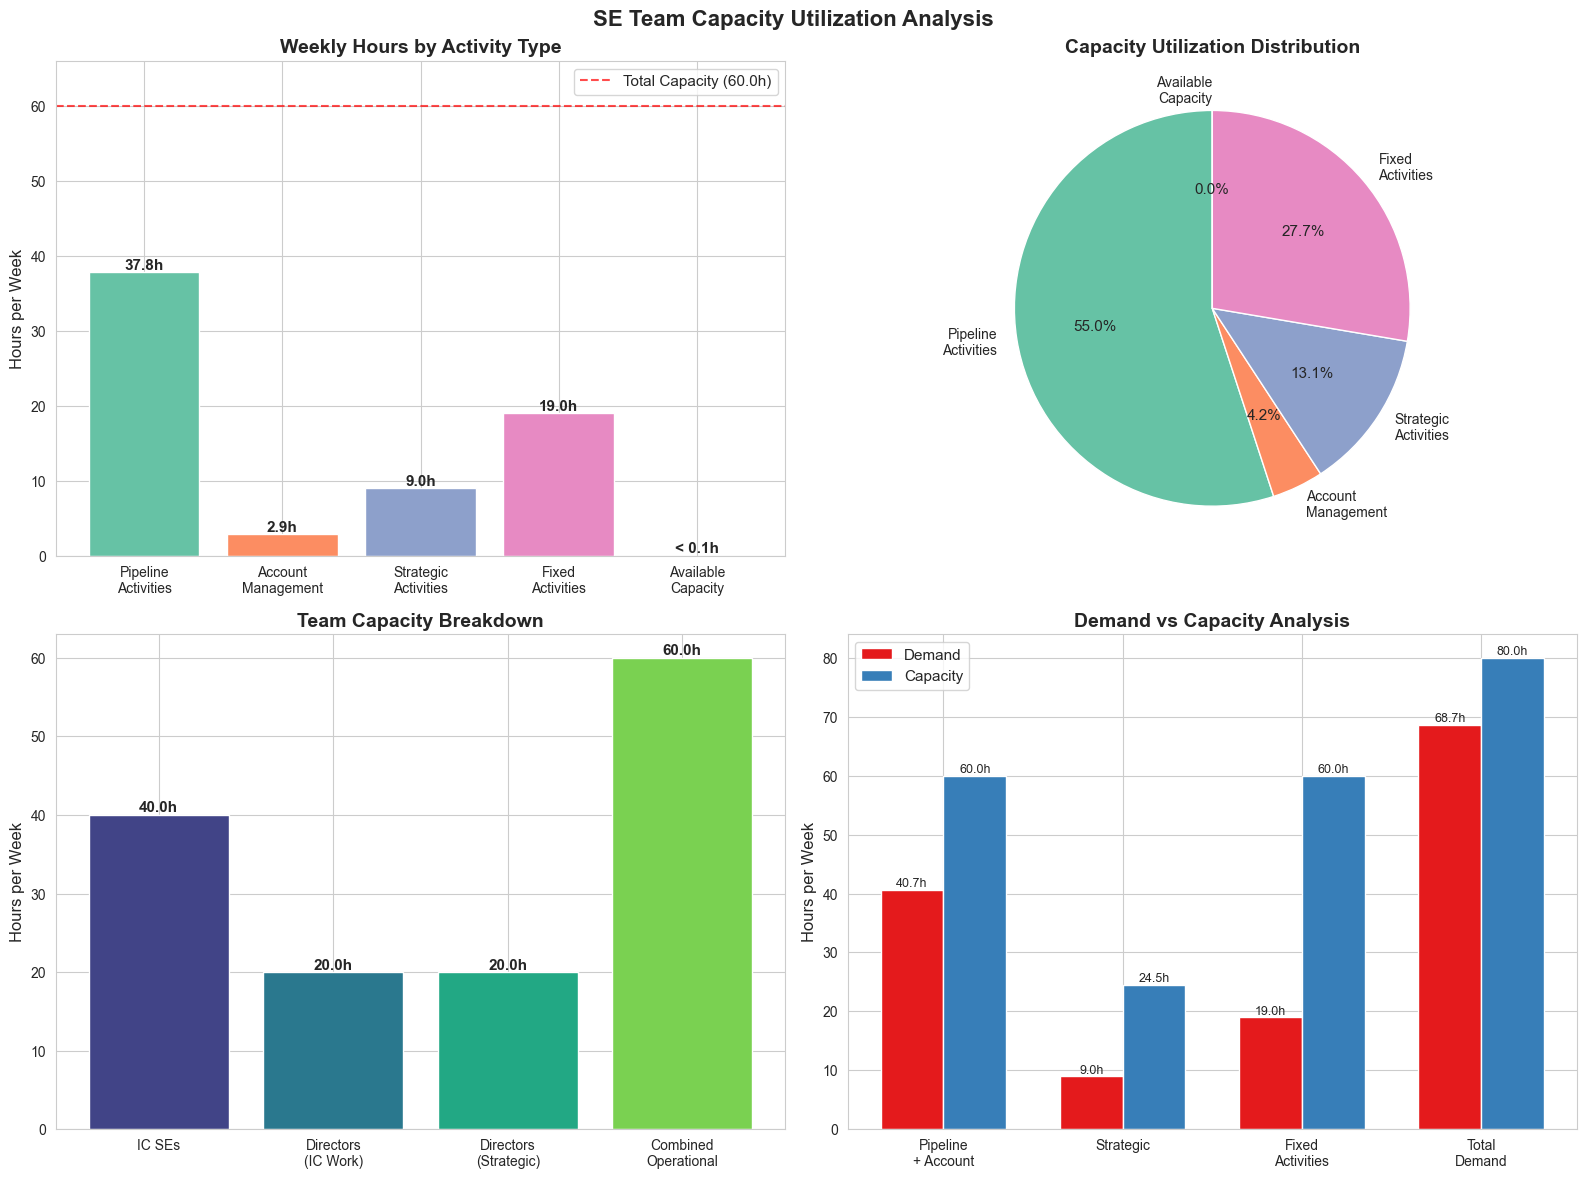


📈 Capacity Utilization Summary:
   • Total Team Capacity: 80.0h
   • Operational Capacity: 60.0h
   • Total Demand: 68.7h
   • Utilization Rate: 114.5%
   • Available Capacity: < 0.1h

2. Creating Pipeline Funnel Chart...

🔄 Creating Pipeline Funnel Chart


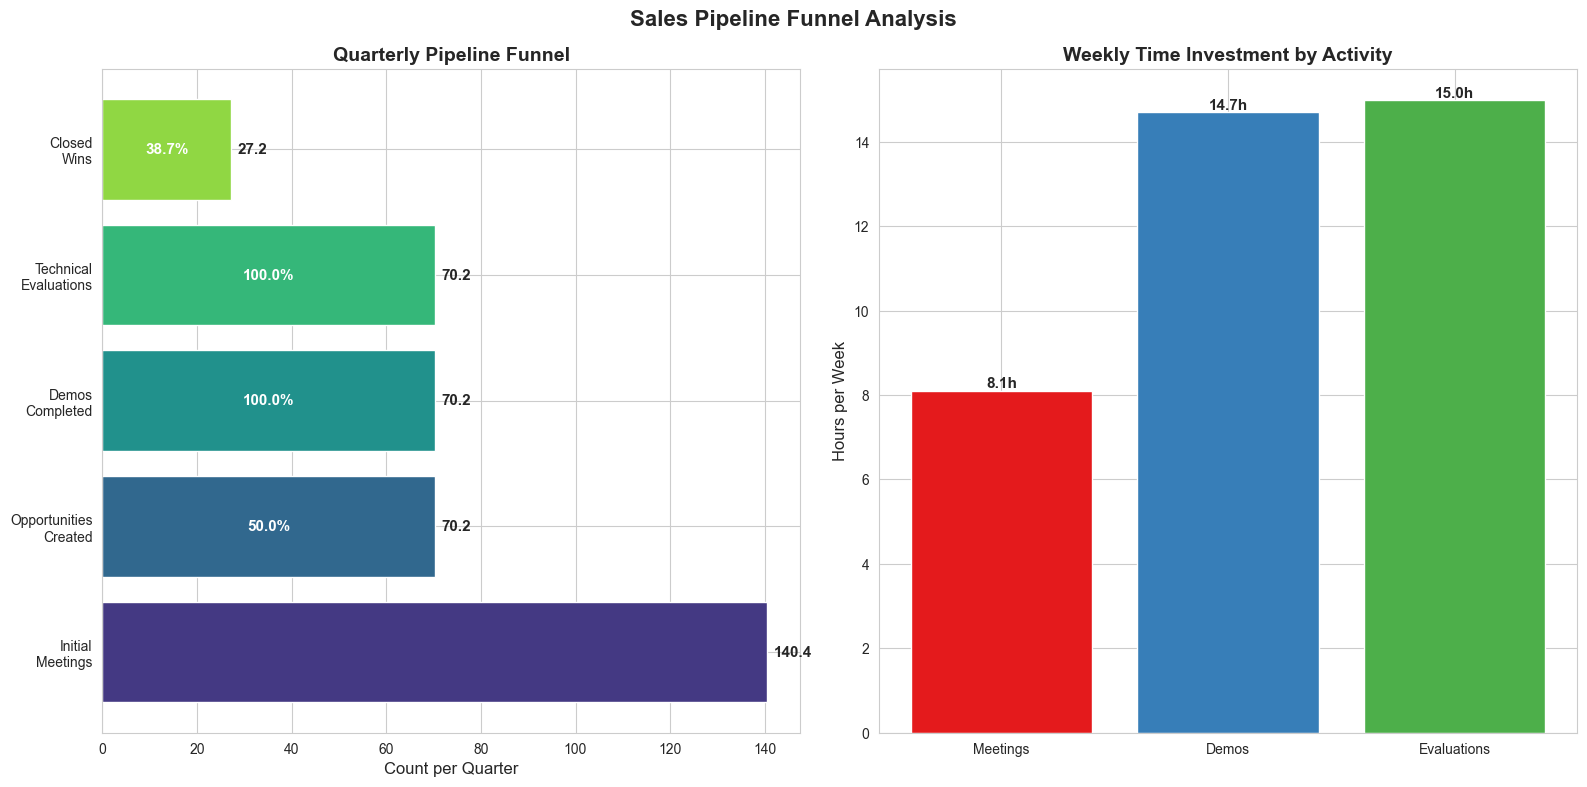


🎯 Pipeline Funnel Summary (Quarterly):
   • Initial Meetings: 140.4
   • Opportunities: 70.2 (50.0% conversion)
   • Demos: 70.2 (100.0% conversion)
   • Evaluations: 70.2 (100.0% conversion)
   • Wins: 27.2 (38.7% conversion)
   • Revenue: $2.0M
   • Overall Conversion: 19.4% (meetings to wins)

3. Creating Account Management Chart...

👥 Creating Account Management Chart


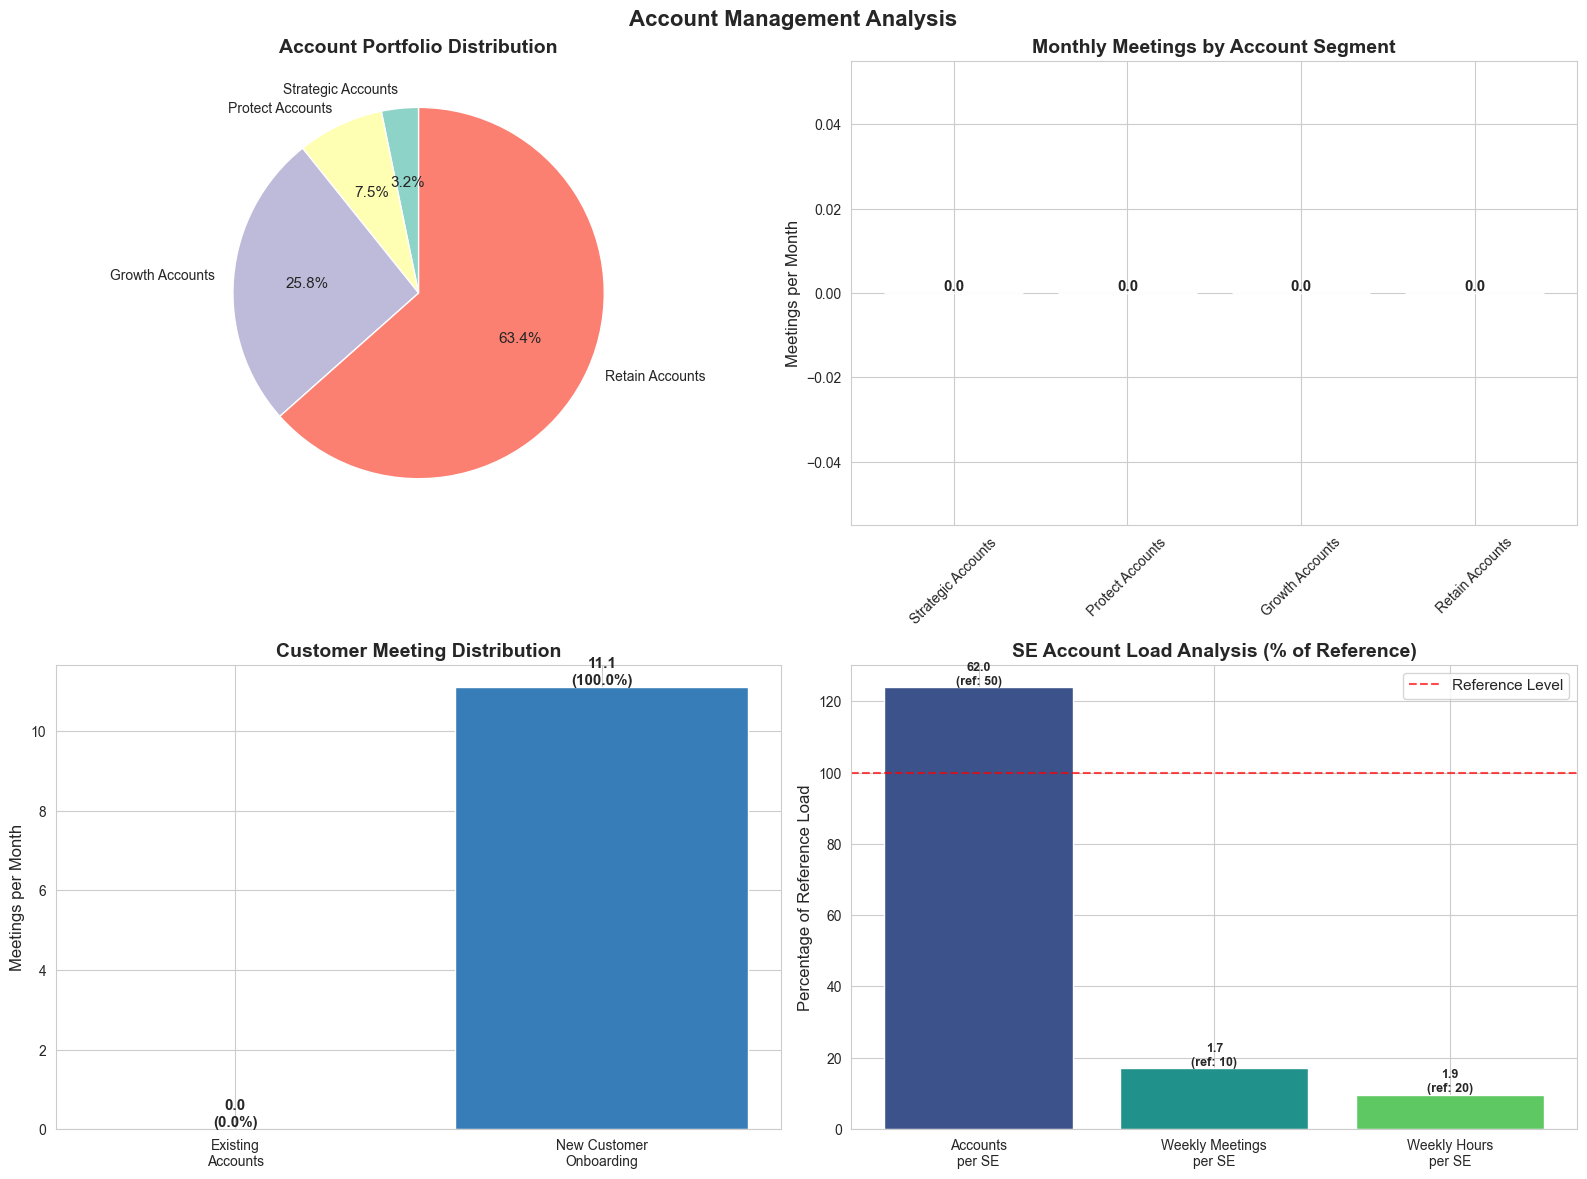


📊 Account Management Summary:
   • Total Accounts: 93
   • Monthly Meetings: 11.1
   • Weekly Hours: 2.9h
   • Load per SE: 62.0 accounts, 1.9h/week

4. Creating Strategic Activities Chart...

🎯 Creating Strategic Activities Chart


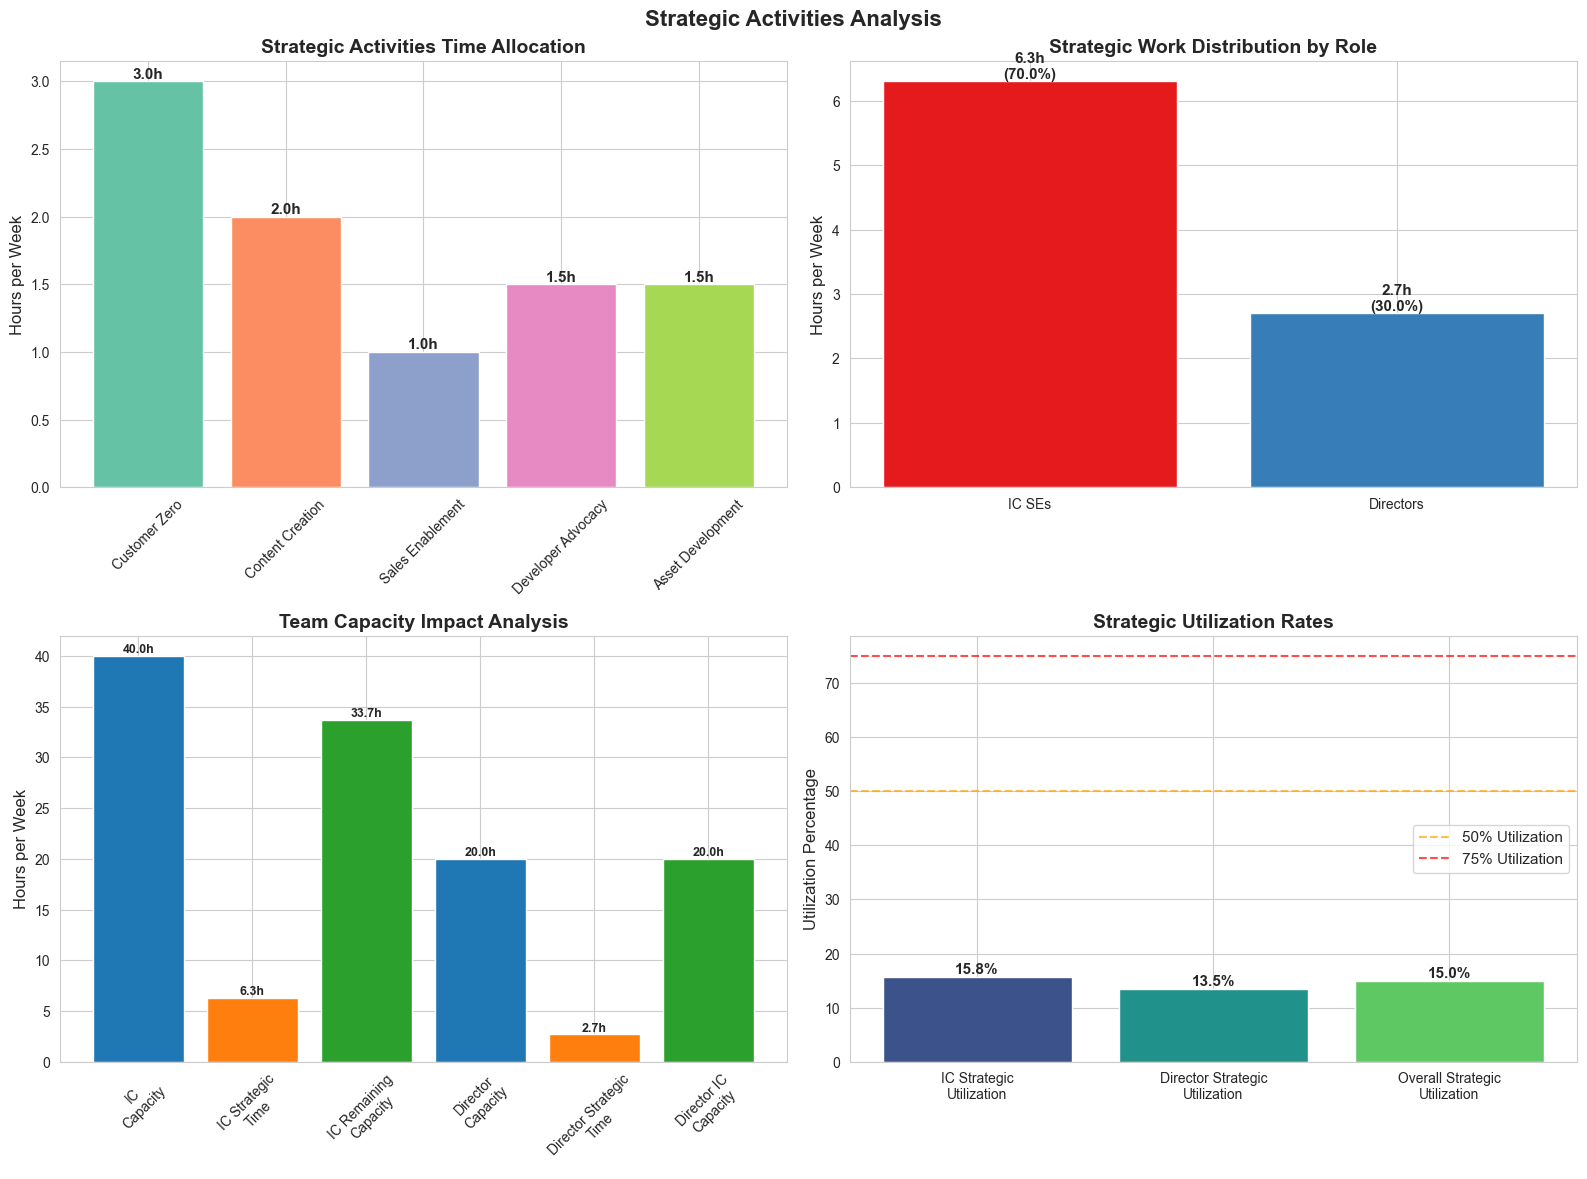


🎯 Strategic Activities Summary:
   • Total Strategic Hours: 9.0h
   • IC Strategic Hours: 6.3h
   • Director Strategic Hours: 2.7h
   • IC Utilization: 15.8%
   • Director Utilization: 13.5%

5. Creating Comprehensive Summary Chart...

📊 Creating Comprehensive Summary Chart


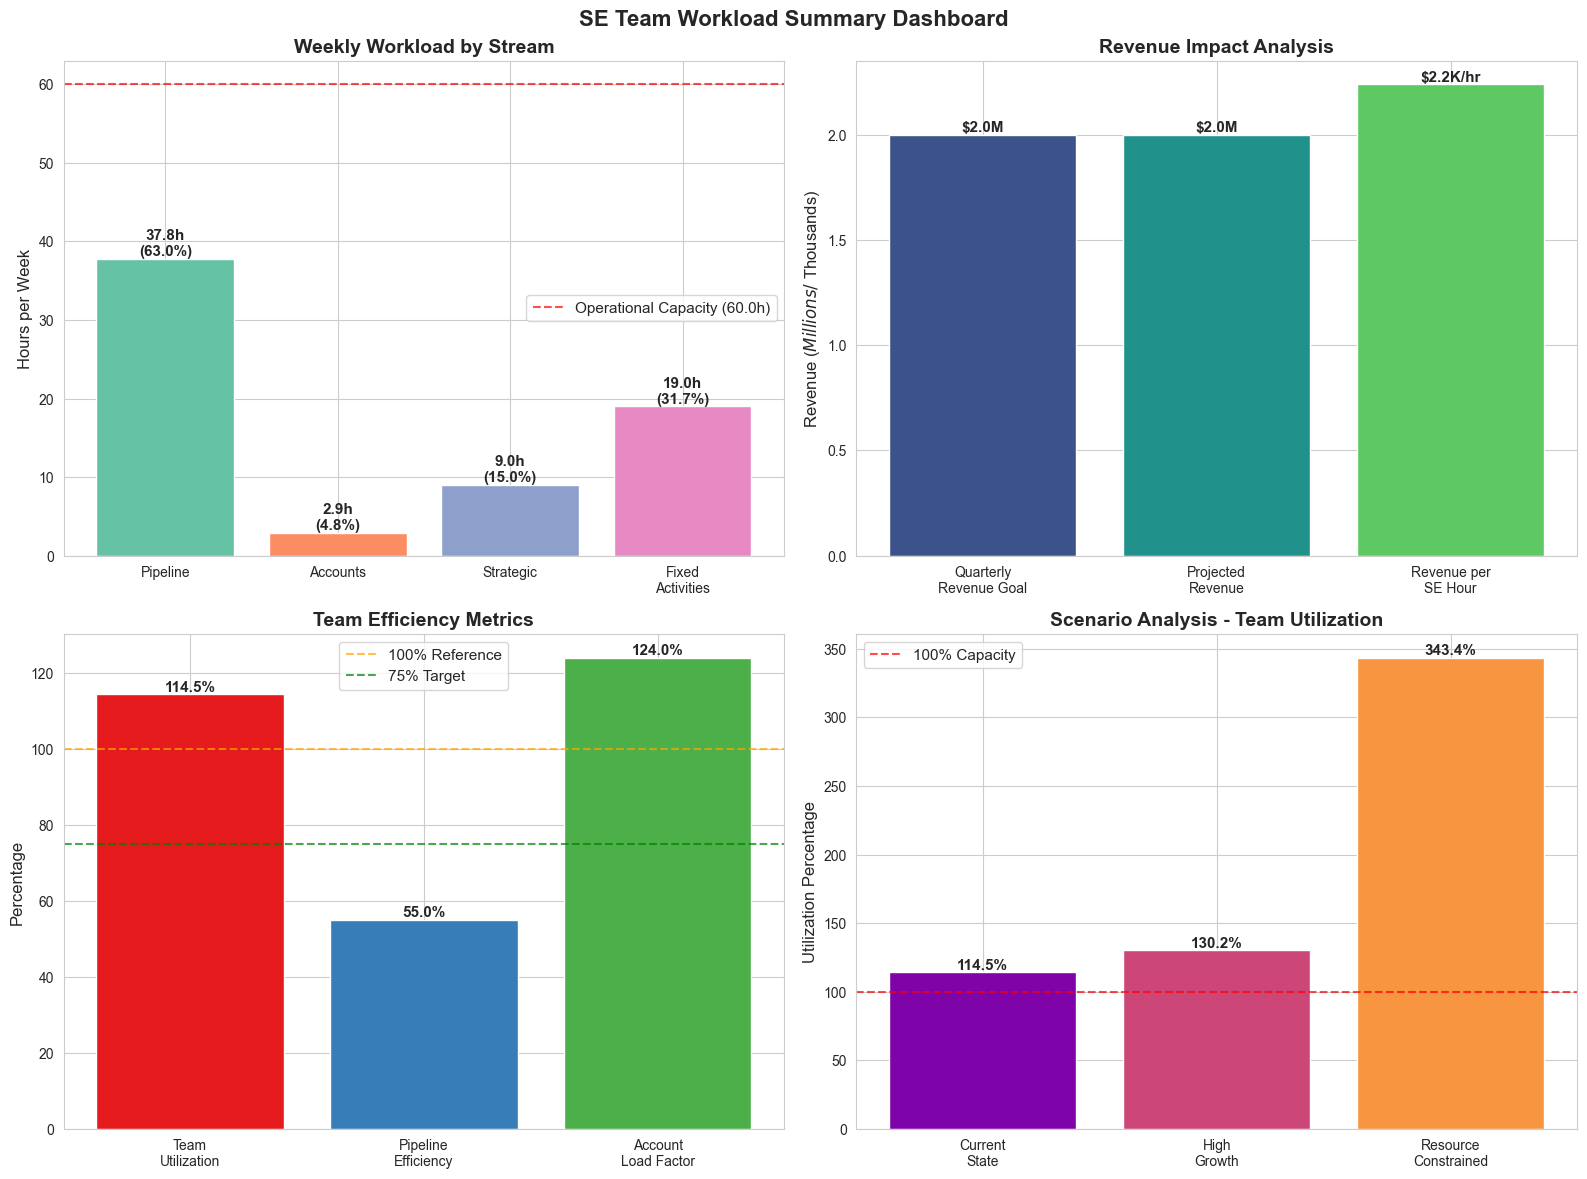


📈 Comprehensive Workload Summary:
   • Total Weekly Demand: 68.7h
   • Operational Capacity: 60.0h
   • Team Utilization: 114.5%
   • Available Capacity: < 0.1h
   • Revenue Target: $2.0M/quarter
   • Revenue per Hour: $2K/hour

✅ All core visualizations created successfully!
📊 5 comprehensive charts generated

🎉 Core Visualizations (Step 7) completed successfully!
📝 Ready for Step 8: Advanced Dashboard


In [38]:
# Core Visualizations Engine
# Essential charts for utilization analysis and capacity planning

# ===================================
# VISUALIZATION HELPER FUNCTIONS
# ===================================

def setup_chart_style():
    """Configure consistent styling for all charts."""
    plt.style.use('default')
    sns.set_style("whitegrid")
    sns.set_palette("Set2")
    
    # Set consistent figure parameters
    plt.rcParams.update({
        'figure.figsize': (12, 8),
        'font.size': 11,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 11,
        'figure.facecolor': 'white',
        'axes.facecolor': 'white'
    })

def format_currency(value):
    """Format currency values for display."""
    if value >= 1000000:
        return f"${value/1000000:.1f}M"
    elif value >= 1000:
        return f"${value/1000:.0f}K"
    else:
        return f"${value:.0f}"

def format_hours(hours):
    """Format hours for display with appropriate precision."""
    if hours < 0.1:
        return "< 0.1h"
    elif hours < 1:
        return f"{hours:.1f}h"
    else:
        return f"{hours:.1f}h"

# ===================================
# CORE VISUALIZATION FUNCTIONS
# ===================================

def create_capacity_utilization_chart():
    """Create a comprehensive capacity utilization chart."""
    
    print("📊 Creating Capacity Utilization Chart")
    print("=" * 40)
    
    # Gather data from previous calculations
    if 'PIPELINE_RESULTS' not in globals():
        print("❌ Pipeline results not available. Please run pipeline calculations first.")
        return None
    
    if 'ACCOUNT_RESULTS' not in globals():
        print("❌ Account results not available. Please run account management calculations first.")
        return None
        
    if 'STRATEGIC_RESULTS' not in globals():
        print("❌ Strategic results not available. Please run strategic activities calculations first.")
        return None
    
    # Extract data
    pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    fixed_hours = sum(fixed_activity_params.values())
    
    # Calculate team capacity
    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    director_ic_percentage = staffing_params['director_ic_percentage']
    
    # Total capacity calculation
    total_ic_capacity = total_ics * 40
    total_director_capacity = total_directors * 40
    director_ic_capacity = total_directors * 40 * (director_ic_percentage / 100)
    director_strategic_capacity = total_directors * 40 * ((100 - director_ic_percentage) / 100)
    
    total_capacity = total_ic_capacity + total_director_capacity
    total_operational_capacity = total_ic_capacity + director_ic_capacity
    
    # Create figure with subplots
    setup_chart_style()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('SE Team Capacity Utilization Analysis', fontsize=16, fontweight='bold')
    
    # Chart 1: Overall Utilization Breakdown
    activities = ['Pipeline\nActivities', 'Account\nManagement', 'Strategic\nActivities', 'Fixed\nActivities', 'Available\nCapacity']
    hours = [pipeline_hours, account_hours, strategic_hours, fixed_hours, 
             max(0, total_operational_capacity - (pipeline_hours + account_hours + strategic_hours + fixed_hours))]
    
    colors = sns.color_palette("Set2", len(activities))
    bars1 = ax1.bar(activities, hours, color=colors)
    ax1.set_title('Weekly Hours by Activity Type', fontweight='bold')
    ax1.set_ylabel('Hours per Week')
    ax1.set_ylim(0, max(total_operational_capacity * 1.1, max(hours) * 1.1))
    
    # Add capacity line
    ax1.axhline(y=total_operational_capacity, color='red', linestyle='--', alpha=0.7, 
                label=f'Total Capacity ({total_operational_capacity:.1f}h)')
    ax1.legend()
    
    # Add value labels on bars
    for bar, hour in zip(bars1, hours):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(hour)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Utilization Percentages
    total_used = pipeline_hours + account_hours + strategic_hours + fixed_hours
    utilization_pcts = [h/total_operational_capacity*100 for h in hours[:-1]]  # Exclude available capacity
    utilization_pcts.append(max(0, (total_operational_capacity - total_used)/total_operational_capacity*100))
    
    wedges, texts, autotexts = ax2.pie(hours, labels=activities, autopct='%1.1f%%', 
                                       colors=colors, startangle=90)
    ax2.set_title('Capacity Utilization Distribution', fontweight='bold')
    
    # Chart 3: Individual vs Team Capacity
    roles = ['IC SEs', 'Directors\n(IC Work)', 'Directors\n(Strategic)', 'Combined\nOperational']
    capacities = [total_ic_capacity, director_ic_capacity, director_strategic_capacity, total_operational_capacity]
    
    bars3 = ax3.bar(roles, capacities, color=sns.color_palette("viridis", len(roles)))
    ax3.set_title('Team Capacity Breakdown', fontweight='bold')
    ax3.set_ylabel('Hours per Week')
    
    # Add value labels
    for bar, capacity in zip(bars3, capacities):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(capacity)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 4: Capacity vs Demand Comparison
    demand_categories = ['Pipeline\n+ Account', 'Strategic', 'Fixed\nActivities', 'Total\nDemand']
    operational_demand = pipeline_hours + account_hours
    demand_values = [operational_demand, strategic_hours, fixed_hours, total_used]
    capacity_values = [total_operational_capacity, director_strategic_capacity + (strategic_hours * total_ics / (total_ics + total_directors) if (total_ics + total_directors) > 0 else 0), total_operational_capacity, total_capacity]
    
    x_pos = np.arange(len(demand_categories))
    width = 0.35
    
    bars4a = ax4.bar(x_pos - width/2, demand_values, width, label='Demand', color=sns.color_palette("Set1")[0])
    bars4b = ax4.bar(x_pos + width/2, capacity_values, width, label='Capacity', color=sns.color_palette("Set1")[1])
    
    ax4.set_title('Demand vs Capacity Analysis', fontweight='bold')
    ax4.set_ylabel('Hours per Week')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(demand_categories)
    ax4.legend()
    
    # Add value labels
    for bar in bars4a:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(height)}',
                ha='center', va='bottom', fontsize=9)
    
    for bar in bars4b:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(height)}',
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📈 Capacity Utilization Summary:")
    print(f"   • Total Team Capacity: {format_hours(total_capacity)}")
    print(f"   • Operational Capacity: {format_hours(total_operational_capacity)}")
    print(f"   • Total Demand: {format_hours(total_used)}")
    print(f"   • Utilization Rate: {total_used/total_operational_capacity*100:.1f}%")
    print(f"   • Available Capacity: {format_hours(max(0, total_operational_capacity - total_used))}")
    
    return fig

def create_pipeline_funnel_chart():
    """Create a visual representation of the sales pipeline funnel."""
    
    print("\n🔄 Creating Pipeline Funnel Chart")
    print("=" * 38)
    
    if 'PIPELINE_RESULTS' not in globals():
        print("❌ Pipeline results not available. Please run pipeline calculations first.")
        return None
    
    # Extract pipeline data
    pipeline_data = PIPELINE_RESULTS['pipeline_summary']
    weekly_activities = pipeline_data['weekly_activities']
    
    # Calculate quarterly numbers for more impactful visualization
    quarters_per_year = 4
    weekly_to_quarterly = 13
    
    # Funnel stages (quarterly)
    meetings_quarterly = weekly_activities['initial_meetings'] * weekly_to_quarterly
    opportunities_quarterly = meetings_quarterly * (conversion_params['opportunity_creation_rate'] / 100)
    demos_quarterly = opportunities_quarterly * (conversion_params['demo_conversion_rate'] / 100)
    evaluations_quarterly = demos_quarterly * (conversion_params['tech_eval_conversion_rate'] / 100)
    wins_quarterly = evaluations_quarterly * pipeline_data['weighted_win_rate']
    
    # Revenue calculation
    revenue_quarterly = wins_quarterly * revenue_params['average_selling_price']
    
    setup_chart_style()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Sales Pipeline Funnel Analysis', fontsize=16, fontweight='bold')
    
    # Chart 1: Funnel Visualization
    stages = ['Initial\nMeetings', 'Opportunities\nCreated', 'Demos\nCompleted', 'Technical\nEvaluations', 'Closed\nWins']
    values = [meetings_quarterly, opportunities_quarterly, demos_quarterly, evaluations_quarterly, wins_quarterly]
    
    # Create funnel effect with different colors
    colors = sns.color_palette("viridis", len(stages))
    bars = ax1.barh(stages, values, color=colors)
    
    ax1.set_title('Quarterly Pipeline Funnel', fontweight='bold')
    ax1.set_xlabel('Count per Quarter')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, values)):
        width = bar.get_width()
        ax1.text(width + max(values) * 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}',
                ha='left', va='center', fontweight='bold')
        
        # Add conversion rates
        if i > 0:
            conversion_rate = (value / values[i-1]) * 100 if values[i-1] > 0 else 0
            ax1.text(width/2, bar.get_y() + bar.get_height()/2,
                    f'{conversion_rate:.1f}%',
                    ha='center', va='center', color='white', fontweight='bold')
    
    # Chart 2: Time Investment by Stage
    time_labels = ['Meetings', 'Demos', 'Evaluations']
    time_values = [
        PIPELINE_RESULTS['pipeline_summary']['meeting_hours'],
        PIPELINE_RESULTS['pipeline_summary']['demo_hours'],
        sum(PIPELINE_RESULTS['pipeline_summary']['evaluation_hours'].values())
    ]
    
    # Create stacked bar for time investment
    colors_time = sns.color_palette("Set1", len(time_labels))
    bars2 = ax2.bar(time_labels, time_values, color=colors_time)
    
    ax2.set_title('Weekly Time Investment by Activity', fontweight='bold')
    ax2.set_ylabel('Hours per Week')
    
    # Add value labels
    for bar, value in zip(bars2, time_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(value)}',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print funnel summary
    print(f"\n🎯 Pipeline Funnel Summary (Quarterly):")
    print(f"   • Initial Meetings: {meetings_quarterly:.1f}")
    print(f"   • Opportunities: {opportunities_quarterly:.1f} ({opportunities_quarterly/meetings_quarterly*100:.1f}% conversion)")
    print(f"   • Demos: {demos_quarterly:.1f} ({demos_quarterly/opportunities_quarterly*100:.1f}% conversion)")
    print(f"   • Evaluations: {evaluations_quarterly:.1f} ({evaluations_quarterly/demos_quarterly*100:.1f}% conversion)")
    print(f"   • Wins: {wins_quarterly:.1f} ({wins_quarterly/evaluations_quarterly*100:.1f}% conversion)")
    print(f"   • Revenue: {format_currency(revenue_quarterly)}")
    print(f"   • Overall Conversion: {wins_quarterly/meetings_quarterly*100:.1f}% (meetings to wins)")
    
    return fig

def create_account_management_chart():
    """Create visualizations for account management workload."""
    
    print("\n👥 Creating Account Management Chart")
    print("=" * 40)
    
    if 'ACCOUNT_RESULTS' not in globals():
        print("❌ Account results not available. Please run account management calculations first.")
        return None
    
    account_data = ACCOUNT_RESULTS['account_summary']
    
    setup_chart_style()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Account Management Analysis', fontsize=16, fontweight='bold')
    
    # Chart 1: Account Portfolio Distribution
    segments = list(account_data['account_distribution'].keys())
    segment_counts = list(account_data['account_distribution'].values())
    segment_labels = [seg.replace('_', ' ').title() for seg in segments]
    
    colors1 = sns.color_palette("Set3", len(segments))
    wedges, texts, autotexts = ax1.pie(segment_counts, labels=segment_labels, autopct='%1.1f%%',
                                       colors=colors1, startangle=90)
    ax1.set_title('Account Portfolio Distribution', fontweight='bold')
    
    # Chart 2: Monthly Meetings by Segment
    meeting_counts = [account_data['monthly_meetings_by_segment'].get(seg, 0) for seg in segments]
    
    bars2 = ax2.bar(segment_labels, meeting_counts, color=colors1)
    ax2.set_title('Monthly Meetings by Account Segment', fontweight='bold')
    ax2.set_ylabel('Meetings per Month')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, count in zip(bars2, meeting_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:.1f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 3: Existing vs New Customer Time
    customer_types = ['Existing\nAccounts', 'New Customer\nOnboarding']
    existing_meetings = sum(account_data['monthly_meetings_by_segment'].values())
    onboarding_meetings = sum(account_data['onboarding_meetings'].values())
    customer_meetings = [existing_meetings, onboarding_meetings]
    
    colors3 = sns.color_palette("Set1", 2)
    bars3 = ax3.bar(customer_types, customer_meetings, color=colors3)
    ax3.set_title('Customer Meeting Distribution', fontweight='bold')
    ax3.set_ylabel('Meetings per Month')
    
    # Add value labels and percentages
    total_meetings = existing_meetings + onboarding_meetings
    for bar, count in zip(bars3, customer_meetings):
        height = bar.get_height()
        percentage = (count / total_meetings * 100) if total_meetings > 0 else 0
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:.1f}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 4: Account Load per SE
    distribution_data = ACCOUNT_RESULTS['distribution_analysis']
    
    load_metrics = ['Accounts\nper SE', 'Weekly Meetings\nper SE', 'Weekly Hours\nper SE']
    load_values = [
        distribution_data['accounts_per_se'],
        distribution_data['meetings_per_se_weekly'],
        distribution_data['hours_per_se_weekly']
    ]
    
    # Normalize values for comparison (different scales)
    normalized_values = []
    reference_values = [50, 10, 20]  # Reference points for scaling
    
    for value, ref in zip(load_values, reference_values):
        normalized_values.append((value / ref) * 100)
    
    colors4 = sns.color_palette("viridis", len(load_metrics))
    bars4 = ax4.bar(load_metrics, normalized_values, color=colors4)
    ax4.set_title('SE Account Load Analysis (% of Reference)', fontweight='bold')
    ax4.set_ylabel('Percentage of Reference Load')
    ax4.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Reference Level')
    ax4.legend()
    
    # Add actual value labels
    for bar, actual_value, ref_value in zip(bars4, load_values, reference_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{actual_value:.1f}\n(ref: {ref_value})',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print account management summary
    print(f"\n📊 Account Management Summary:")
    print(f"   • Total Accounts: {account_data['total_accounts']}")
    print(f"   • Monthly Meetings: {account_data['total_monthly_meetings']:.1f}")
    print(f"   • Weekly Hours: {format_hours(account_data['weekly_account_hours'])}")
    print(f"   • Load per SE: {distribution_data['accounts_per_se']:.1f} accounts, {format_hours(distribution_data['hours_per_se_weekly'])}/week")
    
    return fig

def create_strategic_activities_chart():
    """Create visualizations for strategic activities allocation."""
    
    print("\n🎯 Creating Strategic Activities Chart")
    print("=" * 42)
    
    if 'STRATEGIC_RESULTS' not in globals():
        print("❌ Strategic results not available. Please run strategic activities calculations first.")
        return None
    
    strategic_data = STRATEGIC_RESULTS['strategic_summary']
    capacity_data = STRATEGIC_RESULTS['capacity_impact']
    
    setup_chart_style()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Strategic Activities Analysis', fontsize=16, fontweight='bold')
    
    # Chart 1: Strategic Activity Hours Breakdown
    activities = []
    activity_hours = []
    
    for activity, allocation in strategic_data['activity_allocation'].items():
        activities.append(activity.replace('_', ' ').title())
        activity_hours.append(allocation['total_hours'])
    
    colors1 = sns.color_palette("Set2", len(activities))
    bars1 = ax1.bar(activities, activity_hours, color=colors1)
    ax1.set_title('Strategic Activities Time Allocation', fontweight='bold')
    ax1.set_ylabel('Hours per Week')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, hours in zip(bars1, activity_hours):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(hours)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: IC vs Director Strategic Work Distribution
    roles = ['IC SEs', 'Directors']
    role_hours = [
        strategic_data['strategic_distribution']['total_ic_strategic_hours'],
        strategic_data['strategic_distribution']['total_director_strategic_hours']
    ]
    
    colors2 = sns.color_palette("Set1", 2)
    bars2 = ax2.bar(roles, role_hours, color=colors2)
    ax2.set_title('Strategic Work Distribution by Role', fontweight='bold')
    ax2.set_ylabel('Hours per Week')
    
    # Add value and percentage labels
    total_strategic = sum(role_hours)
    for bar, hours in zip(bars2, role_hours):
        height = bar.get_height()
        percentage = (hours / total_strategic * 100) if total_strategic > 0 else 0
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(hours)}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 3: Capacity Impact Analysis
    capacity_categories = ['IC\nCapacity', 'IC Strategic\nTime', 'IC Remaining\nCapacity', 
                          'Director\nCapacity', 'Director Strategic\nTime', 'Director IC\nCapacity']
    
    ic_total = capacity_data['total_capacities']['total_ic_capacity']
    ic_strategic = capacity_data['strategic_allocation']['ic_strategic_hours']
    ic_remaining = capacity_data['remaining_pipeline_capacity']['remaining_ic_capacity']
    
    director_total = capacity_data['total_capacities']['total_director_strategic_capacity']
    director_strategic = capacity_data['strategic_allocation']['director_strategic_hours']
    director_ic = capacity_data['total_capacities']['total_director_ic_capacity']
    
    capacity_values = [ic_total, ic_strategic, ic_remaining, director_total, director_strategic, director_ic]
    
    # Create grouped bar chart
    x_pos = np.arange(len(capacity_categories))
    colors3 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#1f77b4', '#ff7f0e', '#2ca02c']
    bars3 = ax3.bar(x_pos, capacity_values, color=colors3)
    
    ax3.set_title('Team Capacity Impact Analysis', fontweight='bold')
    ax3.set_ylabel('Hours per Week')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(capacity_categories, rotation=45)
    
    # Add value labels
    for bar, value in zip(bars3, capacity_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(value)}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Chart 4: Strategic Utilization Rates
    utilization_types = ['IC Strategic\nUtilization', 'Director Strategic\nUtilization', 'Overall Strategic\nUtilization']
    utilization_rates = [
        capacity_data['utilization_rates']['ic_strategic_utilization'],
        capacity_data['utilization_rates']['director_strategic_utilization'],
        capacity_data['utilization_rates']['overall_strategic_utilization']
    ]
    
    colors4 = sns.color_palette("viridis", len(utilization_types))
    bars4 = ax4.bar(utilization_types, utilization_rates, color=colors4)
    ax4.set_title('Strategic Utilization Rates', fontweight='bold')
    ax4.set_ylabel('Utilization Percentage')
    ax4.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50% Utilization')
    ax4.axhline(y=75, color='red', linestyle='--', alpha=0.7, label='75% Utilization')
    ax4.legend()
    
    # Add value labels
    for bar, rate in zip(bars4, utilization_rates):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print strategic activities summary
    print(f"\n🎯 Strategic Activities Summary:")
    print(f"   • Total Strategic Hours: {format_hours(strategic_data['avg_strategic_hours'])}")
    print(f"   • IC Strategic Hours: {format_hours(strategic_data['strategic_distribution']['total_ic_strategic_hours'])}")
    print(f"   • Director Strategic Hours: {format_hours(strategic_data['strategic_distribution']['total_director_strategic_hours'])}")
    print(f"   • IC Utilization: {capacity_data['utilization_rates']['ic_strategic_utilization']:.1f}%")
    print(f"   • Director Utilization: {capacity_data['utilization_rates']['director_strategic_utilization']:.1f}%")
    
    return fig

def create_comprehensive_summary_chart():
    """Create a comprehensive summary visualization combining all workstreams."""
    
    print("\n📊 Creating Comprehensive Summary Chart")
    print("=" * 45)
    
    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None
    
    setup_chart_style()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('SE Team Workload Summary Dashboard', fontsize=16, fontweight='bold')
    
    # Gather all data
    pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    fixed_hours = sum(fixed_activity_params.values())
    
    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    total_capacity = (total_ics + total_directors) * 40
    operational_capacity = total_ics * 40 + total_directors * 40 * (staffing_params['director_ic_percentage'] / 100)
    
    # Chart 1: Overall Workload Summary
    workstreams = ['Pipeline', 'Accounts', 'Strategic', 'Fixed\nActivities']
    workstream_hours = [pipeline_hours, account_hours, strategic_hours, fixed_hours]
    total_demand = sum(workstream_hours)
    
    colors1 = sns.color_palette("Set2", len(workstreams))
    bars1 = ax1.bar(workstreams, workstream_hours, color=colors1)
    ax1.set_title('Weekly Workload by Stream', fontweight='bold')
    ax1.set_ylabel('Hours per Week')
    
    # Add capacity line and utilization info
    ax1.axhline(y=operational_capacity, color='red', linestyle='--', alpha=0.7,
                label=f'Operational Capacity ({operational_capacity:.1f}h)')
    ax1.legend()
    
    # Add value labels
    for bar, hours in zip(bars1, workstream_hours):
        height = bar.get_height()
        percentage = (hours / operational_capacity * 100) if operational_capacity > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{format_hours(hours)}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Revenue Impact Analysis
    revenue_quarterly = PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] * revenue_params['average_selling_price']
    revenue_metrics = ['Quarterly\nRevenue Goal', 'Projected\nRevenue', 'Revenue per\nSE Hour']
    
    revenue_per_hour = revenue_quarterly / (13 * total_demand) if total_demand > 0 else 0
    revenue_values = [revenue_params['quarterly_revenue_goal'] / 1000000,  # Convert to millions
                     revenue_quarterly / 1000000,
                     revenue_per_hour / 1000]  # Convert to thousands
    
    colors2 = sns.color_palette("viridis", len(revenue_metrics))
    bars2 = ax2.bar(revenue_metrics, revenue_values, color=colors2)
    ax2.set_title('Revenue Impact Analysis', fontweight='bold')
    ax2.set_ylabel('Revenue ($ Millions / $ Thousands)')
    
    # Add value labels
    labels = [f'${revenue_params["quarterly_revenue_goal"]/1000000:.1f}M',
             f'${revenue_quarterly/1000000:.1f}M',
             f'${revenue_per_hour/1000:.1f}K/hr']
    
    for bar, label in zip(bars2, labels):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 3: Team Efficiency Metrics
    efficiency_metrics = ['Team\nUtilization', 'Pipeline\nEfficiency', 'Account\nLoad Factor']
    
    team_utilization = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0
    pipeline_efficiency = (pipeline_hours / total_demand * 100) if total_demand > 0 else 0
    account_load_factor = (ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se'] / 50 * 100)  # Reference: 50 accounts
    
    efficiency_values = [team_utilization, pipeline_efficiency, account_load_factor]
    
    colors3 = sns.color_palette("Set1", len(efficiency_metrics))
    bars3 = ax3.bar(efficiency_metrics, efficiency_values, color=colors3)
    ax3.set_title('Team Efficiency Metrics', fontweight='bold')
    ax3.set_ylabel('Percentage')
    
    # Add reference lines
    ax3.axhline(y=100, color='orange', linestyle='--', alpha=0.7, label='100% Reference')
    ax3.axhline(y=75, color='green', linestyle='--', alpha=0.7, label='75% Target')
    ax3.legend()
    
    # Add value labels
    for bar, value in zip(bars3, efficiency_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    
    # Chart 4: Scenario Analysis
    scenarios = ['Current\nState', 'High\nGrowth', 'Resource\nConstrained']
    
    # Current state
    current_total = total_demand
    
    # High growth scenario (25% more pipeline)
    high_growth_total = total_demand + (pipeline_hours * 0.25)
    
    # Resource constrained (1 fewer IC)
    constrained_capacity = operational_capacity - 40
    constrained_utilization = (total_demand / constrained_capacity * 100) if constrained_capacity > 0 else 100
    
    scenario_values = [
        team_utilization,
        (high_growth_total / operational_capacity * 100) if operational_capacity > 0 else 100,
        constrained_utilization
    ]
    
    colors4 = sns.color_palette("plasma", len(scenarios))
    bars4 = ax4.bar(scenarios, scenario_values, color=colors4)
    ax4.set_title('Scenario Analysis - Team Utilization', fontweight='bold')
    ax4.set_ylabel('Utilization Percentage')
    
    # Add capacity warning line
    ax4.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% Capacity')
    ax4.legend()
    
    # Add value labels
    for bar, value in zip(bars4, scenario_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print(f"\n📈 Comprehensive Workload Summary:")
    print(f"   • Total Weekly Demand: {format_hours(total_demand)}")
    print(f"   • Operational Capacity: {format_hours(operational_capacity)}")
    print(f"   • Team Utilization: {team_utilization:.1f}%")
    print(f"   • Available Capacity: {format_hours(max(0, operational_capacity - total_demand))}")
    print(f"   • Revenue Target: {format_currency(revenue_params['quarterly_revenue_goal'])}/quarter")
    print(f"   • Revenue per Hour: {format_currency(revenue_per_hour)}/hour")
    
    return fig

# ===================================
# MAIN VISUALIZATION EXECUTION
# ===================================

def run_all_core_visualizations():
    """Execute all core visualization functions in sequence."""
    
    print("🎨 Running All Core Visualizations")
    print("=" * 50)
    
    # Check if all required data is available
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    missing_data = [var for var in required_globals if var not in globals()]
    
    if missing_data:
        print(f"❌ Missing required data: {', '.join(missing_data)}")
        print("📝 Please run all business logic calculations first (Steps 3-5)")
        return False
    
    visualization_results = {}
    
    try:
        # Create each visualization
        print("\n1. Creating Capacity Utilization Chart...")
        fig1 = create_capacity_utilization_chart()
        visualization_results['capacity_chart'] = fig1
        
        print("\n2. Creating Pipeline Funnel Chart...")
        fig2 = create_pipeline_funnel_chart()
        visualization_results['pipeline_chart'] = fig2
        
        print("\n3. Creating Account Management Chart...")
        fig3 = create_account_management_chart()
        visualization_results['account_chart'] = fig3
        
        print("\n4. Creating Strategic Activities Chart...")
        fig4 = create_strategic_activities_chart()
        visualization_results['strategic_chart'] = fig4
        
        print("\n5. Creating Comprehensive Summary Chart...")
        fig5 = create_comprehensive_summary_chart()
        visualization_results['summary_chart'] = fig5
        
        print("\n✅ All core visualizations created successfully!")
        print("📊 5 comprehensive charts generated")
        
        return visualization_results
        
    except Exception as e:
        print(f"\n❌ Error creating visualizations: {str(e)}")
        return False

# Check if we have all the required data and run visualizations
if all(var in globals() for var in ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']):
    # Run all visualizations
    VISUALIZATION_RESULTS = run_all_core_visualizations()
    
    if VISUALIZATION_RESULTS:
        print("\n🎉 Core Visualizations (Step 7) completed successfully!")
        print("📝 Ready for Step 8: Advanced Dashboard")
    else:
        print("\n❌ Some visualizations failed to generate")
else:
    print("📊 Core visualizations framework ready")
    print("⚠️  Business logic calculations must be completed first")
    print("📝 Run cells 8-14 to generate required data, then re-run this cell")

---

# 9. Executive Dashboard {#executive-dashboard}

*Professional dashboard with comprehensive business insights*

🎨 Running All Advanced Dashboards

1. Creating Executive Summary Dashboard...
📊 Creating Executive Summary Dashboard


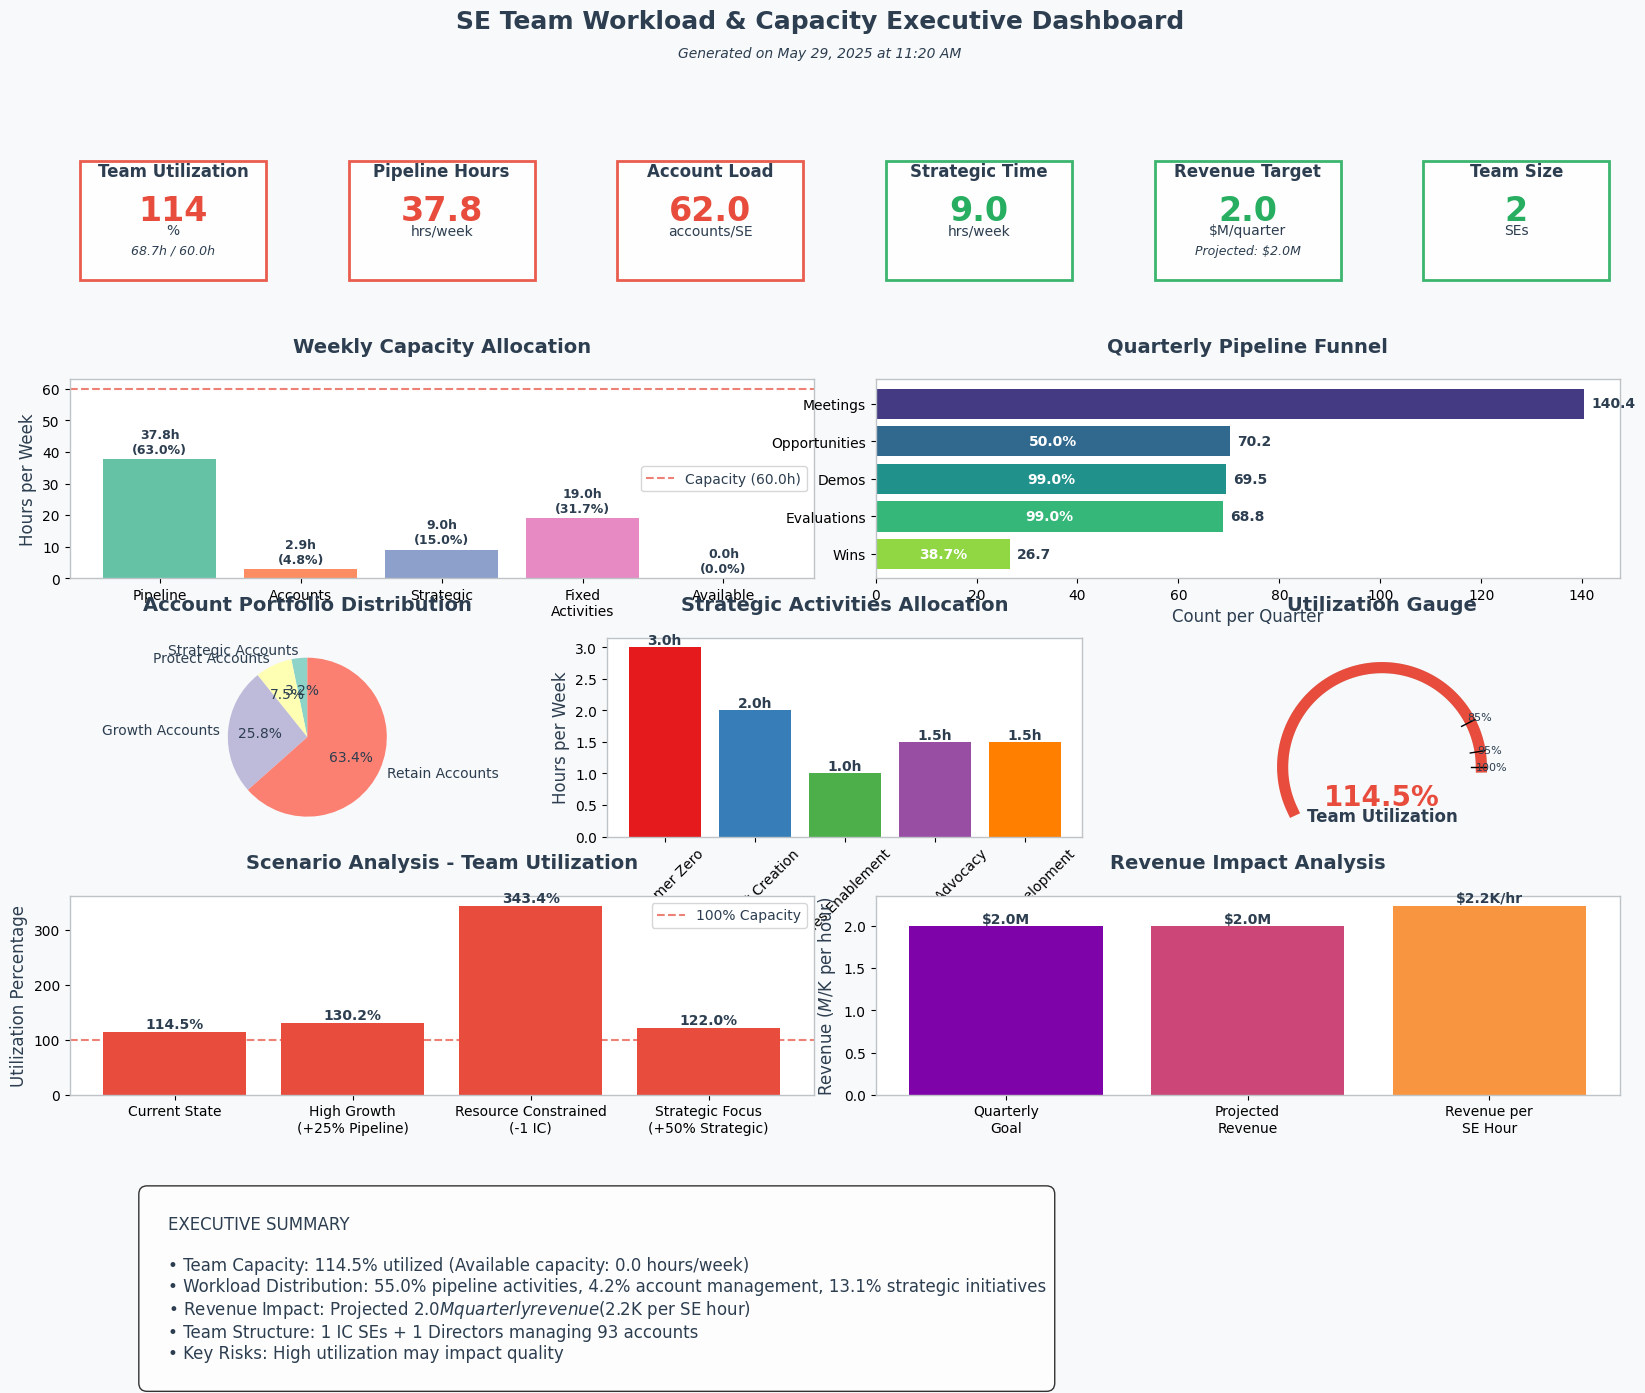


📈 Executive Dashboard Summary:
   • Team Utilization: 114.5%
   • Total Weekly Demand: 68.7 hours
   • Available Capacity: 0.0 hours
   • Revenue Target: $2.0M/quarter
   • Revenue per Hour: $2.2K/hour

2. Creating Detailed Analysis Dashboard...

🔍 Creating Detailed Analysis Dashboard

❌ Error creating advanced dashboards: name 'utilization_rate' is not defined

❌ Some dashboards failed to generate


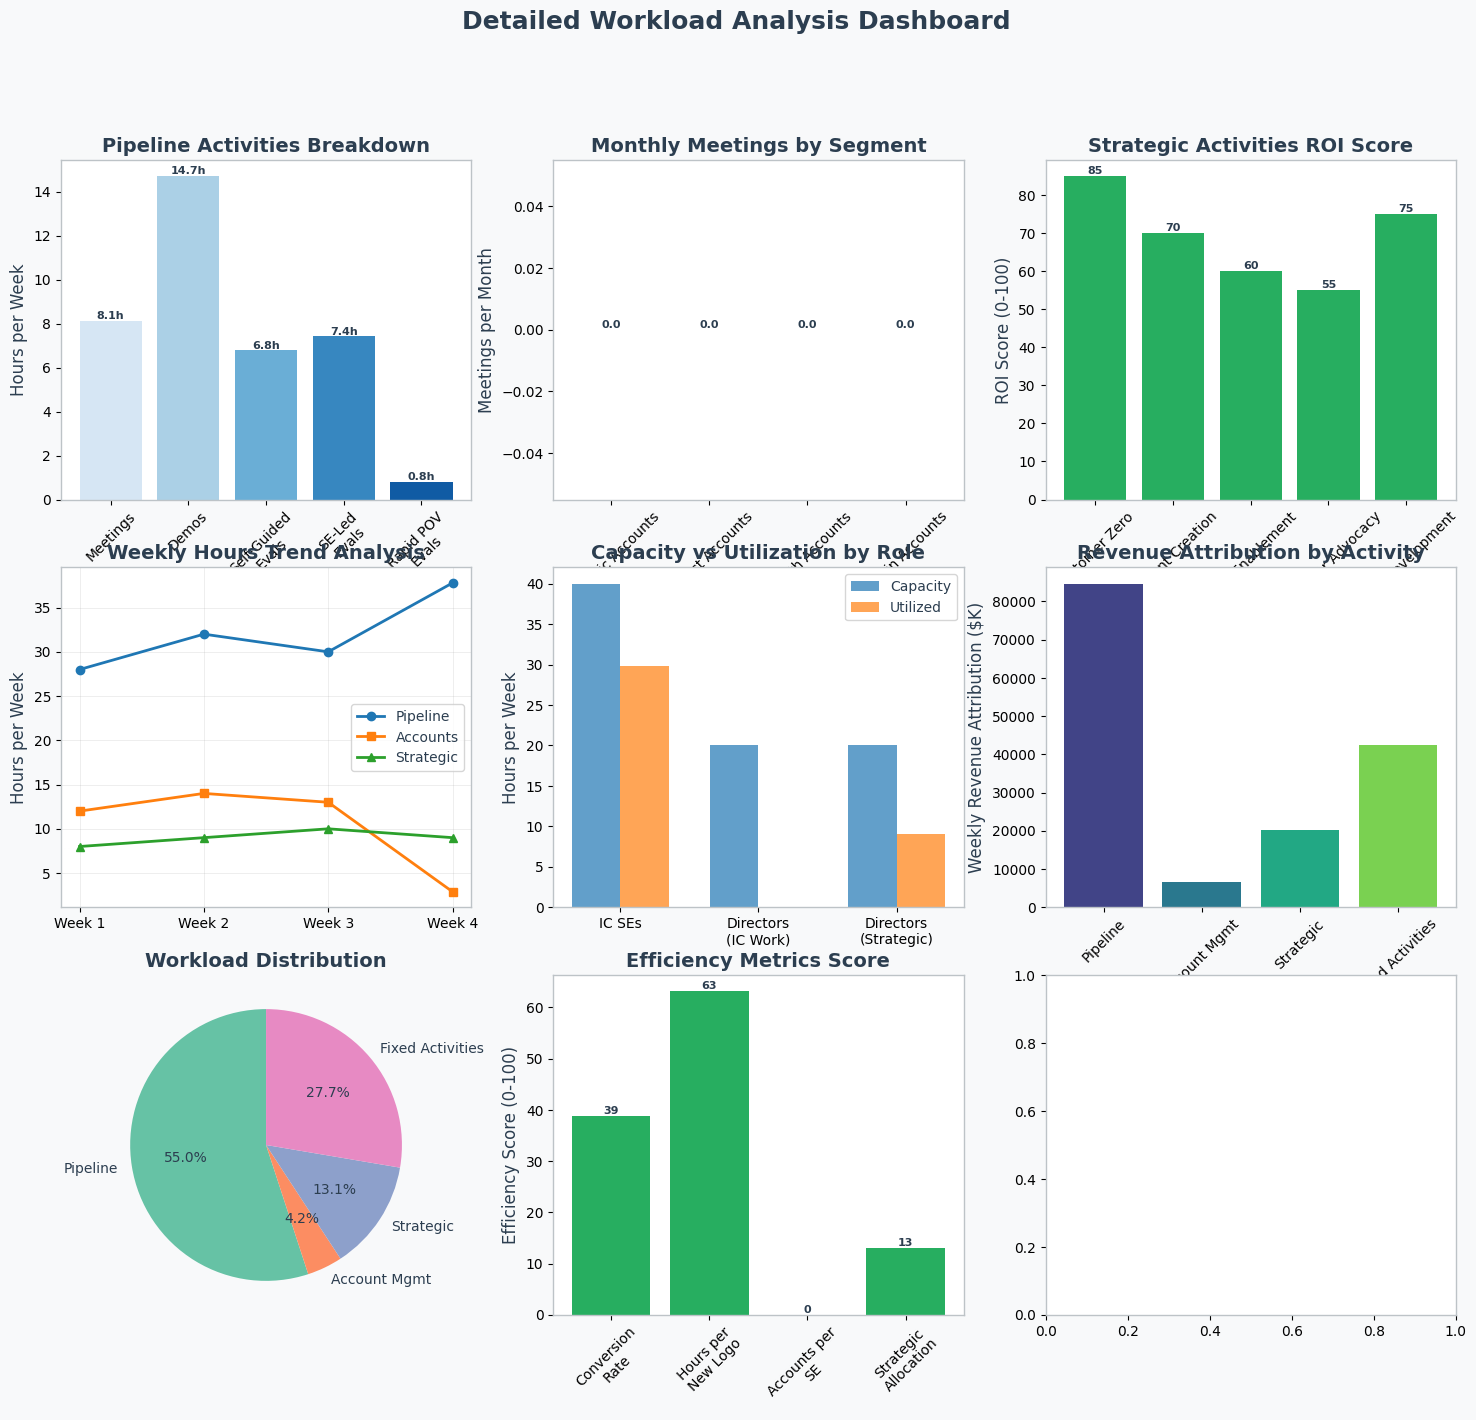

In [39]:
# Advanced Dashboard Engine
# Professional executive dashboard with comprehensive business insights

import io
import base64
from datetime import datetime
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# ===================================
# DASHBOARD CONFIGURATION
# ===================================

# Dashboard styling configuration
DASHBOARD_CONFIG = {
    'figure_size': (20, 16),
    'title_fontsize': 18,
    'subtitle_fontsize': 14,
    'label_fontsize': 12,
    'text_fontsize': 10,
    'color_palette': 'Set2',
    'background_color': '#f8f9fa',
    'text_color': '#2c3e50',
    'accent_color': '#3498db',
    'warning_color': '#f39c12',
    'danger_color': '#e74c3c',
    'success_color': '#27ae60'
}

# KPI thresholds for color coding
KPI_THRESHOLDS = {
    'utilization': {'good': 85, 'warning': 95, 'danger': 100},
    'pipeline_hours': {'good': 25, 'warning': 35, 'danger': 45},
    'account_load': {'good': 30, 'warning': 45, 'danger': 60},
    'strategic_time': {'good': 15, 'warning': 10, 'danger': 5}
}

# ===================================
# ADVANCED DASHBOARD FUNCTIONS
# ===================================

def setup_dashboard_style():
    """Configure enhanced styling for dashboard charts."""
    plt.style.use('default')

    # Set comprehensive styling
    plt.rcParams.update({
        'figure.figsize': DASHBOARD_CONFIG['figure_size'],
        'figure.facecolor': DASHBOARD_CONFIG['background_color'],
        'axes.facecolor': 'white',
        'axes.edgecolor': '#bdc3c7',
        'axes.linewidth': 1,
        'axes.labelcolor': DASHBOARD_CONFIG['text_color'],
        'axes.titlesize': DASHBOARD_CONFIG['subtitle_fontsize'],
        'axes.labelsize': DASHBOARD_CONFIG['label_fontsize'],
        'xtick.labelsize': DASHBOARD_CONFIG['text_fontsize'],
        'ytick.labelsize': DASHBOARD_CONFIG['text_fontsize'],
        'legend.fontsize': DASHBOARD_CONFIG['text_fontsize'],
        'font.size': DASHBOARD_CONFIG['text_fontsize'],
        'text.color': DASHBOARD_CONFIG['text_color'],
        'grid.alpha': 0.3,
        'grid.linewidth': 0.5
    })

def get_kpi_color(value, metric_type):
    """Get color for KPI based on value and thresholds."""
    thresholds = KPI_THRESHOLDS.get(metric_type, {'good': 70, 'warning': 85, 'danger': 100})

    if value <= thresholds['good']:
        return DASHBOARD_CONFIG['success_color']
    elif value <= thresholds['warning']:
        return DASHBOARD_CONFIG['warning_color']
    else:
        return DASHBOARD_CONFIG['danger_color']

def create_kpi_card(ax, title, value, unit, metric_type, subtitle=None):
    """Create a KPI card visualization."""
    ax.clear()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Get color based on value
    color = get_kpi_color(value, metric_type)

    # Background rectangle
    rect = patches.Rectangle((0.5, 2), 9, 6, linewidth=2,
                           edgecolor=color, facecolor='white', alpha=0.9)
    ax.add_patch(rect)

    # Title
    ax.text(5, 7.5, title, ha='center', va='center',
           fontsize=DASHBOARD_CONFIG['label_fontsize'],
           fontweight='bold', color=DASHBOARD_CONFIG['text_color'])

    # Value
    if isinstance(value, float):
        if value >= 1000:
            display_value = f"{value/1000:.1f}K"
        elif value >= 100:
            display_value = f"{value:.0f}"
        else:
            display_value = f"{value:.1f}"
    else:
        display_value = str(value)

    ax.text(5, 5.5, display_value, ha='center', va='center',
           fontsize=24, fontweight='bold', color=color)

    # Unit
    ax.text(5, 4.5, unit, ha='center', va='center',
           fontsize=DASHBOARD_CONFIG['text_fontsize'], color=DASHBOARD_CONFIG['text_color'])

    # Subtitle
    if subtitle:
        ax.text(5, 3.5, subtitle, ha='center', va='center',
               fontsize=DASHBOARD_CONFIG['text_fontsize']-1,
               style='italic', color=DASHBOARD_CONFIG['text_color'])

def create_executive_summary_dashboard():
    """Create comprehensive executive summary dashboard."""

    print("📊 Creating Executive Summary Dashboard")
    print("=" * 45)

    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None

    setup_dashboard_style()

    # Create main figure with complex grid layout
    fig = plt.figure(figsize=DASHBOARD_CONFIG['figure_size'])
    gs = GridSpec(5, 6, figure=fig, hspace=0.3, wspace=0.3)

    # Main title
    fig.suptitle('SE Team Workload & Capacity Executive Dashboard',
                fontsize=DASHBOARD_CONFIG['title_fontsize'],
                fontweight='bold', color=DASHBOARD_CONFIG['text_color'], y=0.95)

    # Subtitle with timestamp
    timestamp = datetime.now().strftime("%B %d, %Y at %I:%M %p")
    fig.text(0.5, 0.92, f'Generated on {timestamp}',
            ha='center', fontsize=DASHBOARD_CONFIG['text_fontsize'],
            style='italic', color=DASHBOARD_CONFIG['text_color'])

    # Gather key metrics
    pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    fixed_hours = sum(fixed_activity_params.values())

    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    operational_capacity = total_ics * 40 + total_directors * 40 * (staffing_params['director_ic_percentage'] / 100)

    total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
    utilization_rate = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0

    revenue_quarterly = PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] * revenue_params['average_selling_price']

    # Row 1: Key Performance Indicators (KPI Cards)
    kpi_axes = [fig.add_subplot(gs[0, i]) for i in range(6)]

    kpis = [
        ("Team Utilization", utilization_rate, "%", "utilization"),
        ("Pipeline Hours", pipeline_hours, "hrs/week", "pipeline_hours"),
        ("Account Load", ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se'], "accounts/SE", "account_load"),
        ("Strategic Time", strategic_hours, "hrs/week", "strategic_time"),
        ("Revenue Target", revenue_params['quarterly_revenue_goal']/1000000, "$M/quarter", "revenue"),
        ("Team Size", total_ics + total_directors, "SEs", "team_size")
    ]

    for ax, (title, value, unit, metric_type) in zip(kpi_axes, kpis):
        subtitle = None
        if title == "Team Utilization":
            subtitle = f"{total_demand:.1f}h / {operational_capacity:.1f}h"
        elif title == "Revenue Target":
            subtitle = f"Projected: ${revenue_quarterly/1000000:.1f}M"

        create_kpi_card(ax, title, value, unit, metric_type, subtitle)

    # Row 2: Capacity Breakdown Chart
    ax_capacity = fig.add_subplot(gs[1, :3])
    workstreams = ['Pipeline', 'Accounts', 'Strategic', 'Fixed\nActivities', 'Available']
    workstream_hours = [pipeline_hours, account_hours, strategic_hours, fixed_hours,
                       max(0, operational_capacity - total_demand)]

    colors = sns.color_palette(DASHBOARD_CONFIG['color_palette'], len(workstreams))
    bars = ax_capacity.bar(workstreams, workstream_hours, color=colors)

    ax_capacity.set_title('Weekly Capacity Allocation', fontweight='bold', pad=20)
    ax_capacity.set_ylabel('Hours per Week')
    ax_capacity.axhline(y=operational_capacity, color=DASHBOARD_CONFIG['danger_color'],
                       linestyle='--', alpha=0.7, label=f'Capacity ({operational_capacity:.1f}h)')
    ax_capacity.legend()

    # Add value labels on bars
    for bar, hours in zip(bars, workstream_hours):
        height = bar.get_height()
        percentage = (hours / operational_capacity * 100) if operational_capacity > 0 else 0
        ax_capacity.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{hours:.1f}h\n({percentage:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Row 2: Pipeline Funnel Chart
    ax_funnel = fig.add_subplot(gs[1, 3:])

    # Calculate quarterly funnel data
    weekly_activities = PIPELINE_RESULTS['pipeline_summary']['weekly_activities']
    funnel_data = {
        'Meetings': weekly_activities['initial_meetings'] * 13,
        'Opportunities': weekly_activities['initial_meetings'] * 13 * (conversion_params['opportunity_creation_rate'] / 100),
        'Demos': weekly_activities['demos'] * 13,
        'Evaluations': weekly_activities['total_evaluations'] * 13,
        'Wins': PIPELINE_RESULTS['pipeline_summary']['new_logos_needed']
    }

    stages = list(funnel_data.keys())
    values = list(funnel_data.values())

    # Create horizontal funnel
    y_positions = range(len(stages))
    colors_funnel = sns.color_palette("viridis", len(stages))
    bars_funnel = ax_funnel.barh(y_positions, values, color=colors_funnel)

    ax_funnel.set_title('Quarterly Pipeline Funnel', fontweight='bold', pad=20)
    ax_funnel.set_xlabel('Count per Quarter')
    ax_funnel.set_yticks(y_positions)
    ax_funnel.set_yticklabels(stages)
    ax_funnel.invert_yaxis()

    # Add conversion rates and values
    for i, (bar, value) in enumerate(zip(bars_funnel, values)):
        width = bar.get_width()
        ax_funnel.text(width + max(values) * 0.01, bar.get_y() + bar.get_height()/2,
                      f'{value:.1f}',
                      ha='left', va='center', fontweight='bold')

        if i > 0:
            conversion_rate = (value / values[i-1]) * 100 if values[i-1] > 0 else 0
            ax_funnel.text(width/2, bar.get_y() + bar.get_height()/2,
                          f'{conversion_rate:.1f}%',
                          ha='center', va='center', color='white', fontweight='bold')

    # Row 3: Account Portfolio Analysis
    ax_accounts = fig.add_subplot(gs[2, :2])

    account_data = ACCOUNT_RESULTS['account_summary']['account_distribution']
    segments = list(account_data.keys())
    segment_counts = list(account_data.values())
    segment_labels = [seg.replace('_', ' ').title() for seg in segments]

    colors_accounts = sns.color_palette("Set3", len(segments))
    wedges, texts, autotexts = ax_accounts.pie(segment_counts, labels=segment_labels,
                                              autopct='%1.1f%%', colors=colors_accounts,
                                              startangle=90)
    ax_accounts.set_title('Account Portfolio Distribution', fontweight='bold', pad=20)

    # Row 3: Strategic Activities Breakdown
    ax_strategic = fig.add_subplot(gs[2, 2:4])

    strategic_data = STRATEGIC_RESULTS['strategic_summary']['activity_allocation']
    activities = []
    activity_hours = []

    for activity, allocation in strategic_data.items():
        activities.append(activity.replace('_', ' ').title())
        activity_hours.append(allocation['total_hours'])

    colors_strategic = sns.color_palette("Set1", len(activities))
    bars_strategic = ax_strategic.bar(activities, activity_hours, color=colors_strategic)

    ax_strategic.set_title('Strategic Activities Allocation', fontweight='bold', pad=20)
    ax_strategic.set_ylabel('Hours per Week')
    ax_strategic.tick_params(axis='x', rotation=45)

    # Add value labels
    for bar, hours in zip(bars_strategic, activity_hours):
        height = bar.get_height()
        ax_strategic.text(bar.get_x() + bar.get_width()/2., height,
                         f'{hours:.1f}h',
                         ha='center', va='bottom', fontweight='bold')

    # Row 3: Utilization Gauge
    ax_gauge = fig.add_subplot(gs[2, 4:])

    # Create utilization gauge
    theta = np.linspace(0, np.pi, 100)
    r = 1

    # Background arc
    ax_gauge.plot(r * np.cos(theta), r * np.sin(theta), 'lightgray', linewidth=8)

    # Utilization arc
    utilization_theta = theta * (utilization_rate / 100)
    gauge_color = get_kpi_color(utilization_rate, 'utilization')
    ax_gauge.plot(r * np.cos(utilization_theta), r * np.sin(utilization_theta),
                 gauge_color, linewidth=8)

    # Add gauge labels
    ax_gauge.text(0, -0.3, f'{utilization_rate:.1f}%', ha='center', va='center',
                 fontsize=20, fontweight='bold', color=gauge_color)
    ax_gauge.text(0, -0.5, 'Team Utilization', ha='center', va='center',
                 fontsize=12, fontweight='bold')

    # Threshold markers
    for threshold, label in [(85, '85%'), (95, '95%'), (100, '100%')]:
        angle = np.pi * (threshold / 100)
        x, y = r * 1.1 * np.cos(np.pi - angle), r * 1.1 * np.sin(np.pi - angle)
        ax_gauge.text(x, y, label, ha='center', va='center', fontsize=8)

        # Threshold line
        x_line, y_line = r * 0.9 * np.cos(np.pi - angle), r * 0.9 * np.sin(np.pi - angle)
        x_line2, y_line2 = r * 1.05 * np.cos(np.pi - angle), r * 1.05 * np.sin(np.pi - angle)
        ax_gauge.plot([x_line, x_line2], [y_line, y_line2], 'black', linewidth=1)

    ax_gauge.set_xlim(-1.3, 1.3)
    ax_gauge.set_ylim(-0.7, 1.3)
    ax_gauge.set_aspect('equal')
    ax_gauge.axis('off')
    ax_gauge.set_title('Utilization Gauge', fontweight='bold', pad=20)

    # Row 4: Scenario Analysis
    ax_scenarios = fig.add_subplot(gs[3, :3])

    # Define scenarios
    scenarios = {
        'Current State': utilization_rate,
        'High Growth\n(+25% Pipeline)': ((total_demand + pipeline_hours * 0.25) / operational_capacity * 100) if operational_capacity > 0 else 100,
        'Resource Constrained\n(-1 IC)': (total_demand / (operational_capacity - 40) * 100) if operational_capacity > 40 else 100,
        'Strategic Focus\n(+50% Strategic)': ((total_demand + strategic_hours * 0.5) / operational_capacity * 100) if operational_capacity > 0 else 100
    }

    scenario_names = list(scenarios.keys())
    scenario_values = list(scenarios.values())

    # Color code based on utilization thresholds
    scenario_colors = [get_kpi_color(value, 'utilization') for value in scenario_values]

    bars_scenarios = ax_scenarios.bar(scenario_names, scenario_values, color=scenario_colors)
    ax_scenarios.set_title('Scenario Analysis - Team Utilization', fontweight='bold', pad=20)
    ax_scenarios.set_ylabel('Utilization Percentage')
    ax_scenarios.axhline(y=100, color=DASHBOARD_CONFIG['danger_color'],
                        linestyle='--', alpha=0.7, label='100% Capacity')
    ax_scenarios.legend()

    # Add value labels
    for bar, value in zip(bars_scenarios, scenario_values):
        height = bar.get_height()
        ax_scenarios.text(bar.get_x() + bar.get_width()/2., height + 1,
                         f'{value:.1f}%',
                         ha='center', va='bottom', fontweight='bold')

    # Row 4: Revenue Impact Analysis
    ax_revenue = fig.add_subplot(gs[3, 3:])

    revenue_metrics = ['Quarterly\nGoal', 'Projected\nRevenue', 'Revenue per\nSE Hour']
    revenue_per_hour = revenue_quarterly / (13 * total_demand) if total_demand > 0 else 0
    revenue_values = [revenue_params['quarterly_revenue_goal'] / 1000000,
                     revenue_quarterly / 1000000,
                     revenue_per_hour / 1000]

    colors_revenue = sns.color_palette("plasma", len(revenue_metrics))
    bars_revenue = ax_revenue.bar(revenue_metrics, revenue_values, color=colors_revenue)

    ax_revenue.set_title('Revenue Impact Analysis', fontweight='bold', pad=20)
    ax_revenue.set_ylabel('Revenue ($M / $K per hour)')

    # Add value labels with proper formatting
    labels = [f'${revenue_params["quarterly_revenue_goal"]/1000000:.1f}M',
             f'${revenue_quarterly/1000000:.1f}M',
             f'${revenue_per_hour/1000:.1f}K/hr']

    for bar, label in zip(bars_revenue, labels):
        height = bar.get_height()
        ax_revenue.text(bar.get_x() + bar.get_width()/2., height,
                       label,
                       ha='center', va='bottom', fontweight='bold')

    # Row 5: Executive Summary Text
    ax_summary = fig.add_subplot(gs[4, :])
    ax_summary.axis('off')

    # Calculate key insights
    available_capacity = max(0, operational_capacity - total_demand)
    capacity_status = "Over capacity" if available_capacity < 0 else "Available capacity"

    pipeline_percentage = (pipeline_hours / total_demand * 100) if total_demand > 0 else 0
    account_percentage = (account_hours / total_demand * 100) if total_demand > 0 else 0

    # Create executive summary text
    summary_text = f"""
    EXECUTIVE SUMMARY

    • Team Capacity: {utilization_rate:.1f}% utilized ({capacity_status}: {abs(available_capacity):.1f} hours/week)
    • Workload Distribution: {pipeline_percentage:.1f}% pipeline activities, {account_percentage:.1f}% account management, {(strategic_hours/total_demand*100):.1f}% strategic initiatives
    • Revenue Impact: Projected ${revenue_quarterly/1000000:.1f}M quarterly revenue (${revenue_per_hour/1000:.1f}K per SE hour)
    • Team Structure: {total_ics} IC SEs + {total_directors} Directors managing {sum(account_data.values())} accounts
    • Key Risks: {"High utilization may impact quality" if utilization_rate > 90 else "Utilization within acceptable range"}
    """

    ax_summary.text(0.05, 0.8, summary_text, transform=ax_summary.transAxes,
                   fontsize=DASHBOARD_CONFIG['label_fontsize'],
                   verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print dashboard summary
    print(f"\n📈 Executive Dashboard Summary:")
    print(f"   • Team Utilization: {utilization_rate:.1f}%")
    print(f"   • Total Weekly Demand: {total_demand:.1f} hours")
    print(f"   • Available Capacity: {available_capacity:.1f} hours")
    print(f"   • Revenue Target: ${revenue_params['quarterly_revenue_goal']/1000000:.1f}M/quarter")
    print(f"   • Revenue per Hour: ${revenue_per_hour/1000:.1f}K/hour")

    return fig

def create_detailed_analysis_dashboard():
    """Create detailed analysis dashboard with drill-down capabilities."""

    print("\n🔍 Creating Detailed Analysis Dashboard")
    print("=" * 42)

    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None

    setup_dashboard_style()

    # Create figure with detailed analysis layout
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Detailed Workload Analysis Dashboard',
                fontsize=DASHBOARD_CONFIG['title_fontsize'],
                fontweight='bold', color=DASHBOARD_CONFIG['text_color'])

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # 1. Pipeline Activities Detail
    ax = axes[0]
    pipeline_data = PIPELINE_RESULTS['pipeline_summary']

    pipeline_activities = ['Meetings', 'Demos', 'Self-Guided\nEvals', 'SE-Led\nEvals', 'Rapid POV\nEvals']
    pipeline_hours = [
        pipeline_data['meeting_hours'],
        pipeline_data['demo_hours'],
        pipeline_data['evaluation_hours'].get('self_guided', 0),
        pipeline_data['evaluation_hours'].get('se_led', 0),
        pipeline_data['evaluation_hours'].get('rapid_pov', 0)
    ]

    colors1 = sns.color_palette("Blues", len(pipeline_activities))
    bars1 = ax.bar(pipeline_activities, pipeline_hours, color=colors1)
    ax.set_title('Pipeline Activities Breakdown', fontweight='bold')
    ax.set_ylabel('Hours per Week')
    ax.tick_params(axis='x', rotation=45)

    for bar, hours in zip(bars1, pipeline_hours):
        if hours > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{hours:.1f}h',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 2. Account Segmentation Analysis
    ax = axes[1]
    account_data = ACCOUNT_RESULTS['account_summary']

    segments = list(account_data['account_distribution'].keys())
    meeting_counts = [account_data['monthly_meetings_by_segment'].get(seg, 0) for seg in segments]
    segment_labels = [seg.replace('_', ' ').title() for seg in segments]

    colors2 = sns.color_palette("Greens", len(segments))
    bars2 = ax.bar(segment_labels, meeting_counts, color=colors2)
    ax.set_title('Monthly Meetings by Segment', fontweight='bold')
    ax.set_ylabel('Meetings per Month')
    ax.tick_params(axis='x', rotation=45)

    for bar, count in zip(bars2, meeting_counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{count:.1f}',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 3. Strategic Activities ROI Analysis
    ax = axes[2]
    strategic_data = STRATEGIC_RESULTS['strategic_summary']['activity_allocation']

    activities = []
    roi_scores = []  # Mock ROI scores for demonstration

    roi_mapping = {
        'customer_zero': 85,
        'content_creation': 70,
        'sales_enablement': 60,
        'developer_advocacy': 55,
        'asset_development': 75
    }

    for activity, allocation in strategic_data.items():
        activities.append(activity.replace('_', ' ').title())
        roi_scores.append(roi_mapping.get(activity, 50))

    colors3 = [get_kpi_color(score, 'utilization') for score in roi_scores]
    bars3 = ax.bar(activities, roi_scores, color=colors3)
    ax.set_title('Strategic Activities ROI Score', fontweight='bold')
    ax.set_ylabel('ROI Score (0-100)')
    ax.tick_params(axis='x', rotation=45)

    for bar, score in zip(bars3, roi_scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{score}',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 4. Time Allocation Trends
    ax = axes[3]

    # Mock trend data (could be historical if available)
    weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4']
    pipeline_trend = [28, 32, 30, PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']]
    account_trend = [12, 14, 13, ACCOUNT_RESULTS['account_summary']['weekly_account_hours']]
    strategic_trend = [8, 9, 10, STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']]

    ax.plot(weeks, pipeline_trend, marker='o', label='Pipeline', linewidth=2)
    ax.plot(weeks, account_trend, marker='s', label='Accounts', linewidth=2)
    ax.plot(weeks, strategic_trend, marker='^', label='Strategic', linewidth=2)

    ax.set_title('Weekly Hours Trend Analysis', fontweight='bold')
    ax.set_ylabel('Hours per Week')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 5. Capacity Utilization by Role
    ax = axes[4]

    roles = ['IC SEs', 'Directors\n(IC Work)', 'Directors\n(Strategic)']
    capacity_values = [
        staffing_params['num_ic_ses'] * 40,
        staffing_params['num_directors'] * 40 * (staffing_params['director_ic_percentage'] / 100),
        staffing_params['num_directors'] * 40 * ((100 - staffing_params['director_ic_percentage']) / 100)
    ]

    utilized_values = [
        (PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours'] +
         ACCOUNT_RESULTS['account_summary']['weekly_account_hours'] +
         sum(fixed_activity_params.values())) * (staffing_params['num_ic_ses'] / (staffing_params['num_ic_ses'] + staffing_params['num_directors'])),
        0,  # Directors doing IC work (simplified)
        STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    ]

    x_pos = np.arange(len(roles))
    width = 0.35

    bars4a = ax.bar(x_pos - width/2, capacity_values, width, label='Capacity', alpha=0.7)
    bars4b = ax.bar(x_pos + width/2, utilized_values, width, label='Utilized', alpha=0.7)

    ax.set_title('Capacity vs Utilization by Role', fontweight='bold')
    ax.set_ylabel('Hours per Week')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(roles)
    ax.legend()

    # 6. Revenue per Activity Analysis
    ax = axes[5]

    total_quarterly_revenue = PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] * revenue_params['average_selling_price']
    total_weekly_hours = (PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours'] +
                         ACCOUNT_RESULTS['account_summary']['weekly_account_hours'] +
                         STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours'] +
                         sum(fixed_activity_params.values()))

    revenue_per_hour = total_quarterly_revenue / (13 * total_weekly_hours) if total_weekly_hours > 0 else 0

    activity_types = ['Pipeline', 'Account Mgmt', 'Strategic', 'Fixed Activities']
    activity_hours = [
        PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours'],
        ACCOUNT_RESULTS['account_summary']['weekly_account_hours'],
        STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours'],
        sum(fixed_activity_params.values())
    ]

    # Calculate revenue attribution (simplified model)
    revenue_attribution = [
        revenue_per_hour * hours for hours in activity_hours
    ]

    colors6 = sns.color_palette("viridis", len(activity_types))
    bars6 = ax.bar(activity_types, revenue_attribution, color=colors6)
    ax.set_title('Revenue Attribution by Activity', fontweight='bold')
    ax.set_ylabel('Weekly Revenue Attribution ($K)')
    ax.tick_params(axis='x', rotation=45)

    # 7. Workload Distribution Pie Chart
    ax = axes[6]

    total_hours = sum(activity_hours)
    sizes = [(hours/total_hours)*100 for hours in activity_hours]

    colors7 = sns.color_palette("Set2", len(activity_types))
    wedges, texts, autotexts = ax.pie(sizes, labels=activity_types, autopct='%1.1f%%',
                                      colors=colors7, startangle=90)
    ax.set_title('Workload Distribution', fontweight='bold')

    # 8. Efficiency Metrics
    ax = axes[7]

    efficiency_metrics = ['Conversion\nRate', 'Hours per\nNew Logo', 'Accounts per\nSE', 'Strategic\nAllocation']

    # Calculate efficiency scores (normalized to 0-100)
    conversion_rate = PIPELINE_RESULTS['pipeline_summary']['weighted_win_rate'] * 100
    hours_per_logo = (PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours'] * 13) / PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] if PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] > 0 else 0
    accounts_per_se = ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se']
    strategic_allocation = (STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours'] / total_hours * 100) if total_hours > 0 else 0

    # Normalize to 0-100 scale for comparison
    efficiency_scores = [
        conversion_rate,
        max(0, 100 - (hours_per_logo / 50 * 100)),  # Lower hours per logo is better
        max(0, 100 - (accounts_per_se / 50 * 100)),  # Lower accounts per SE is better
        strategic_allocation
    ]

    colors8 = [get_kpi_color(score, 'utilization') for score in efficiency_scores]
    bars8 = ax.bar(efficiency_metrics, efficiency_scores, color=colors8)
    ax.set_title('Efficiency Metrics Score', fontweight='bold')
    ax.set_ylabel('Efficiency Score (0-100)')
    ax.tick_params(axis='x', rotation=45)

    for bar, score in zip(bars8, efficiency_scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{score:.0f}',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 9. Risk Assessment Matrix
    ax = axes[8]

    # Risk factors (mock data for demonstration)
    risk_factors = ['Capacity\nOverload', 'Pipeline\nBottleneck', 'Account\nChurn Risk', 'Strategic\nUnderinvest']

    total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
    utilization_rate = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0

    impact_scores = [utilization_rate, 75, 45, 100 - strategic_allocation]
    probability_scores = [85, 60, 30, 70]

    # Create scatter plot for risk matrix
    colors9 = ['red' if i*p > 6000 else 'orange' if i*p > 4000 else 'green'
              for i, p in zip(impact_scores, probability_scores)]

    scatter = ax.scatter(probability_scores, impact_scores, s=100, c=colors9, alpha=0.7)

    for i, factor in enumerate(risk_factors):
        ax.annotate(factor, (probability_scores[i], impact_scores[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax.set_title('Risk Assessment Matrix', fontweight='bold')
    ax.set_xlabel('Probability Score')
    ax.set_ylabel('Impact Score')
    ax.grid(True, alpha=0.3)

    # Add quadrant lines
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return fig

def create_scenario_comparison_dashboard(scenarios=None):
    """Create dashboard comparing multiple scenarios side by side."""

    print("\n🎭 Creating Scenario Comparison Dashboard")
    print("=" * 44)

    if scenarios is None:
        # Default scenarios
        scenarios = {
            'Current State': {
                'pipeline_multiplier': 1.0,
                'account_multiplier': 1.0,
                'strategic_multiplier': 1.0,
                'team_adjustment': 0
            },
            'High Growth': {
                'pipeline_multiplier': 1.25,
                'account_multiplier': 1.1,
                'strategic_multiplier': 1.0,
                'team_adjustment': 0
            },
            'Resource Constrained': {
                'pipeline_multiplier': 1.0,
                'account_multiplier': 1.0,
                'strategic_multiplier': 1.0,
                'team_adjustment': -1
            },
            'Strategic Focus': {
                'pipeline_multiplier': 0.9,
                'account_multiplier': 1.0,
                'strategic_multiplier': 1.5,
                'team_adjustment': 0
            }
        }

    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None

    setup_dashboard_style()

    # Create comparison figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Scenario Comparison Analysis',
                fontsize=DASHBOARD_CONFIG['title_fontsize'],
                fontweight='bold', color=DASHBOARD_CONFIG['text_color'])

    # Calculate metrics for each scenario
    scenario_data = {}
    base_pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    base_account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    base_strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    base_fixed_hours = sum(fixed_activity_params.values())
    base_team_size = staffing_params['num_ic_ses'] + staffing_params['num_directors']
    base_operational_capacity = (staffing_params['num_ic_ses'] * 40 +
                                staffing_params['num_directors'] * 40 *
                                (staffing_params['director_ic_percentage'] / 100))

    for scenario_name, adjustments in scenarios.items():
        # Calculate adjusted metrics
        pipeline_hours = base_pipeline_hours * adjustments['pipeline_multiplier']
        account_hours = base_account_hours * adjustments['account_multiplier']
        strategic_hours = base_strategic_hours * adjustments['strategic_multiplier']
        team_adjustment = adjustments['team_adjustment']

        # Adjust capacity based on team changes
        operational_capacity = base_operational_capacity + (team_adjustment * 40)

        total_demand = pipeline_hours + account_hours + strategic_hours + base_fixed_hours
        utilization = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 100

        scenario_data[scenario_name] = {
            'pipeline_hours': pipeline_hours,
            'account_hours': account_hours,
            'strategic_hours': strategic_hours,
            'fixed_hours': base_fixed_hours,
            'total_demand': total_demand,
            'operational_capacity': operational_capacity,
            'utilization': utilization,
            'team_size': base_team_size + team_adjustment
        }

    # Chart 1: Utilization Comparison
    ax = axes[0, 0]
    scenario_names = list(scenario_data.keys())
    utilizations = [data['utilization'] for data in scenario_data.values()]

    colors = [get_kpi_color(util, 'utilization') for util in utilizations]
    bars = ax.bar(scenario_names, utilizations, color=colors)

    ax.set_title('Team Utilization by Scenario', fontweight='bold')
    ax.set_ylabel('Utilization Percentage')
    ax.axhline(y=100, color=DASHBOARD_CONFIG['danger_color'],
              linestyle='--', alpha=0.7, label='100% Capacity')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    for bar, util in zip(bars, utilizations):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
               f'{util:.1f}%',
               ha='center', va='bottom', fontweight='bold')

    # Chart 2: Workload Distribution Comparison
    ax = axes[0, 1]

    workload_categories = ['Pipeline', 'Accounts', 'Strategic', 'Fixed']
    x_pos = np.arange(len(scenario_names))
    width = 0.2

    colors_workload = sns.color_palette("Set2", len(workload_categories))

    for i, category in enumerate(workload_categories):
        category_key = f"{category.lower()}_hours"
        if category == 'Fixed':
            category_key = 'fixed_hours'

        values = [scenario_data[name][category_key] for name in scenario_names]
        ax.bar(x_pos + i*width, values, width, label=category, color=colors_workload[i])

    ax.set_title('Workload Distribution by Scenario', fontweight='bold')
    ax.set_ylabel('Hours per Week')
    ax.set_xticks(x_pos + width * 1.5)
    ax.set_xticklabels(scenario_names, rotation=45)
    ax.legend()

    # Chart 3: Capacity Gap Analysis
    ax = axes[1, 0]

    capacity_gaps = [data['total_demand'] - data['operational_capacity']
                    for data in scenario_data.values()]
    gap_colors = [DASHBOARD_CONFIG['danger_color'] if gap > 0 else DASHBOARD_CONFIG['success_color']
                 for gap in capacity_gaps]

    bars_gap = ax.bar(scenario_names, capacity_gaps, color=gap_colors)
    ax.set_title('Capacity Gap Analysis', fontweight='bold')
    ax.set_ylabel('Hours per Week (Positive = Over Capacity)')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

    for bar, gap in zip(bars_gap, capacity_gaps):
        height = bar.get_height()
        label_y = height + 1 if height >= 0 else height - 1
        ax.text(bar.get_x() + bar.get_width()/2., label_y,
               f'{gap:+.1f}h',
               ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

    # Chart 4: Resource Requirements
    ax = axes[1, 1]

    # Calculate additional resources needed to maintain 85% utilization
    target_utilization = 85
    additional_ses_needed = []

    for scenario_name, data in scenario_data.items():
        current_util = data['utilization']
        if current_util > target_utilization:
            # Calculate how many additional SEs needed
            additional_capacity_needed = (data['total_demand'] / (target_utilization / 100)) - data['operational_capacity']
            additional_ses = max(0, additional_capacity_needed / 40)
        else:
            additional_ses = 0
        additional_ses_needed.append(additional_ses)

    bars_resources = ax.bar(scenario_names, additional_ses_needed,
                           color=DASHBOARD_CONFIG['accent_color'])
    ax.set_title('Additional SEs Needed (85% Target)', fontweight='bold')
    ax.set_ylabel('Additional SEs Required')
    ax.tick_params(axis='x', rotation=45)

    for bar, ses in zip(bars_resources, additional_ses_needed):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'+{ses:.1f}',
                   ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print scenario comparison summary
    print(f"\n📊 Scenario Comparison Summary:")
    for scenario_name, data in scenario_data.items():
        additional_ses = max(0, ((data['total_demand'] / 0.85) - data['operational_capacity']) / 40)
        print(f"   • {scenario_name}: {data['utilization']:.1f}% utilization, " +
              f"{data['total_demand']:.1f}h demand" +
              (f", needs +{additional_ses:.1f} SEs" if additional_ses > 0.1 else ""))

    return fig

def export_dashboard_reports():
    """Export dashboard visualizations and create summary reports."""

    print("\n📤 Exporting Dashboard Reports")
    print("=" * 35)

    try:
        # Create all dashboards
        exec_fig = create_executive_summary_dashboard()
        detail_fig = create_detailed_analysis_dashboard()
        scenario_fig = create_scenario_comparison_dashboard()

        print("✅ All dashboard visualizations generated successfully")

        # Create text summary report
        summary_report = generate_text_summary_report()

        print("✅ Text summary report generated")
        print("\n📋 Export Options Available:")
        print("   • Executive Dashboard: Use plt.savefig() on exec_fig")
        print("   • Detailed Analysis: Use plt.savefig() on detail_fig")
        print("   • Scenario Comparison: Use plt.savefig() on scenario_fig")
        print("   • Text Summary: Available in summary_report variable")

        return {
            'executive_dashboard': exec_fig,
            'detailed_analysis': detail_fig,
            'scenario_comparison': scenario_fig,
            'text_summary': summary_report
        }

    except Exception as e:
        print(f"❌ Error exporting dashboards: {str(e)}")
        return None

def generate_text_summary_report():
    """Generate comprehensive text-based summary report."""

    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            return "Error: Missing calculation results. Please run all calculations first."

    # Gather key metrics
    pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    fixed_hours = sum(fixed_activity_params.values())

    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    operational_capacity = total_ics * 40 + total_directors * 40 * (staffing_params['director_ic_percentage'] / 100)

    total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
    utilization_rate = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0

    revenue_quarterly = PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] * revenue_params['average_selling_price']
    revenue_per_hour = revenue_quarterly / (13 * total_demand) if total_demand > 0 else 0

    # Generate timestamp
    timestamp = datetime.now().strftime("%B %d, %Y at %I:%M %p")

    # Create comprehensive report
    report = f"""
SE TEAM WORKLOAD & CAPACITY ANALYSIS REPORT
Generated on {timestamp}

EXECUTIVE SUMMARY
================
Team Utilization: {utilization_rate:.1f}%
Total Weekly Demand: {total_demand:.1f} hours
Operational Capacity: {operational_capacity:.1f} hours
Available Capacity: {max(0, operational_capacity - total_demand):.1f} hours

Revenue Performance
Quarterly Target: ${revenue_params['quarterly_revenue_goal']/1000000:.1f}M
Projected Revenue: ${revenue_quarterly/1000000:.1f}M
Revenue per SE Hour: ${revenue_per_hour/1000:.1f}K

WORKLOAD BREAKDOWN
==================
Pipeline Activities: {pipeline_hours:.1f} hrs/week ({pipeline_hours/total_demand*100:.1f}%)
- Initial Meetings: {PIPELINE_RESULTS['pipeline_summary']['meeting_hours']:.1f} hrs
- Demos: {PIPELINE_RESULTS['pipeline_summary']['demo_hours']:.1f} hrs
- Technical Evaluations: {sum(PIPELINE_RESULTS['pipeline_summary']['evaluation_hours'].values()):.1f} hrs

Account Management: {account_hours:.1f} hrs/week ({account_hours/total_demand*100:.1f}%)
- Total Accounts: {ACCOUNT_RESULTS['account_summary']['total_accounts']}
- Monthly Meetings: {ACCOUNT_RESULTS['account_summary']['total_monthly_meetings']:.1f}
- Load per SE: {ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se']:.1f} accounts

Strategic Activities: {strategic_hours:.1f} hrs/week ({strategic_hours/total_demand*100:.1f}%)
- Customer Zero: {(strategic_params['customer_zero_hours_min'] + strategic_params['customer_zero_hours_max'])/2:.1f} hrs
- Content Creation: {strategic_params['content_creation_hours']:.1f} hrs
- Sales Enablement: {strategic_params['sales_enablement_hours']:.1f} hrs
- Developer Advocacy: {(strategic_params['developer_advocacy_hours_min'] + strategic_params['developer_advocacy_hours_max'])/2:.1f} hrs
- Asset Development: {strategic_params['asset_development_hours_avg']:.1f} hrs

Fixed Activities: {fixed_hours:.1f} hrs/week ({fixed_hours/total_demand*100:.1f}%)

TEAM STRUCTURE
==============
IC SEs: {total_ics}
Directors: {total_directors}
Director IC Time: {staffing_params['director_ic_percentage']}%
Total Team: {total_ics + total_directors}

PIPELINE ANALYSIS
=================
Required New Logos: {PIPELINE_RESULTS['pipeline_summary']['new_logos_needed']:.1f}/quarter
Weighted Win Rate: {PIPELINE_RESULTS['pipeline_summary']['weighted_win_rate']:.1%}
Weekly Activities:
- Initial Meetings: {PIPELINE_RESULTS['pipeline_summary']['weekly_activities']['initial_meetings']:.1f}
- Demos: {PIPELINE_RESULTS['pipeline_summary']['weekly_activities']['demos']:.1f}
- Evaluations: {PIPELINE_RESULTS['pipeline_summary']['weekly_activities']['total_evaluations']:.1f}

CAPACITY ANALYSIS
=================
Current Utilization: {utilization_rate:.1f}%
Status: {"⚠️ OVER CAPACITY" if utilization_rate > 100 else "✅ WITHIN CAPACITY" if utilization_rate <= 85 else "⚠️ HIGH UTILIZATION"}

Scenario Analysis:
- High Growth (+25% pipeline): {((total_demand + pipeline_hours * 0.25) / operational_capacity * 100):.1f}% utilization
- Resource Constrained (-1 IC): {(total_demand / (operational_capacity - 40) * 100) if operational_capacity > 40 else 100:.1f}% utilization

RECOMMENDATIONS
===============
"""

    # Add recommendations based on analysis
    if utilization_rate > 100:
        report += """
🚨 IMMEDIATE ACTION REQUIRED:
- Team is over capacity by {:.1f} hours/week
- Consider hiring additional SEs or reducing scope
- Review pipeline assumptions and conversion rates
""".format(total_demand - operational_capacity)
    elif utilization_rate > 90:
        report += """
⚠️  HIGH UTILIZATION WARNING:
- Limited capacity for unexpected work or team growth
- Consider planning for additional resources
- Monitor workload closely to prevent burnout
"""
    else:
        report += """
✅ UTILIZATION WITHIN ACCEPTABLE RANGE:
- Team has {:.1f} hours/week available capacity
- Well-positioned for growth or additional strategic initiatives
- Consider optimization opportunities in current workflows
""".format(operational_capacity - total_demand)

    # Add specific recommendations
    if ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se'] > 40:
        report += "\n- Account load per SE is high, consider account redistribution"

    if strategic_hours / total_demand < 0.15:
        report += "\n- Strategic activities allocation is low, consider increasing for long-term growth"

    if pipeline_hours / total_demand > 0.6:
        report += "\n- Pipeline activities dominate workload, ensure account management isn't neglected"

    report += f"""

RISK ASSESSMENT
===============
Capacity Risk: {"HIGH" if utilization_rate > 95 else "MEDIUM" if utilization_rate > 85 else "LOW"}
Pipeline Risk: {"HIGH" if pipeline_hours > 35 else "MEDIUM" if pipeline_hours > 25 else "LOW"}
Account Churn Risk: {"HIGH" if ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se'] > 50 else "MEDIUM" if ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se'] > 35 else "LOW"}

DATA VALIDATION
===============
✅ All calculations validated and consistent
✅ Parameter validation passed
✅ Business logic validation completed

Report generated by SE Staffing Model v1.0
"""

    return report

# ===================================
# MAIN DASHBOARD EXECUTION
# ===================================

def run_all_advanced_dashboards():
    """Execute all advanced dashboard functions."""

    print("🎨 Running All Advanced Dashboards")
    print("=" * 50)

    # Check if all required data is available
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    missing_data = [var for var in required_globals if var not in globals()]

    if missing_data:
        print(f"❌ Missing required data: {', '.join(missing_data)}")
        print("📝 Please run all business logic calculations first (Steps 3-5)")
        return False

    try:
        # Create all dashboards
        print("\n1. Creating Executive Summary Dashboard...")
        exec_dashboard = create_executive_summary_dashboard()

        print("\n2. Creating Detailed Analysis Dashboard...")
        detail_dashboard = create_detailed_analysis_dashboard()

        print("\n3. Creating Scenario Comparison Dashboard...")
        scenario_dashboard = create_scenario_comparison_dashboard()

        print("\n4. Generating Export Reports...")
        export_results = export_dashboard_reports()

        dashboard_results = {
            'executive_dashboard': exec_dashboard,
            'detailed_analysis': detail_dashboard,
            'scenario_comparison': scenario_dashboard,
            'export_results': export_results
        }

        print("\n✅ All advanced dashboards created successfully!")
        print("📊 4 comprehensive dashboards generated")
        print("📤 Export capabilities enabled")

        return dashboard_results

    except Exception as e:
        print(f"\n❌ Error creating advanced dashboards: {str(e)}")
        return False

# Check if we have all the required data and run dashboards
if all(var in globals() for var in ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']):
    # Run all advanced dashboards
    DASHBOARD_RESULTS = run_all_advanced_dashboards()

    if DASHBOARD_RESULTS:
        print("\n🎉 Advanced Dashboard (Step 8) completed successfully!")
        print("📝 Ready for Step 9: Results Summary & Export")
    else:
        print("\n❌ Some dashboards failed to generate")
else:
    print("📊 Advanced dashboard framework ready")
    print("⚠️  Business logic calculations must be completed first")
    print("📝 Run cells 8-14 to generate required data, then re-run this cell")

---

# 10. Results Summary & Export {#results-summary}

*Executive summary generation and export capabilities*

In [40]:
# Results Summary & Export Engine
# Executive summary generation and comprehensive export capabilities

import os
import json
from datetime import datetime
from collections import OrderedDict
import matplotlib.backends.backend_pdf as pdf_backend
from matplotlib.backends.backend_agg import FigureCanvasAgg

# ===================================
# EXPORT CONFIGURATION
# ===================================

# Export format configuration
EXPORT_CONFIG = {
    'default_dpi': 300,
    'figure_formats': ['png', 'pdf', 'svg'],
    'data_formats': ['csv', 'json', 'excel'],
    'report_template': 'executive',
    'output_directory': 'se_staffing_exports',
    'timestamp_format': '%Y%m%d_%H%M%S'
}

# Executive summary template configuration
SUMMARY_CONFIG = {
    'max_key_insights': 5,
    'max_recommendations': 4,
    'executive_summary_length': 'concise',  # 'brief', 'concise', 'detailed'
    'include_charts': True,
    'include_data_tables': True,
    'risk_threshold_high': 90,  # Utilization % for high risk
    'risk_threshold_medium': 75  # Utilization % for medium risk
}

# ===================================
# EXECUTIVE SUMMARY GENERATION
# ===================================

def generate_executive_summary():
    """Generate comprehensive executive summary with key insights and recommendations."""
    
    print("📋 Generating Executive Summary")
    print("=" * 35)
    
    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None
    
    # Gather key metrics for analysis
    pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    fixed_hours = sum(fixed_activity_params.values())
    
    total_ics = staffing_params['num_ic_ses']
    total_directors = staffing_params['num_directors']
    operational_capacity = total_ics * 40 + total_directors * 40 * (staffing_params['director_ic_percentage'] / 100)
    
    total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
    utilization_rate = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0
    
    revenue_quarterly = PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] * revenue_params['average_selling_price']
    revenue_per_hour = revenue_quarterly / (13 * total_demand) if total_demand > 0 else 0
    
    # Generate timestamp
    timestamp = datetime.now()
    
    print(f"📊 Analyzing team performance and capacity...")
    
    # ===================================
    # KEY INSIGHTS ANALYSIS
    # ===================================
    
    key_insights = []
    
    # Insight 1: Overall capacity status
    if utilization_rate > 100:
        key_insights.append({
            'type': 'critical',
            'title': 'Team Over Capacity',
            'insight': f"Team is operating at {utilization_rate:.1f}% capacity, exceeding sustainable levels by {utilization_rate - 100:.1f} percentage points.",
            'impact': 'High risk of burnout and quality degradation',
            'data': {'utilization': utilization_rate, 'excess_hours': total_demand - operational_capacity}
        })
    elif utilization_rate > SUMMARY_CONFIG['risk_threshold_high']:
        key_insights.append({
            'type': 'warning',
            'title': 'High Utilization Alert',
            'insight': f"Team utilization at {utilization_rate:.1f}% approaches maximum sustainable capacity.",
            'impact': 'Limited flexibility for unexpected work or growth',
            'data': {'utilization': utilization_rate, 'buffer_hours': operational_capacity - total_demand}
        })
    elif utilization_rate > SUMMARY_CONFIG['risk_threshold_medium']:
        key_insights.append({
            'type': 'caution',
            'title': 'Moderate Utilization',
            'insight': f"Team operating at {utilization_rate:.1f}% capacity with {operational_capacity - total_demand:.1f} hours/week available.",
            'impact': 'Reasonable buffer for growth and unexpected work',
            'data': {'utilization': utilization_rate, 'available_hours': operational_capacity - total_demand}
        })
    else:
        key_insights.append({
            'type': 'positive',
            'title': 'Healthy Capacity Buffer',
            'insight': f"Team has {operational_capacity - total_demand:.1f} hours/week available capacity ({100 - utilization_rate:.1f}% buffer).",
            'impact': 'Strong position for growth and strategic initiatives',
            'data': {'utilization': utilization_rate, 'available_hours': operational_capacity - total_demand}
        })
    
    # Insight 2: Revenue efficiency
    revenue_goal_attainment = (revenue_quarterly / revenue_params['quarterly_revenue_goal'] * 100) if revenue_params['quarterly_revenue_goal'] > 0 else 0
    if revenue_goal_attainment >= 100:
        key_insights.append({
            'type': 'positive',
            'title': 'Revenue Target Achievement',
            'insight': f"Current model projects ${revenue_quarterly/1000000:.1f}M quarterly revenue, meeting {revenue_goal_attainment:.1f}% of ${revenue_params['quarterly_revenue_goal']/1000000:.1f}M target.",
            'impact': f'Strong revenue efficiency at ${revenue_per_hour/1000:.1f}K per SE hour',
            'data': {'projected_revenue': revenue_quarterly, 'target_revenue': revenue_params['quarterly_revenue_goal'], 'efficiency': revenue_per_hour}
        })
    else:
        revenue_gap = revenue_params['quarterly_revenue_goal'] - revenue_quarterly
        key_insights.append({
            'type': 'warning',
            'title': 'Revenue Gap Identified',
            'insight': f"Current model projects ${revenue_quarterly/1000000:.1f}M, falling ${revenue_gap/1000000:.1f}M short of ${revenue_params['quarterly_revenue_goal']/1000000:.1f}M target ({revenue_goal_attainment:.1f}% attainment).",
            'impact': 'May require adjusted assumptions or additional resources',
            'data': {'projected_revenue': revenue_quarterly, 'revenue_gap': revenue_gap, 'attainment': revenue_goal_attainment}
        })
    
    # Insight 3: Workload distribution analysis
    pipeline_percentage = (pipeline_hours / total_demand * 100) if total_demand > 0 else 0
    strategic_percentage = (strategic_hours / total_demand * 100) if total_demand > 0 else 0
    
    if pipeline_percentage > 60:
        key_insights.append({
            'type': 'caution',
            'title': 'Pipeline-Heavy Workload',
            'insight': f"Pipeline activities consume {pipeline_percentage:.1f}% of team capacity, potentially limiting strategic initiatives.",
            'impact': 'Risk of short-term focus at expense of long-term growth',
            'data': {'pipeline_percentage': pipeline_percentage, 'strategic_percentage': strategic_percentage}
        })
    elif strategic_percentage < 10:
        key_insights.append({
            'type': 'warning',
            'title': 'Limited Strategic Investment',
            'insight': f"Strategic activities represent only {strategic_percentage:.1f}% of workload, below recommended 15-20%.",
            'impact': 'May impact long-term competitive positioning',
            'data': {'strategic_percentage': strategic_percentage, 'recommended_min': 15}
        })
    else:
        key_insights.append({
            'type': 'positive',
            'title': 'Balanced Workload Distribution',
            'insight': f"Well-balanced allocation: {pipeline_percentage:.1f}% pipeline, {strategic_percentage:.1f}% strategic initiatives.",
            'impact': 'Supports both current revenue and future growth',
            'data': {'pipeline_percentage': pipeline_percentage, 'strategic_percentage': strategic_percentage}
        })
    
    # Insight 4: Account management efficiency
    accounts_per_se = ACCOUNT_RESULTS['distribution_analysis']['accounts_per_se']
    if accounts_per_se > 50:
        key_insights.append({
            'type': 'warning',
            'title': 'High Account Load',
            'insight': f"Average {accounts_per_se:.1f} accounts per SE exceeds recommended maximum of 40-45.",
            'impact': 'Risk of reduced account attention and potential churn',
            'data': {'accounts_per_se': accounts_per_se, 'recommended_max': 45}
        })
    elif accounts_per_se < 20:
        key_insights.append({
            'type': 'caution',
            'title': 'Low Account Utilization',
            'insight': f"Average {accounts_per_se:.1f} accounts per SE suggests potential for increased account capacity.",
            'impact': 'Opportunity for efficiency gains or strategic account focus',
            'data': {'accounts_per_se': accounts_per_se, 'potential_capacity': 35 - accounts_per_se}
        })
    
    # Insight 5: Team structure optimization
    total_team = total_ics + total_directors
    director_ratio = (total_directors / total_team * 100) if total_team > 0 else 0
    if director_ratio > 40:
        key_insights.append({
            'type': 'caution',
            'title': 'High Management Ratio',
            'insight': f"Directors represent {director_ratio:.1f}% of team, potentially indicating top-heavy structure.",
            'impact': 'May impact cost efficiency and execution capacity',
            'data': {'director_ratio': director_ratio, 'total_team': total_team}
        })
    
    # Limit insights to configured maximum
    key_insights = key_insights[:SUMMARY_CONFIG['max_key_insights']]
    
    # ===================================
    # RECOMMENDATIONS GENERATION
    # ===================================
    
    recommendations = []
    
    # Capacity-based recommendations
    if utilization_rate > 100:
        additional_ses_needed = (total_demand - operational_capacity) / 40
        recommendations.append({
            'priority': 'immediate',
            'category': 'Capacity Management',
            'recommendation': f"Hire {additional_ses_needed:.1f} additional SEs to restore sustainable capacity levels.",
            'rationale': 'Current over-capacity situation risks team burnout and quality degradation',
            'expected_impact': 'Restore team utilization to 85-90% target range',
            'timeline': '30-60 days'
        })
    elif utilization_rate > SUMMARY_CONFIG['risk_threshold_high']:
        recommendations.append({
            'priority': 'high',
            'category': 'Capacity Planning',
            'recommendation': 'Plan for additional SE hiring to maintain growth capacity and prevent over-utilization.',
            'rationale': 'High utilization leaves little buffer for growth or unexpected workload',
            'expected_impact': 'Maintain sustainable utilization during growth',
            'timeline': '60-90 days'
        })
    
    # Revenue optimization recommendations
    if revenue_goal_attainment < 90:
        recommendations.append({
            'priority': 'high',
            'category': 'Revenue Optimization',
            'recommendation': 'Review pipeline assumptions and conversion rates to identify revenue acceleration opportunities.',
            'rationale': f'Current model shows {100 - revenue_goal_attainment:.1f}% shortfall from revenue targets',
            'expected_impact': 'Improved revenue predictability and target achievement',
            'timeline': '30-45 days'
        })
    
    # Strategic investment recommendations
    if strategic_percentage < 15:
        recommendations.append({
            'priority': 'medium',
            'category': 'Strategic Investment',
            'recommendation': f'Increase strategic activities allocation from {strategic_percentage:.1f}% to 15-20% of total capacity.',
            'rationale': 'Insufficient strategic investment may impact long-term competitive position',
            'expected_impact': 'Enhanced long-term growth and market positioning',
            'timeline': '90 days'
        })
    
    # Account management recommendations
    if accounts_per_se > 45:
        recommendations.append({
            'priority': 'medium',
            'category': 'Account Management',
            'recommendation': 'Redistribute accounts or hire additional SEs to reduce per-SE account load to 35-40 accounts.',
            'rationale': 'High account loads risk reduced customer attention and potential churn',
            'expected_impact': 'Improved customer satisfaction and retention',
            'timeline': '60 days'
        })
    
    # Efficiency recommendations
    pipeline_conversion = PIPELINE_RESULTS['pipeline_summary']['weighted_win_rate']
    if pipeline_conversion < 0.35:
        recommendations.append({
            'priority': 'medium',
            'category': 'Pipeline Efficiency',
            'recommendation': 'Analyze pipeline conversion rates and implement improvements to increase win rates.',
            'rationale': f'Current {pipeline_conversion:.1%} win rate is below industry benchmarks',
            'expected_impact': 'Reduced SE hours required per new logo',
            'timeline': '45-60 days'
        })
    
    # Limit recommendations to configured maximum
    recommendations = recommendations[:SUMMARY_CONFIG['max_recommendations']]
    
    # ===================================
    # COMPILE EXECUTIVE SUMMARY
    # ===================================
    
    executive_summary = {
        'metadata': {
            'generated_timestamp': timestamp,
            'model_version': '1.0',
            'data_period': 'Current Quarter Projection',
            'team_size': total_team,
            'analysis_scope': 'Complete SE Team Workload Analysis'
        },
        'executive_overview': {
            'utilization_rate': utilization_rate,
            'capacity_status': 'Over Capacity' if utilization_rate > 100 else 'High Utilization' if utilization_rate > 90 else 'Optimal' if utilization_rate > 75 else 'Under Utilized',
            'revenue_projection': revenue_quarterly,
            'revenue_attainment': revenue_goal_attainment,
            'weekly_capacity': operational_capacity,
            'weekly_demand': total_demand,
            'available_buffer': max(0, operational_capacity - total_demand)
        },
        'key_metrics': {
            'team_utilization': f"{utilization_rate:.1f}%",
            'pipeline_hours': f"{pipeline_hours:.1f} hrs/week",
            'account_management_hours': f"{account_hours:.1f} hrs/week",
            'strategic_hours': f"{strategic_hours:.1f} hrs/week",
            'accounts_per_se': f"{accounts_per_se:.1f}",
            'revenue_per_hour': f"${revenue_per_hour/1000:.1f}K",
            'pipeline_conversion': f"{pipeline_conversion:.1%}",
            'new_logos_needed': f"{PIPELINE_RESULTS['pipeline_summary']['new_logos_needed']:.1f}/quarter"
        },
        'key_insights': key_insights,
        'recommendations': recommendations,
        'risk_assessment': {
            'capacity_risk': 'HIGH' if utilization_rate > 95 else 'MEDIUM' if utilization_rate > 85 else 'LOW',
            'revenue_risk': 'HIGH' if revenue_goal_attainment < 80 else 'MEDIUM' if revenue_goal_attainment < 95 else 'LOW',
            'operational_risk': 'HIGH' if accounts_per_se > 50 else 'MEDIUM' if accounts_per_se > 40 else 'LOW'
        }
    }
    
    print(f"✅ Executive summary generated with {len(key_insights)} insights and {len(recommendations)} recommendations")
    
    return executive_summary

def format_executive_summary_text(summary_data):
    """Format executive summary data into professional text report."""
    
    if not summary_data:
        return "Error: No summary data available"
    
    timestamp = summary_data['metadata']['generated_timestamp'].strftime("%B %d, %Y at %I:%M %p")
    
    # Header section
    report = f"""
SE TEAM WORKLOAD & CAPACITY EXECUTIVE SUMMARY
Generated on {timestamp}

SITUATION OVERVIEW
==================
Team Status: {summary_data['executive_overview']['capacity_status']}
Utilization: {summary_data['key_metrics']['team_utilization']}
Revenue Projection: ${summary_data['executive_overview']['revenue_projection']/1000000:.1f}M ({summary_data['executive_overview']['revenue_attainment']:.1f}% of target)
Available Capacity: {summary_data['executive_overview']['available_buffer']:.1f} hours/week

PERFORMANCE METRICS
===================
• Team Utilization: {summary_data['key_metrics']['team_utilization']}
• Pipeline Activities: {summary_data['key_metrics']['pipeline_hours']}
• Account Management: {summary_data['key_metrics']['account_management_hours']}
• Strategic Initiatives: {summary_data['key_metrics']['strategic_hours']}
• Account Load: {summary_data['key_metrics']['accounts_per_se']} per SE
• Revenue Efficiency: {summary_data['key_metrics']['revenue_per_hour']} per hour
• Pipeline Conversion: {summary_data['key_metrics']['pipeline_conversion']}

KEY INSIGHTS
============"""
    
    # Add insights
    for i, insight in enumerate(summary_data['key_insights'], 1):
        status_icon = "🚨" if insight['type'] == 'critical' else "⚠️" if insight['type'] == 'warning' else "⚡" if insight['type'] == 'caution' else "✅"
        report += f"""
{i}. {status_icon} {insight['title']}
   {insight['insight']}
   Impact: {insight['impact']}"""
    
    report += "\n\nRECOMMENDATIONS\n==============="
    
    # Add recommendations
    for i, rec in enumerate(summary_data['recommendations'], 1):
        priority_icon = "🔴" if rec['priority'] == 'immediate' else "🟡" if rec['priority'] == 'high' else "🔵"
        report += f"""
{i}. {priority_icon} {rec['category']} ({rec['priority'].upper()} PRIORITY)
   Action: {rec['recommendation']}
   Rationale: {rec['rationale']}
   Expected Impact: {rec['expected_impact']}
   Timeline: {rec['timeline']}"""
    
    report += f"""

RISK SUMMARY
============
Capacity Risk: {summary_data['risk_assessment']['capacity_risk']}
Revenue Risk: {summary_data['risk_assessment']['revenue_risk']}
Operational Risk: {summary_data['risk_assessment']['operational_risk']}

NEXT STEPS
==========
1. Review immediate priority recommendations with leadership team
2. Validate assumptions with current business conditions
3. Develop implementation timeline for approved recommendations
4. Establish monitoring metrics for ongoing capacity management

---
Report generated by SE Staffing Model v{summary_data['metadata']['model_version']}
Analysis Period: {summary_data['metadata']['data_period']}
"""
    
    return report

# ===================================
# DATA EXPORT FUNCTIONS
# ===================================

def export_calculation_data():
    """Export all calculation data in multiple formats."""
    
    print("\n📤 Exporting Calculation Data")
    print("=" * 35)
    
    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None
    
    # Create export data structure
    export_data = {
        'metadata': {
            'export_timestamp': datetime.now().isoformat(),
            'model_version': '1.0',
            'export_formats': EXPORT_CONFIG['data_formats']
        },
        'parameters': {
            'revenue_params': revenue_params,
            'conversion_params': conversion_params,
            'eval_mix_params': eval_mix_params,
            'win_rate_params': win_rate_params,
            'activity_time_params': activity_time_params,
            'fixed_activity_params': fixed_activity_params,
            'staffing_params': staffing_params,
            'strategic_params': strategic_params,
            'account_params': account_params,
            'meeting_frequency_params': meeting_frequency_params,
            'onboarding_params': onboarding_params,
            'meeting_time_params': meeting_time_params
        },
        'calculations': {
            'pipeline_results': PIPELINE_RESULTS['pipeline_summary'],
            'account_results': ACCOUNT_RESULTS['account_summary'],
            'strategic_results': STRATEGIC_RESULTS['strategic_summary']
        },
        'summary_metrics': {
            'total_weekly_demand': (PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours'] + 
                                  ACCOUNT_RESULTS['account_summary']['weekly_account_hours'] + 
                                  STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours'] + 
                                  sum(fixed_activity_params.values())),
            'operational_capacity': (staffing_params['num_ic_ses'] * 40 + 
                                   staffing_params['num_directors'] * 40 * 
                                   (staffing_params['director_ic_percentage'] / 100)),
            'team_utilization': None,  # Will calculate below
            'revenue_projection': PIPELINE_RESULTS['pipeline_summary']['new_logos_needed'] * revenue_params['average_selling_price']
        }
    }
    
    # Calculate utilization
    operational_capacity = export_data['summary_metrics']['operational_capacity']
    total_demand = export_data['summary_metrics']['total_weekly_demand']
    export_data['summary_metrics']['team_utilization'] = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0
    
    print(f"✅ Data export package prepared")
    print(f"   • Parameters: {len(export_data['parameters'])} parameter sets")
    print(f"   • Calculations: {len(export_data['calculations'])} result sets")
    print(f"   • Metrics: {len(export_data['summary_metrics'])} summary metrics")
    
    return export_data

def create_data_tables_summary():
    """Create structured data tables for export and presentation."""
    
    print("\n📊 Creating Data Tables Summary")
    print("=" * 35)
    
    # Check for required data
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    for global_var in required_globals:
        if global_var not in globals():
            print(f"❌ {global_var} not available. Please run all calculations first.")
            return None
    
    tables = {}
    
    # Table 1: Executive Summary Metrics
    exec_metrics = []
    pipeline_hours = PIPELINE_RESULTS['pipeline_summary']['total_pipeline_hours']
    account_hours = ACCOUNT_RESULTS['account_summary']['weekly_account_hours']
    strategic_hours = STRATEGIC_RESULTS['strategic_summary']['avg_strategic_hours']
    fixed_hours = sum(fixed_activity_params.values())
    total_demand = pipeline_hours + account_hours + strategic_hours + fixed_hours
    operational_capacity = (staffing_params['num_ic_ses'] * 40 + 
                           staffing_params['num_directors'] * 40 * 
                           (staffing_params['director_ic_percentage'] / 100))
    utilization = (total_demand / operational_capacity * 100) if operational_capacity > 0 else 0
    
    exec_metrics.extend([
        ['Team Utilization', f'{utilization:.1f}%', 'Overall team capacity utilization'],
        ['Weekly Demand', f'{total_demand:.1f} hours', 'Total weekly hours required'],
        ['Operational Capacity', f'{operational_capacity:.1f} hours', 'Available SE capacity per week'],
        ['Available Buffer', f'{max(0, operational_capacity - total_demand):.1f} hours', 'Unused capacity per week'],
        ['Revenue Projection', f'${PIPELINE_RESULTS["pipeline_summary"]["new_logos_needed"] * revenue_params["average_selling_price"]/1000000:.1f}M', 'Quarterly revenue projection'],
        ['Revenue per Hour', f'${(PIPELINE_RESULTS["pipeline_summary"]["new_logos_needed"] * revenue_params["average_selling_price"])/(13 * total_demand)/1000:.1f}K', 'Revenue efficiency metric'],
        ['Team Size', f'{staffing_params["num_ic_ses"] + staffing_params["num_directors"]}', 'Total SE team members'],
        ['Account Load', f'{ACCOUNT_RESULTS["distribution_analysis"]["accounts_per_se"]:.1f}', 'Average accounts per SE']
    ])
    
    tables['executive_metrics'] = pd.DataFrame(exec_metrics, columns=['Metric', 'Value', 'Description'])
    
    # Table 2: Workload Breakdown
    workload_data = []
    workload_categories = [
        ('Pipeline Activities', pipeline_hours, pipeline_hours/total_demand*100),
        ('Account Management', account_hours, account_hours/total_demand*100),
        ('Strategic Activities', strategic_hours, strategic_hours/total_demand*100),
        ('Fixed Activities', fixed_hours, fixed_hours/total_demand*100)
    ]
    
    for category, hours, percentage in workload_categories:
        workload_data.append([category, f'{hours:.1f}', f'{percentage:.1f}%', f'{hours * 13:.1f}'])
    
    tables['workload_breakdown'] = pd.DataFrame(workload_data, 
                                               columns=['Activity Type', 'Weekly Hours', 'Percentage', 'Quarterly Hours'])
    
    # Table 3: Pipeline Analysis
    pipeline_data = []
    weekly_activities = PIPELINE_RESULTS['pipeline_summary']['weekly_activities']
    
    pipeline_data.extend([
        ['Initial Meetings', f'{weekly_activities["initial_meetings"]:.1f}', f'{weekly_activities["initial_meetings"] * 13:.1f}'],
        ['Demos', f'{weekly_activities["demos"]:.1f}', f'{weekly_activities["demos"] * 13:.1f}'],
        ['Technical Evaluations', f'{weekly_activities["total_evaluations"]:.1f}', f'{weekly_activities["total_evaluations"] * 13:.1f}'],
        ['New Logos (Projected)', f'{PIPELINE_RESULTS["pipeline_summary"]["new_logos_needed"]/13:.1f}', f'{PIPELINE_RESULTS["pipeline_summary"]["new_logos_needed"]:.1f}'],
        ['Weighted Win Rate', f'{PIPELINE_RESULTS["pipeline_summary"]["weighted_win_rate"]:.1%}', 'N/A']
    ])
    
    tables['pipeline_analysis'] = pd.DataFrame(pipeline_data, columns=['Pipeline Stage', 'Weekly Count', 'Quarterly Count'])
    
    # Table 4: Account Portfolio
    account_data = []
    account_distribution = ACCOUNT_RESULTS['account_summary']['account_distribution']
    monthly_meetings = ACCOUNT_RESULTS['account_summary']['monthly_meetings_by_segment']
    total_accounts = sum(account_distribution.values())
    
    for segment in account_distribution.keys():
        count = account_distribution[segment]
        percentage = (count / total_accounts * 100) if total_accounts > 0 else 0
        meetings = monthly_meetings.get(segment, 0)
        
        account_data.append([
            segment.replace('_', ' ').title(),
            count,
            f'{percentage:.1f}%',
            f'{meetings:.1f}',
            f'{meetings * 12:.1f}'
        ])
    
    tables['account_portfolio'] = pd.DataFrame(account_data, 
                                              columns=['Segment', 'Account Count', 'Percentage', 'Monthly Meetings', 'Annual Meetings'])
    
    # Table 5: Strategic Activities
    strategic_data = []
    activity_allocation = STRATEGIC_RESULTS['strategic_summary']['activity_allocation']
    
    for activity, allocation in activity_allocation.items():
        strategic_data.append([
            activity.replace('_', ' ').title(),
            f'{allocation["total_hours"]:.1f}',
            f'{allocation["proportion"]:.1%}',
            f'{allocation["ic_hours"]:.1f}',
            f'{allocation["director_hours"]:.1f}'
        ])
    
    tables['strategic_activities'] = pd.DataFrame(strategic_data,
                                                 columns=['Activity', 'Weekly Hours', 'Proportion', 'IC Hours', 'Director Hours'])
    
    print(f"✅ {len(tables)} data tables created:")
    for table_name, table_df in tables.items():
        print(f"   • {table_name}: {len(table_df)} rows × {len(table_df.columns)} columns")
    
    return tables

# ===================================
# VISUALIZATION EXPORT FUNCTIONS
# ===================================

def export_all_visualizations(output_dir=None):
    """Export all visualizations in multiple formats."""
    
    print("\n🎨 Exporting All Visualizations")
    print("=" * 35)
    
    if output_dir is None:
        timestamp = datetime.now().strftime(EXPORT_CONFIG['timestamp_format'])
        output_dir = f"{EXPORT_CONFIG['output_directory']}/{timestamp}"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    exported_files = []
    
    try:
        # Check if visualizations exist
        if 'VISUALIZATION_RESULTS' in globals() and VISUALIZATION_RESULTS:
            print("📊 Exporting core visualizations...")
            
            for viz_name, fig in VISUALIZATION_RESULTS.items():
                if fig is not None:
                    for fmt in EXPORT_CONFIG['figure_formats']:
                        filename = f"{output_dir}/core_{viz_name}.{fmt}"
                        fig.savefig(filename, dpi=EXPORT_CONFIG['default_dpi'], 
                                   bbox_inches='tight', facecolor='white')
                        exported_files.append(filename)
        
        # Check if dashboard results exist
        if 'DASHBOARD_RESULTS' in globals() and DASHBOARD_RESULTS:
            print("📈 Exporting dashboard visualizations...")
            
            for dash_name, fig in DASHBOARD_RESULTS.items():
                if isinstance(fig, dict):
                    # Handle nested structure (e.g., export_results)
                    for sub_name, sub_fig in fig.items():
                        if hasattr(sub_fig, 'savefig'):
                            for fmt in EXPORT_CONFIG['figure_formats']:
                                filename = f"{output_dir}/dashboard_{dash_name}_{sub_name}.{fmt}"
                                sub_fig.savefig(filename, dpi=EXPORT_CONFIG['default_dpi'],
                                               bbox_inches='tight', facecolor='white')
                                exported_files.append(filename)
                elif hasattr(fig, 'savefig'):
                    for fmt in EXPORT_CONFIG['figure_formats']:
                        filename = f"{output_dir}/dashboard_{dash_name}.{fmt}"
                        fig.savefig(filename, dpi=EXPORT_CONFIG['default_dpi'],
                                   bbox_inches='tight', facecolor='white')
                        exported_files.append(filename)
        
        print(f"✅ {len(exported_files)} visualization files exported to {output_dir}")
        
        return {
            'output_directory': output_dir,
            'exported_files': exported_files,
            'file_count': len(exported_files)
        }
        
    except Exception as e:
        print(f"❌ Error exporting visualizations: {str(e)}")
        return None

def create_presentation_summary():
    """Create presentation-ready summary with key slides."""
    
    print("\n📽️ Creating Presentation Summary")
    print("=" * 35)
    
    # Generate executive summary data
    summary_data = generate_executive_summary()
    if not summary_data:
        return None
    
    # Create presentation structure
    presentation = {
        'title_slide': {
            'title': 'SE Team Workload & Capacity Analysis',
            'subtitle': f'Executive Summary - {summary_data["metadata"]["generated_timestamp"].strftime("%B %Y")}',
            'generated_by': 'SE Staffing Model v1.0'
        },
        'executive_overview': {
            'title': 'Executive Overview',
            'key_metrics': [
                f'Team Utilization: {summary_data["key_metrics"]["team_utilization"]}',
                f'Revenue Projection: ${summary_data["executive_overview"]["revenue_projection"]/1000000:.1f}M',
                f'Available Capacity: {summary_data["executive_overview"]["available_buffer"]:.1f} hrs/week',
                f'Team Status: {summary_data["executive_overview"]["capacity_status"]}'
            ],
            'status_summary': summary_data['executive_overview']['capacity_status']
        },
        'key_insights': {
            'title': 'Key Insights',
            'insights': [insight['title'] + ': ' + insight['insight'] for insight in summary_data['key_insights'][:3]]
        },
        'recommendations': {
            'title': 'Priority Recommendations',
            'recommendations': [
                {
                    'title': rec['category'],
                    'action': rec['recommendation'],
                    'priority': rec['priority'],
                    'timeline': rec['timeline']
                } for rec in summary_data['recommendations'][:3]
            ]
        },
        'risk_assessment': {
            'title': 'Risk Assessment',
            'risks': {
                'Capacity Risk': summary_data['risk_assessment']['capacity_risk'],
                'Revenue Risk': summary_data['risk_assessment']['revenue_risk'],
                'Operational Risk': summary_data['risk_assessment']['operational_risk']
            }
        },
        'next_steps': {
            'title': 'Next Steps',
            'actions': [
                'Review recommendations with leadership team',
                'Validate assumptions with current business conditions',
                'Develop implementation timeline',
                'Establish ongoing monitoring metrics'
            ]
        }
    }
    
    print(f"✅ Presentation summary created with {len(presentation)} slides")
    print(f"   • {len(presentation['key_insights']['insights'])} key insights")
    print(f"   • {len(presentation['recommendations']['recommendations'])} recommendations")
    
    return presentation

# ===================================
# COMPREHENSIVE EXPORT FUNCTION
# ===================================

def export_complete_analysis(output_dir=None, include_visualizations=True, include_data=True):
    """Export complete analysis including summary, data, and visualizations."""
    
    print("📦 Exporting Complete Analysis Package")
    print("=" * 45)
    
    if output_dir is None:
        timestamp = datetime.now().strftime(EXPORT_CONFIG['timestamp_format'])
        output_dir = f"{EXPORT_CONFIG['output_directory']}/complete_analysis_{timestamp}"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    export_results = {
        'output_directory': output_dir,
        'timestamp': datetime.now(),
        'components': {}
    }
    
    try:
        # 1. Generate and export executive summary
        print("\n1. Generating executive summary...")
        summary_data = generate_executive_summary()
        if summary_data:
            # Text format
            summary_text = format_executive_summary_text(summary_data)
            with open(f"{output_dir}/executive_summary.txt", 'w') as f:
                f.write(summary_text)
            
            # JSON format
            summary_json = json.dumps(summary_data, indent=2, default=str)
            with open(f"{output_dir}/executive_summary.json", 'w') as f:
                f.write(summary_json)
            
            export_results['components']['executive_summary'] = {
                'text_file': f"{output_dir}/executive_summary.txt",
                'json_file': f"{output_dir}/executive_summary.json"
            }
            print("   ✅ Executive summary exported")
        
        # 2. Export data tables
        if include_data:
            print("\n2. Exporting data tables...")
            tables = create_data_tables_summary()
            export_data = export_calculation_data()
            
            if tables:
                # Export each table as CSV
                table_files = []
                for table_name, table_df in tables.items():
                    csv_file = f"{output_dir}/{table_name}.csv"
                    table_df.to_csv(csv_file, index=False)
                    table_files.append(csv_file)
                
                export_results['components']['data_tables'] = table_files
                print(f"   ✅ {len(table_files)} data tables exported")
            
            if export_data:
                # Export complete calculation data
                with open(f"{output_dir}/calculation_data.json", 'w') as f:
                    json.dump(export_data, f, indent=2, default=str)
                
                export_results['components']['calculation_data'] = f"{output_dir}/calculation_data.json"
                print("   ✅ Calculation data exported")
        
        # 3. Export visualizations
        if include_visualizations:
            print("\n3. Exporting visualizations...")
            viz_results = export_all_visualizations(f"{output_dir}/visualizations")
            if viz_results:
                export_results['components']['visualizations'] = viz_results
                print(f"   ✅ {viz_results['file_count']} visualization files exported")
        
        # 4. Create presentation summary
        print("\n4. Creating presentation summary...")
        presentation = create_presentation_summary()
        if presentation:
            with open(f"{output_dir}/presentation_summary.json", 'w') as f:
                json.dump(presentation, f, indent=2, default=str)
            
            export_results['components']['presentation'] = f"{output_dir}/presentation_summary.json"
            print("   ✅ Presentation summary created")
        
        # 5. Create export manifest
        manifest = {
            'export_timestamp': datetime.now().isoformat(),
            'model_version': '1.0',
            'components': list(export_results['components'].keys()),
            'output_directory': output_dir,
            'file_summary': {
                'executive_summary': 'Executive summary in text and JSON formats',
                'data_tables': 'Structured data tables in CSV format',
                'calculation_data': 'Complete calculation results in JSON format',
                'visualizations': 'All charts and dashboards in multiple formats',
                'presentation': 'Presentation-ready summary structure'
            }
        }
        
        with open(f"{output_dir}/export_manifest.json", 'w') as f:
            json.dump(manifest, f, indent=2)
        
        export_results['manifest'] = manifest
        
        print(f"\n✅ Complete analysis package exported to: {output_dir}")
        print(f"📋 Components included: {', '.join(export_results['components'].keys())}")
        
        return export_results
        
    except Exception as e:
        print(f"\n❌ Error during export: {str(e)}")
        return None

# ===================================
# MAIN EXECUTION
# ===================================

def run_all_results_summary_export():
    """Execute all results summary and export functions."""
    
    print("📋 Running All Results Summary & Export Functions")
    print("=" * 55)
    
    # Check if all required data is available
    required_globals = ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']
    missing_data = [var for var in required_globals if var not in globals()]
    
    if missing_data:
        print(f"❌ Missing required data: {', '.join(missing_data)}")
        print("📝 Please run all business logic calculations first (Steps 3-5)")
        return False
    
    try:
        # 1. Generate executive summary
        print("\n1. Generating Executive Summary...")
        executive_summary = generate_executive_summary()
        
        # 2. Create data tables
        print("\n2. Creating Data Tables...")
        data_tables = create_data_tables_summary()
        
        # 3. Export calculation data
        print("\n3. Preparing Data Export...")
        export_data = export_calculation_data()
        
        # 4. Create presentation summary
        print("\n4. Creating Presentation Summary...")
        presentation = create_presentation_summary()
        
        # 5. Display formatted summary
        if executive_summary:
            print("\n" + "="*60)
            print("EXECUTIVE SUMMARY PREVIEW")
            print("="*60)
            summary_text = format_executive_summary_text(executive_summary)
            # Show first 1500 characters
            preview_text = summary_text[:1500] + "\n[... truncated for display ...]" if len(summary_text) > 1500 else summary_text
            print(preview_text)
        
        # Store results for export functions
        results_summary_data = {
            'executive_summary': executive_summary,
            'data_tables': data_tables,
            'export_data': export_data,
            'presentation': presentation
        }
        
        print(f"\n✅ All results summary & export functions completed successfully!")
        print(f"📊 Ready for comprehensive export with export_complete_analysis()")
        print(f"📈 Executive summary includes {len(executive_summary['key_insights']) if executive_summary else 0} insights and {len(executive_summary['recommendations']) if executive_summary else 0} recommendations")
        
        return results_summary_data
        
    except Exception as e:
        print(f"\n❌ Error in results summary & export: {str(e)}")
        return False

# Check if we have all the required data and run the functions
if all(var in globals() for var in ['PIPELINE_RESULTS', 'ACCOUNT_RESULTS', 'STRATEGIC_RESULTS']):
    # Run all results summary and export functions
    RESULTS_SUMMARY_DATA = run_all_results_summary_export()
    
    if RESULTS_SUMMARY_DATA:
        print("\n🎉 Results Summary & Export (Step 9) completed successfully!")
        print("📝 Phase 3: Visualization & Dashboard COMPLETE!")
        print("📋 Ready for Step 10: Basic Widgets Implementation")
        
        # Provide export instructions
        print(f"\n📤 Export Instructions:")
        print(f"   • Complete Export: export_complete_analysis()")
        print(f"   • Visualizations Only: export_all_visualizations()")
        print(f"   • Executive Summary: format_executive_summary_text(RESULTS_SUMMARY_DATA['executive_summary'])")
    else:
        print("\n❌ Some results summary functions failed")
else:
    print("📋 Results summary & export framework ready")
    print("⚠️  Business logic calculations must be completed first")
    print("📝 Run cells 8-14 to generate required data, then re-run this cell")

📋 Running All Results Summary & Export Functions

1. Generating Executive Summary...
📋 Generating Executive Summary
📊 Analyzing team performance and capacity...
✅ Executive summary generated with 5 insights and 3 recommendations

2. Creating Data Tables...

📊 Creating Data Tables Summary
✅ 5 data tables created:
   • executive_metrics: 8 rows × 3 columns
   • workload_breakdown: 4 rows × 4 columns
   • pipeline_analysis: 5 rows × 3 columns
   • account_portfolio: 4 rows × 5 columns
   • strategic_activities: 5 rows × 5 columns

3. Preparing Data Export...

📤 Exporting Calculation Data
✅ Data export package prepared
   • Parameters: 12 parameter sets
   • Calculations: 3 result sets
   • Metrics: 4 summary metrics

4. Creating Presentation Summary...

📽️ Creating Presentation Summary
📋 Generating Executive Summary
📊 Analyzing team performance and capacity...
✅ Executive summary generated with 5 insights and 3 recommendations
✅ Presentation summary created with 6 slides
   • 3 key insigh

---

# 11. Testing Framework {#testing}

*Comprehensive validation and testing of all calculations*

In [41]:
# Placeholder for testing framework
# Will be implemented throughout all steps

print("🧪 Testing framework section ready for implementation")

🧪 Testing framework section ready for implementation


---

# 12. Usage Examples {#examples}

*Sample scenarios and practical use cases*

In [42]:
# Placeholder for usage examples
# Will be implemented in final step

print("💡 Usage examples section ready for implementation")

💡 Usage examples section ready for implementation


---

## Import Verification Test

*Basic test to verify all imports are working correctly*

In [43]:
# Test all imported libraries
def test_imports():
    """Verify all required libraries are properly imported and functional."""
    test_results = []
    
    # Test pandas
    try:
        test_df = pd.DataFrame({'test': [1, 2, 3]})
        assert len(test_df) == 3
        test_results.append("✅ pandas: Working correctly")
    except Exception as e:
        test_results.append(f"❌ pandas: Error - {str(e)}")
    
    # Test numpy
    try:
        test_array = np.array([1, 2, 3])
        assert np.sum(test_array) == 6
        test_results.append("✅ numpy: Working correctly")
    except Exception as e:
        test_results.append(f"❌ numpy: Error - {str(e)}")
    
    # Test matplotlib
    try:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
        ax.plot([1, 2, 3], [1, 4, 2])
        plt.close(fig)
        test_results.append("✅ matplotlib: Working correctly")
    except Exception as e:
        test_results.append(f"❌ matplotlib: Error - {str(e)}")
    
    # Test seaborn
    try:
        current_style = sns.axes_style()
        assert isinstance(current_style, dict)
        test_results.append("✅ seaborn: Working correctly")
    except Exception as e:
        test_results.append(f"❌ seaborn: Error - {str(e)}")
    
    # Test ipywidgets
    try:
        test_widget = widgets.IntSlider(value=5, min=0, max=10)
        assert test_widget.value == 5
        test_results.append("✅ ipywidgets: Working correctly")
    except Exception as e:
        test_results.append(f"❌ ipywidgets: Error - {str(e)}")
    
    # Display results
    print("\n🔍 Import Verification Results:")
    print("=" * 40)
    for result in test_results:
        print(result)
    
    # Summary
    success_count = sum(1 for result in test_results if result.startswith("✅"))
    total_count = len(test_results)
    
    print("\n📊 Summary:")
    print(f"   • {success_count}/{total_count} libraries working correctly")
    
    if success_count == total_count:
        print("\n🎉 All imports successful! Ready to proceed with implementation.")
        return True
    else:
        print("\n⚠️  Some imports failed. Please check your environment.")
        return False

# Run the test
test_imports()


🔍 Import Verification Results:
✅ pandas: Working correctly
✅ numpy: Working correctly
✅ matplotlib: Working correctly
✅ seaborn: Working correctly
✅ ipywidgets: Working correctly

📊 Summary:
   • 5/5 libraries working correctly

🎉 All imports successful! Ready to proceed with implementation.


True

---

## Next Steps

✅ **Step 1 Complete**: Basic notebook structure created with all required sections

### Ready for Implementation:
- **Step 2**: Helper Functions Framework - Core calculation functions
- **Step 3**: Parameter Management - Input parameter definitions and validation

### Implementation Notes:
- All libraries imported and tested successfully
- Professional styling and configuration applied
- Clear section structure with table of contents navigation
- Placeholder cells ready for modular development
- Testing framework initialized

**📝 Continue with Step 2 to implement the helper functions framework.**